In [3419]:

from experiment_information import *
from data import *
from helpers import *
from _version import __version__
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import logging
import pprint
import re
%load_ext autoreload
%autoreload 2

import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['legend.fontsize'] = 13

mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['axes.labelsize'] = 10
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3420]:
import numpy as np

In [3421]:

from _version import __version__
df_experiments = None
df_state_evolution = None
df_erm = None
logger = logging.getLogger()
# with DatabaseHandler(logger,"experiments/experiments.db") as dbHandler:
with DatabaseHandler(logger,"experiments/experiments_cluster.db") as dbHandler:

    df_experiments = dbHandler.get_experiments()
    df_state_evolution = dbHandler.get_state_evolutions()
    df_state_evolution["calibrations"] = df_state_evolution["calibrations"].apply(lambda x: json.loads(x))
    df_erm = dbHandler.get_erms()
    df_erm["analytical_calibrations"] = df_erm["analytical_calibrations"].apply(lambda x: json.loads(x))
    df_erm["erm_calibrations"] = df_erm["erm_calibrations"].apply(lambda x: json.loads(x))
    # delete incomplete experiments (bad, deletes running experiments...)
    # dbHandler.delete_incomplete_experiments()

# def explode_calibrations(df):
#     a = df["calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["calibrations"])
#     # concat the original dataframe with the new dataframe containing the exploded calibrations column
#     df = pd.concat([df,a],axis=1)
#     # explode both calibrations and ps columns
#     df = df.explode(["calibrations","ps"])
#     # rename the exploded columns
#     df = df.rename(columns={"calibrations":"calibration","ps":"p_calibration"})
#     return df
# df_state_evolution = explode_calibrations(df_state_evolution)
# def explode_erm_calibrations(df):
#     a = df["erm_calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["erm_calibrations"])
#     b = df["analytical_calibrations"].apply(pd.Series)
#     # drop the original calibrations column
#     df = df.drop(columns=["analytical_calibrations"])
#     # drop the dp and ps columns from b
#     b = b.drop(columns=["dp","ps"])
#     # rename the columns of b
#     b = b.rename(columns={"calibrations":"analytical_calibration"})
#     # rename the columns of a
#     a = a.rename(columns={"calibrations":"erm_calibration"})
#     # concat the original dataframe with the new dataframe containing the exploded calibrations column
#     df = pd.concat([df,a],axis=1)
#     df = pd.concat([df,b],axis=1)
#     # explode both calibrations and ps columns
#     df = df.explode(["erm_calibration","analytical_calibration","ps"])
#     # rename the exploded columns
#     df = df.rename(columns={"ps":"p_calibration"})
#     return df
# df_erm = explode_erm_calibrations(df_erm)

def explode_measures(df, new_columns, columns):
    for column in columns:
        def transform(column):
            # replace NaN in the column string by 0
            column = column.replace("NaN","0")
            # replace null in the column string by 0
            column = column.replace("null","0")
            return eval(column)
        df[column] = df[column].apply(transform)

    exploded = df.explode(columns).reset_index(drop=True)

    for new_column, column in zip(new_columns, columns):
        if len(exploded[column].tolist()) > 0:
            exploded[["attack_epsilon",new_column]] = pd.DataFrame(exploded[column].tolist(), index=exploded.index)
        else:
            exploded[new_column] = np.nan
            # set attack_epsilon
            exploded["attack_epsilon"] = np.nan

    exploded = exploded.drop(columns=columns)
    return exploded

def explode_erm_measures(df):
    columns = ["adversarial_generalization_errors","adversarial_generalization_errors_teacher","adversarial_generalization_errors_overlap","fair_adversarial_errors","test_losses"]
    new_columns = ["adversarial_generalization_error","adversarial_generalization_error_teacher","adversarial_generalization_error_overlap","fair_adversarial_error","test_loss"]
    return explode_measures(df, new_columns, columns)

def explode_state_evolution_measures(df):
    columns = ["adversarial_generalization_errors","adversarial_generalization_errors_teacher","fair_adversarial_errors","test_losses","data_model_adversarial_generalization_errors"]
    new_columns = ["adversarial_generalization_error","adversarial_generalization_error_teacher","fair_adversarial_error","test_loss","data_model_adversarial_generalization_error"] #
    return explode_measures(df, new_columns, columns)
    

df_erm = explode_erm_measures(df_erm)

df_state_evolution = explode_state_evolution_measures(df_state_evolution)
    

print("Current code version, ", __version__)

Current code version,  95


In [3422]:
# get the completed experiments with the current code version ordered by date
version_choice = __version__
version_choice = "94"
df_experiments = df_experiments[(df_experiments["completed"]==True) & (df_experiments["code_version"]==version_choice)]
df_experiments = df_experiments.sort_values(by="date",ascending=False)
df_experiments.head(5)

experiment_id  \
37  fefe9163-af57-4bc1-a1e5-2ced96db3884   
36  75577b0a-a6db-495c-b1a2-10f3882fe8eb   
35  21a5c0a6-0ddf-40ec-b72b-9596bace3f38   
34  f49dea73-2f44-4d78-b454-02c32374f2bb   
33  e7515db1-db87-42bf-abc0-3fad621d73a3   

                              experiment_name    duration problem_types  \
37  RhoNormalisationDeltaUsefulnessLimited2_4  309.332515  ["Logistic"]   
36  RhoNormalisationDeltaUsefulnessLimited2_4   70.823107  ["Logistic"]   
35  RhoNormalisationDeltaUsefulnessLimited5_4   70.090374  ["Logistic"]   
34   NoNormalisationDeltaUsefulnessLimited5_4  308.173771  ["Logistic"]   
33  RhoNormalisationDeltaUsefulnessLimited5_4   75.830190  ["Logistic"]   

   code_version                 date  state_evolution_repetitions  \
37           94  2024-01-10 15:12:23                            1   
36           94  2024-01-10 14:31:33                            1   
35           94  2024-01-10 13:34:02                            1   
34           94  2024-01-10 13:30:57                            1   
33           94  2024-01-10 12:53:49                            1   

    erm_repetitions    alphas         epsilons  ...         taus    ps    dp  \
37                0  [100000]  [0.0, 0.1, 0.2]  ...  [0.05, 0.5]  null  0.01   
36                0  [100000]  [0.0, 0.1, 0.2]  ...  [0.05, 0.5]  null  0.01   
35                0  [100000]  [0.0, 0.1, 0.2]  ...  [0.05, 0.5]  null  0.01   
34                0  [100000]  [0.0, 0.1, 0.2]  ...  [0.05, 0.5]  null  0.01   
33                0  [100000]  [0.0, 0.1, 0.2]  ...  [0.05, 0.5]  null  0.01   

       d  experiment_type  completed  \
37  1000            Sweep          1   
36  1000            Sweep          1   
35  1000            Sweep          1   
34  1000            Sweep          1   
33  1000            Sweep          1   

                                     data_model_types  \
37  ["KFeaturesModel", "KFeaturesModel", "KFeature...   
36  ["KFeaturesModel", "KFeaturesModel", "KFeature...   
35  ["KFeaturesModel", "KFeaturesModel", "KFeature...   
34  ["KFeaturesModel", "KFeaturesModel", "KFeature...   
33  ["KFeaturesModel", "KFeaturesModel", "KFeature...   

                                     data_model_names  \
37  ["KFeaturesModel_TwoFeatures_ProtectingIdentit...   
36  ["KFeaturesModel_TwoFeatures_ProtectingIdentit...   
35  ["KFeaturesModel_TwoFeatures_ProtectingIdentit...   
34  ["KFeaturesModel_TwoFeatures_ProtectingIdentit...   
33  ["KFeaturesModel_TwoFeatures_ProtectingIdentit...   

                              data_model_descriptions gamma_fair_error  
37  ["2 Features, Theta Identity, Sigma_upsilon Id...             0.01  
36  ["2 Features, Theta Identity, Sigma_upsilon Id...             0.01  
35  ["2 Features, Theta Identity, Sigma_upsilon Id...             0.01  
34  ["2 Features, Theta Identity, Sigma_upsilon Id...             0.01  
33  ["2 Features, Theta Identity, Sigma_upsilon Id...             0.01  

[5 rows x 22 columns]

In [3423]:
df_state_evolution["estimation_error"] = 1 + df_state_evolution["q"] - 2 * df_state_evolution["m"]

In [3424]:
experiment_loc = 2

# extract and print the top experiment_id
experiment_id = df_experiments.iloc[experiment_loc]["experiment_id"]
print(experiment_id)

# extract and print the experiment type
experiment_type = df_experiments.iloc[experiment_loc]["experiment_type"]
print(experiment_type)

# extract and print the data model type and data_model name used
data_model_types = df_experiments.iloc[experiment_loc]["data_model_types"]
# convert it to the enum
data_model_types = [DataModelType[data_model_type] for data_model_type in json.loads(data_model_types)]
data_model_names = [name for name in json.loads(df_experiments.iloc[experiment_loc]["data_model_names"])]
data_model_descriptions = df_experiments.iloc[experiment_loc]["data_model_descriptions"]
for data_model_type in data_model_types:
    print(data_model_type.name)
print(data_model_names)
print(data_model_descriptions)

# print the experiment name
experiment_name = df_experiments.iloc[experiment_loc]["experiment_name"]
print(experiment_name)

# print the experiment problem types
experiment_problem_types = df_experiments.iloc[experiment_loc]["problem_types"]
experiment_problem_types = json.loads(experiment_problem_types)
print(experiment_problem_types)

21a5c0a6-0ddf-40ec-b72b-9596bace3f38
Sweep
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesModel
KFeaturesMod

In [3425]:
data_model_name_dict = {}
data_model_name_dict["VanillaGaussian"] = "Vanilla Gaussian"
data_model_name_dict["2_VanillaGaussian"] = "Vanilla Gaussian"
data_model_name_dict["VanillaGaussianThetaFirst"] = "Vanilla Gaussian - Teacher 10:1"
data_model_name_dict["VanillaGaussianTimes10"] = "Vanilla Gaussian x10"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[10  1]_[1 1]"] = "Strong Weak 10:1"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1 1]"] = "Strong Weak 5:1"
data_model_name_dict["2_KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1 1]"] = "Strong Weak 5:1"
data_model_name_dict["2_KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[10  1]_[1 1]"] = "Strong Weak 10:1"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[10  1]"] = "Strong Weak 5:1 - Teacher 10:1"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[10  1]_[10  1]"] = "Strong Weak 10:1 - Teacher 10:1"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[ 1 10]"] = "Strong Weak 5:1 - Teacher 1:10"
data_model_name_dict["KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[10  1]_[ 1 10]"] = "Strong Weak 10:1 - Teacher 1:10"


In [3426]:
state_evolution = df_state_evolution[df_state_evolution["experiment_id" ] == experiment_id]
gd = df_erm[df_erm["experiment_id" ] == experiment_id]
# make the column subspace_overlaps to string
state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: str(x))
gd["subspace_overlaps"] = gd["subspace_overlaps"].apply(lambda x: str(x))

# create a json colum
state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: json.loads(x))
gd["subspace_overlaps"] = gd["subspace_overlaps"].apply(lambda x: json.loads(x))
from pandas import json_normalize
# normalize the json column
normalized = json_normalize(state_evolution["subspace_overlaps"])
normalized_gd = json_normalize(gd["subspace_overlaps"])



def explode_array_column(row, col):
    return pd.Series(row[col])

# reset the index of the original dataframe
state_evolution = state_evolution.reset_index(drop=True)
gd = gd.reset_index(drop=True)

for col in normalized.columns:
    expanded_cols = normalized.apply(lambda x: explode_array_column(x,col), axis=1)
    col = col[:-1]
    expanded_cols.columns = [col+'_{}'.format(i) for i in range(expanded_cols.shape[1])]
    # reset the index of the expanded columns
    expanded_cols = expanded_cols.reset_index(drop=True)
    state_evolution = pd.concat([state_evolution, expanded_cols], axis=1)

for col in normalized_gd.columns:
    expanded_cols = normalized_gd.apply(lambda x: explode_array_column(x,col), axis=1)
    col = col[:-1]
    expanded_cols.columns = [col+'_{}'.format(i) for i in range(expanded_cols.shape[1])]
    # reset the index of the expanded columns
    expanded_cols = expanded_cols.reset_index(drop=True)

    gd = pd.concat([gd, expanded_cols], axis=1)



/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/3541688095.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: str(x))
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/3541688095.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  state_evolution["subspace_overlaps"] = state_evolution["subspace_overlaps"].apply(lambda x: json.loads(x))


In [3427]:
state_evolution["subspace_overlaps_ratio"] = state_evolution["subspace_overlaps_ratio"].apply(lambda x: str(x))
state_evolution["subspace_overlaps_ratio"] = state_evolution["subspace_overlaps_ratio"].apply(lambda x: json.loads(x))
normalized = json_normalize(state_evolution["subspace_overlaps_ratio"])
# rename the columns of the normalized dataframe
for column in normalized.columns:
    normalized = normalized.rename(columns={column:column+"_ratio"})
# merge the normalized dataframe with the original dataframe
state_evolution = pd.concat([state_evolution, normalized], axis=1)
# drop the original subspace_overlaps column
state_evolution = state_evolution.drop(columns=["subspace_overlaps_ratio"])

gd["subspace_overlaps_ratio"] = gd["subspace_overlaps_ratio"].apply(lambda x: str(x))
gd["subspace_overlaps_ratio"] = gd["subspace_overlaps_ratio"].apply(lambda x: json.loads(x))
normalized = json_normalize(gd["subspace_overlaps_ratio"])
# rename the columns of the normalized dataframe
for column in normalized.columns:
    normalized = normalized.rename(columns={column:column+"_ratio"})
# merge the normalized dataframe with the original dataframe
gd = pd.concat([gd, normalized], axis=1)
# drop the original subspace_overlaps column
gd = gd.drop(columns=["subspace_overlaps_ratio"])


In [3428]:
# create a column for the difference between the adversarial_generalization_error and the generalization_error for both the state evolution and the erm
state_evolution["difference_adv_gen"] = state_evolution["adversarial_generalization_error"] - state_evolution["generalization_error"]
gd["difference_adv_gen"] = gd["adversarial_generalization_error"] - gd["generalization_error_erm"]


state_evolution["ratio_adv_gen"] = state_evolution["adversarial_generalization_error"] / state_evolution["generalization_error"]
gd["ratio_adv_gen"] = gd["adversarial_generalization_error"] / gd["generalization_error_erm"]

In [3429]:
# create a column for the noise contribution
def noise_contribution(rho: float, tau: float) -> float:
    if tau == 0:
        tau = 1e-10
    return 0.5 - np.arctan( np.sqrt( rho / tau**2 ) ) / np.pi

state_evolution["noise_contribution"] = state_evolution.apply(lambda x: noise_contribution(x["rho"], x["tau"]), axis=1)
gd["noise_contribution"] = gd.apply(lambda x: noise_contribution(x["rho"], x["tau"]), axis=1)

In [3430]:
# create a column for the noiseless generalization error without the noise contribution
state_evolution["noiseless_generalization_error"] = state_evolution["generalization_error"] - state_evolution["noise_contribution"]
gd["noiseless_generalization_error_erm"] = gd["generalization_error_erm"] - gd["noise_contribution"]

# create a column for the adversarial noiseless generalization error without the noise contribution
state_evolution["noiseless_adversarial_generalization_error"] = state_evolution["adversarial_generalization_error"] - state_evolution["noise_contribution"]
gd["noiseless_adversarial_generalization_error"] = gd["adversarial_generalization_error"] - gd["noise_contribution"]

In [3431]:
def noiseless_angle_to_generalisation(angle):
    return np.arccos(angle) / np.pi

state_evolution["noiseless_angle_to_generalisation"] = state_evolution.apply(lambda x: noiseless_angle_to_generalisation(x["angle"]), axis=1)
gd["noiseless_angle_to_generalisation"] = gd.apply(lambda x: noiseless_angle_to_generalisation(x["angle"]), axis=1)

In [3432]:
# create a column for the A/sqrt(q*N) for both the state evolution and the erm
state_evolution["A_over_sqrt_qN"] = state_evolution["A"] / np.sqrt(state_evolution["q"] * state_evolution["N"])
gd["A_over_sqrt_qN"] = gd["A"] / np.sqrt(gd["q"] * gd["N"])

In [3433]:
# create a column for m/sqrt( rho*q - m**2 ) vs A/sqrt(q*N) for both the state evolution and the erm
state_evolution["m_over_sqrt_rhoq_minus_m2"] = state_evolution["m"] / np.sqrt(state_evolution["rho"] * state_evolution["q"] - state_evolution["m"]**2)
gd["m_over_sqrt_rhoq_minus_m2"] = gd["m"] / np.sqrt(gd["rho"] * gd["q"] - gd["m"]**2)

In [3434]:
# strip the data_model_name if there is a sequence ___text at the end
def strip_data_model_name(data_model_name):
    return re.sub(r"___.*","",data_model_name)
state_evolution["data_model_name"] = state_evolution["data_model_name"].apply(strip_data_model_name)
gd["data_model_name"] = gd["data_model_name"].apply(strip_data_model_name)

In [3435]:
def extract_theta_ratio(data_model_name):
    # a typical data_model_name looks like ""KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1. 1.]_SD_1_1_SU_1_1""
    # we want to extract the digits in within the last square brackets
    theta_part = data_model_name.split("[")[-1].split("]")[0]
    # remove any spaces in the end
    theta_part = theta_part.strip()
    

    # concatenate multiple spaces into one space
    theta_part = re.sub(r"\s+"," ",theta_part)

    # determine whether the two values are split by " " or by "  "
    if "  " in theta_part:
        splitter = "  "
    else:
        splitter = " "

    theta_first = float(theta_part.split(splitter)[0])
    theta_second = float(theta_part.split(splitter)[1])
    return theta_second / theta_first  


state_evolution["theta_ratio"] = state_evolution["data_model_name"].apply(extract_theta_ratio)
gd["theta_ratio"] = gd["data_model_name"].apply(extract_theta_ratio)

In [3436]:
def extract_sigmax_ratio(data_model_name):
    # a typical data_model_name looks like ""KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1. 1.]_SD_1_1_SU_1_1""
    # we want to extract the digits in within the last square brackets
    theta_part = data_model_name.split("[")[-2].split("]")[0]
    # remove any spaces in the end
    theta_part = theta_part.strip()

    # concatenate multiple spaces into one space
    theta_part = re.sub(r"\s+"," ",theta_part)

    # determine whether the two values are split by " " or by "  "
    if "  " in theta_part:
        splitter = "  "
    else:
        splitter = " "

    theta_first = float(theta_part.split(splitter)[0])
    theta_second = float(theta_part.split(splitter)[1])
    return theta_first / theta_second


state_evolution["sigmax_ratio"] = state_evolution["data_model_name"].apply(extract_sigmax_ratio)
gd["sigmax_ratio"] = gd["data_model_name"].apply(extract_sigmax_ratio)

In [3437]:
def extract_sigmadelta_ratio(data_model_name):
    # a typical data_model_name looks like ""KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1. 1.]_SD_1_1_SU_1_1""
    # we want to extract the digits after the SD_ only
    theta_part = data_model_name.split("SD")[-1].split("SU")[0]
    # print("Post SD: ", theta_part)


    # remove leading _ and ending _
    theta_part = theta_part.strip("_")
    # print("Post strip: ", theta_part)

    # concatenate multiple spaces into one space
    theta_part = re.sub(r"\s+"," ",theta_part)

    # define the spliter to be "_"
    splitter = "_"

    theta_first = float(theta_part.split(splitter)[0])
    theta_second = float(theta_part.split(splitter)[1])
    # print("Theta first: ", theta_first)
    # print("Theta second: ", theta_second)
    return theta_second / theta_first

def extract_sigmadelta_scale(data_model_name):
    # a typical data_model_name looks like ""KFeaturesModel_TwoFeatures_ProtectingIdentity_AttackingIdentity_[0.5 0.5]_[5 1]_[1. 1.]_SD_1_1_SU_1_1""
    # we want to extract the digits after the SD_ only
    theta_part = data_model_name.split("SD")[-1].split("SU")[0]
    # print("Post SD: ", theta_part)


    # remove leading _ and ending _
    theta_part = theta_part.strip("_")
    # print("Post strip: ", theta_part)

    # concatenate multiple spaces into one space
    theta_part = re.sub(r"\s+"," ",theta_part)

    # define the spliter to be "_"
    splitter = "_"

    theta_first = float(theta_part.split(splitter)[0])
    theta_second = float(theta_part.split(splitter)[1])
    # print("Theta first: ", theta_first)
    # print("Theta second: ", theta_second)
    return theta_first


state_evolution["sigmadelta_ratio"] = state_evolution["data_model_name"].apply(extract_sigmadelta_ratio)
gd["sigmadelta_ratio"] = gd["data_model_name"].apply(extract_sigmadelta_ratio)

state_evolution["sigmadelta_scale"] = state_evolution["data_model_name"].apply(extract_sigmadelta_scale)
gd["sigmadelta_scale"] = gd["data_model_name"].apply(extract_sigmadelta_scale)

In [3438]:
gd = gd.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","sigmax_ratio","sigmadelta_ratio","theta_ratio","data_model_name"]) #,"p_calibration"
state_evolution = state_evolution.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","sigmax_ratio","sigmadelta_ratio","theta_ratio","data_model_name"]) #,"p_calibration"

# drop id, code_version, experiment_id, date, initial_condition, test_against_epsilons, calibrations, abs_tol, min_iter,max_iter,blend_fpe,int_lims,subspace_overlaps
state_evolution = state_evolution.drop(columns=["id","code_version","experiment_id","date","initial_condition","test_against_epsilons","calibrations","abs_tol","min_iter","max_iter","blend_fpe","int_lims","subspace_overlaps","data_model_type","data_model_description"])
# drop id, code_version, experiment_id, test_against_epsilons, date, subspace_overlaps, analytical_calibrations, erm_calibrations, 
gd = gd.drop(columns=["id","code_version","experiment_id","test_against_epsilons","date","subspace_overlaps","analytical_calibrations","erm_calibrations","data_model_type","data_model_description"])

state_evolution.columns = [col+"_state_evolution" for col in state_evolution.columns]
gd.columns = [col+"_erm" for col in gd.columns]

state_evolution = state_evolution.groupby(level=[0,1,2,3,4,5,6,7,8,9]).agg(["mean","std"]) #,4
gd = gd.groupby(level=[0,1,2,3,4,5,6,7,8,9]).agg(["mean","std"]) #,4
df = state_evolution.join(gd, how="outer")
df.sort_index()
df

duration_state_evolution  \
                                                                                                                                                                         mean   
alpha    epsilon tau  lam   problem_type attack_epsilon sigmax_ratio sigmadelta_ratio theta_ratio data_model_name                                                               
100000.0 0.0     0.05 0.001 Logistic     0.1            0.2          0.25             0.141421    KFeaturesModel_TwoFeatures_ProtectingSecondStro...                18.053897   
                                                                                      0.182653    KFeaturesModel_TwoFeatures_ProtectingSecondStro...                17.851405   
                                                                                      0.235905    KFeaturesModel_TwoFeatures_ProtectingSecondStro...                18.277474   
                                                                                      0.304683    KFeaturesModel_TwoFeatures_ProtectingSecondStro...                17.910894   
                                                                                      0.393513    KFeaturesModel_TwoFeatures_ProtectingSecondStro...                17.968344   
...                                                                                                                                                                       ...   
         0.2     0.50 0.001 Logistic     0.2            5.0          4.00             2.541210    KFeaturesModel_TwoFeatures_ProtectingFirstStron...                 0.109344   
                                                                                      3.282099    KFeaturesModel_TwoFeatures_ProtectingFirstStron...                 0.114406   
                                                                                      4.238994    KFeaturesModel_TwoFeatures_ProtectingFirstStron...                 0.131401   
                                                                                      5.474871    KFeaturesModel_TwoFeatures_ProtectingFirstStron...                 0.129587   
                                                                                      7.071068    KFeaturesModel_TwoFeatures_ProtectingFirstStron...                 1.183365   

                                                                                                                                                          \
                                                                                                                                                     std   
alpha    epsilon tau  lam   problem_type attack_epsilon sigmax_ratio sigmadelta_ratio theta_ratio data_model_name                                          
100000.0 0.0     0.05 0.001 Logistic     0.1            0.2          0.25             0.141421    KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN   
                                                                                      0.182653    KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN   
                                                                                      0.235905    KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN   
                                                                                      0.304683    KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN   
                                                                                      0.393513    KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN   
...                                                                                                                                                   ..   
         0.2     0.50 0.001 Logistic     0.2            5.0          4.00             2.541210    KFeaturesModel_TwoFeatures_ProtectingFirstStron... NaN   
                                                                                      3.282099    KFeaturesMod

In [3439]:
def extract_rho_norm_usefulness(row):
    # extract sigmax_ratio from the index
    sigmax_ratio = row["sigmax_ratio"]
    sigmatheta_ratio = row["theta_ratio"]

    sigmax_ratio = float(sigmax_ratio)
    sigmatheta_ratio = float(sigmatheta_ratio)

    norm = (sigmax_ratio + sigmatheta_ratio**2) * 0.5

    subspace_rho_1 = sigmax_ratio / (2 * norm)

    usefulness = subspace_rho_1 / ( 1 - subspace_rho_1 )

    subspace_rho_2 = sigmatheta_ratio**2 / (2*norm)

    assert subspace_rho_1 + subspace_rho_2 - 1 < 1e-5, "Subspace rho 1 and 2 should sum to 1 but they are {} and {}".format(subspace_rho_1, subspace_rho_2)

    return usefulness

def extract_trace_norm_usefulness(row):
    sigmax_ratio = row["sigmax_ratio"]
    sigmatheta_ratio = row["theta_ratio"]
    rho = row["rho_state_evolution"]["mean"]

    sigmax_ratio = float(sigmax_ratio)
    sigmatheta_ratio = float(sigmatheta_ratio)
    rho = float(rho)

    norm = (1/4) * (1 + sigmax_ratio) * ( 1 + sigmatheta_ratio**2)

    subspace_1 = 0.5 * sigmax_ratio / norm
    subspace_2 = 0.5 * sigmatheta_ratio**2 / norm

    # assert subspace_1 + subspace_2 - rho < 1e-5, "Subspace rho 1 and 2 should sum to 1 but they are {} and {}".format(subspace_1, subspace_2)

    usefulness = subspace_1 / ( rho - subspace_1 )

    return usefulness

def extract_relative_usefulness(row):
    sigmax_ratio = row["sigmax_ratio"]
    sigmatheta_ratio = row["theta_ratio"]

    sigmax_ratio = float(sigmax_ratio)
    sigmatheta_ratio = float(sigmatheta_ratio)

    return sigmax_ratio / sigmatheta_ratio**2


df2 = df.reset_index()


df2["rho_usefulness"] = df2.apply(extract_rho_norm_usefulness, axis=1)


# apply mean and std to the new column
df_result = df2["rho_usefulness"].apply(lambda x: pd.Series({"mean":x, "std":0}))
multiindex = pd.MultiIndex.from_product([['rho_usefulness'], ['mean', 'std']], names=['', ''])
df_result.columns = multiindex
# Concatenate the original DataFrame with the computed values DataFrame
df2 = pd.concat([df2, df_result], axis=1)

df2["trace_usefulness"] = df2.apply(extract_trace_norm_usefulness, axis=1)

# apply mean and std to the new column
df_result = df2["trace_usefulness"].apply(lambda x: pd.Series({"mean":x, "std":0}))
multiindex = pd.MultiIndex.from_product([['trace_usefulness'], ['mean', 'std']], names=['', ''])
df_result.columns = multiindex
# Concatenate the original DataFrame with the computed values DataFrame
df2 = pd.concat([df2, df_result], axis=1)

df2["relative_usefulness"] = df2.apply(extract_relative_usefulness, axis=1)

# apply mean and std to the new column
# df_result = df2["relative_usefulness"].apply(lambda x: pd.Series({"mean":x, "std":0}))
# multiindex = pd.MultiIndex.from_product([['relative_usefulness'], ['mean', 'std']], names=['', ''])
# df_result.columns = multiindex
# Concatenate the original DataFrame with the computed values DataFrame
df2 = pd.concat([df2, df_result], axis=1)

# apply mean and std to the column "theta_ratio"
df_result = df2["theta_ratio"].apply(lambda x: pd.Series({"mean":x, "std":0}))
multiindex = pd.MultiIndex.from_product([['theta_ratio'], ['mean', 'std']], names=['', ''])
df_result.columns = multiindex
# Concatenate the original DataFrame with the computed values DataFrame
df2 = pd.concat([df2, df_result], axis=1)


# set all quantities from the df index in df2 as index
df = df2.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","sigmax_ratio","sigmadelta_ratio","relative_usefulness","data_model_name"]) #,"p_calibration"

# sort index
df.sort_index()



/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/968313419.py:6: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigmax_ratio = float(sigmax_ratio)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/968313419.py:7: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigmatheta_ratio = float(sigmatheta_ratio)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/968313419.py:26: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigmax_ratio = float(sigmax_ratio)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/968313419.py:27: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.

theta_ratio  \
                                                                                                                                                                           
alpha    epsilon tau  lam   problem_type attack_epsilon sigmax_ratio sigmadelta_ratio relative_usefulness data_model_name                                                  
100000.0 0.0     0.05 0.001 Logistic     0.1            0.2          0.25             0.100000            KFeaturesModel_TwoFeatures_ProtectingSecondStro...    1.414214   
                                                                                      0.166810            KFeaturesModel_TwoFeatures_ProtectingSecondStro...    1.094974   
                                                                                      0.278256            KFeaturesModel_TwoFeatures_ProtectingSecondStro...    0.847799   
                                                                                      0.464159            KFeaturesModel_TwoFeatures_ProtectingSecondStro...    0.656420   
                                                                                      0.774264            KFeaturesModel_TwoFeatures_ProtectingSecondStro...    0.508242   
...                                                                                                                                                                  ...   
         0.2     0.50 0.001 Logistic     0.2            5.0          4.00             1.291550            KFeaturesModel_TwoFeatures_ProtectingFirstStron...    1.967567   
                                                                                      2.154435            KFeaturesModel_TwoFeatures_ProtectingFirstStron...    1.523415   
                                                                                      3.593814            KFeaturesModel_TwoFeatures_ProtectingFirstStron...    1.179525   
                                                                                      5.994842            KFeaturesModel_TwoFeatures_ProtectingFirstStron...    0.913264   
                                                                                      10.000000           KFeaturesModel_TwoFeatures_ProtectingFirstStron...    0.707107   

                                                                                                                                                             duration_state_evolution  \
                                                                                                                                                                                 mean   
alpha    epsilon tau  lam   problem_type attack_epsilon sigmax_ratio sigmadelta_ratio relative_usefulness data_model_name                                                               
100000.0 0.0     0.05 0.001 Logistic     0.1            0.2          0.25             0.100000            KFeaturesModel_TwoFeatures_ProtectingSecondStro...                17.588348   
                                                                                      0.166810            KFeaturesModel_TwoFeatures_ProtectingSecondStro...                17.901211   
                                                                                      0.278256            KFeaturesModel_TwoFeatures_ProtectingSecondStro...                16.817307   
                                                                                      0.464159            KFeaturesModel_TwoFeatures_ProtectingSecondStro...                17.006066   
                                                                                      0.774264            KFeaturesModel_TwoFeatures_ProtectingSecondStro...                17.564636   
...                                                                                                                                                                               ...   
         0.2     0.50 0.001 Logistic     0.2            5.0          4.00          

In [3440]:
optimal_lambdas = load_csv_to_object_dictionary(OptimalLambdaResult(0,0,0,0,None,None,None),path="experiments/")
def extract_optimal_lambda(alpha, epsilon, tau, data_model_type, data_model_name, problem_type):
    # extract or compute optimal lamba and plot it as a vertical line
    optimal_result = OptimalLambdaResult(alpha,epsilon,tau,1,data_model_type,data_model_name, problem_type)
    if optimal_result.get_key() in optimal_lambdas:
        optimal_lambda = optimal_lambdas[optimal_result.get_key()]
        return optimal_lambda
    else:   
        print("Optimal lambda not found for ", optimal_result.get_key())
        return None
    

In [3441]:
df["theta_ratio"]

\
alpha    epsilon tau  lam   problem_type attack_epsilon sigmax_ratio sigmadelta_ratio relative_usefulness data_model_name                                                
100000.0 0.0     0.05 0.001 Logistic     0.1            0.2          0.25             9.999999            KFeaturesModel_TwoFeatures_ProtectingSecondStro...  0.141421   
                                                                                      5.994842            KFeaturesModel_TwoFeatures_ProtectingSecondStro...  0.182653   
                                                                                      3.593814            KFeaturesModel_TwoFeatures_ProtectingSecondStro...  0.235905   
                                                                                      2.154435            KFeaturesModel_TwoFeatures_ProtectingSecondStro...  0.304683   
                                                                                      1.291550            KFeaturesModel_TwoFeatures_ProtectingSecondStro...  0.393513   
...                                                                                                                                                                ...   
         0.2     0.50 0.001 Logistic     0.2            5.0          4.00             0.774264            KFeaturesModel_TwoFeatures_ProtectingFirstStron...  2.541210   
                                                                                      0.464159            KFeaturesModel_TwoFeatures_ProtectingFirstStron...  3.282099   
                                                                                      0.278256            KFeaturesModel_TwoFeatures_ProtectingFirstStron...  4.238994   
                                                                                      0.166810            KFeaturesModel_TwoFeatures_ProtectingFirstStron...  5.474871   
                                                                                      0.100000            KFeaturesModel_TwoFeatures_ProtectingFirstStron...  7.071068   

                                                                                                                                                                  mean  \
alpha    epsilon tau  lam   problem_type attack_epsilon sigmax_ratio sigmadelta_ratio relative_usefulness data_model_name                                                
100000.0 0.0     0.05 0.001 Logistic     0.1            0.2          0.25             9.999999            KFeaturesModel_TwoFeatures_ProtectingSecondStro...  0.141421   
                                                                                      5.994842            KFeaturesModel_TwoFeatures_ProtectingSecondStro...  0.182653   
                                                                                      3.593814            KFeaturesModel_TwoFeatures_ProtectingSecondStro...  0.235905   
                                                                                      2.154435            KFeaturesModel_TwoFeatures_ProtectingSecondStro...  0.304683   
                                                                                      1.291550            KFeaturesModel_TwoFeatures_ProtectingSecondStro...  0.393513   
...                                                                                                                                                                ...   
         0.2     0.50 0.001 Logistic     0.2            5.0          4.00             0.774264            KFeaturesModel_TwoFeatures_ProtectingFirstStron...  2.541210   
                                                                                      0.464159            KFeaturesModel_TwoFeatures_ProtectingFirstStron...  3.282099   
                                                                                      0.278256            KFeaturesModel_TwoFeatures_ProtectingFirstStron...  4.238994   
                                                                                      0

In [3442]:
df["sigmadelta_scale_state_evolution"]

mean  \
alpha    epsilon tau  lam   problem_type attack_epsilon sigmax_ratio sigmadelta_ratio relative_usefulness data_model_name                                            
100000.0 0.0     0.05 0.001 Logistic     0.1            0.2          0.25             9.999999            KFeaturesModel_TwoFeatures_ProtectingSecondStro...   1.0   
                                                                                      5.994842            KFeaturesModel_TwoFeatures_ProtectingSecondStro...   1.0   
                                                                                      3.593814            KFeaturesModel_TwoFeatures_ProtectingSecondStro...   1.0   
                                                                                      2.154435            KFeaturesModel_TwoFeatures_ProtectingSecondStro...   1.0   
                                                                                      1.291550            KFeaturesModel_TwoFeatures_ProtectingSecondStro...   1.0   
...                                                                                                                                                            ...   
         0.2     0.50 0.001 Logistic     0.2            5.0          4.00             0.774264            KFeaturesModel_TwoFeatures_ProtectingFirstStron...   1.0   
                                                                                      0.464159            KFeaturesModel_TwoFeatures_ProtectingFirstStron...   1.0   
                                                                                      0.278256            KFeaturesModel_TwoFeatures_ProtectingFirstStron...   1.0   
                                                                                      0.166810            KFeaturesModel_TwoFeatures_ProtectingFirstStron...   1.0   
                                                                                      0.100000            KFeaturesModel_TwoFeatures_ProtectingFirstStron...   1.0   

                                                                                                                                                              std  
alpha    epsilon tau  lam   problem_type attack_epsilon sigmax_ratio sigmadelta_ratio relative_usefulness data_model_name                                          
100000.0 0.0     0.05 0.001 Logistic     0.1            0.2          0.25             9.999999            KFeaturesModel_TwoFeatures_ProtectingSecondStro...  NaN  
                                                                                      5.994842            KFeaturesModel_TwoFeatures_ProtectingSecondStro...  NaN  
                                                                                      3.593814            KFeaturesModel_TwoFeatures_ProtectingSecondStro...  NaN  
                                                                                      2.154435            KFeaturesModel_TwoFeatures_ProtectingSecondStro...  NaN  
                                                                                      1.291550            KFeaturesModel_TwoFeatures_ProtectingSecondStro...  NaN  
...                                                                                                                                                           ...  
         0.2     0.50 0.001 Logistic     0.2            5.0          4.00             0.774264            KFeaturesModel_TwoFeatures_ProtectingFirstStron...  NaN  
                                                                                      0.464159            KFeaturesModel_TwoFeatures_ProtectingFirstStron...  NaN  
                                                                                      0.278256            KFeaturesModel_TwoFeatures_ProtectingFirstStron...  NaN  
                                                                                      0.166810            KFeaturesModel_TwoFeatures_ProtectingFirstStron...  NaN  
                               

In [3443]:
first_iteration = "tau"
second_iteration = "sigmax_ratio" # "lam"
third_iteration = "epsilon" #"data_model_name"
target = "relative_usefulness"
sweep = "sigmadelta_ratio" #"epsilon"
save_plots = True
# description = "UnNormalized_Strong_Weak_Alpha_Sweep"
# description = "Ilias_Normalized_Teacher_Strong_Weak_Alpha_Sweep"
# description = "ThetaRatioSweepRhoNormalisationComparison"
# description = "ThetaRatioSweepRhoNormalisationHighEpsilon"
# description = "ThetaRatioSweepRhoNormalisationInverseComparison"
# description = "ThetaRatioSweepRhoNormalisationSmall"
# description = "ThetaRatioSweepNoNormalisationComparison"
# description = "ThetaRatioSweepTraceNormalisationComparison"
# description = "ThetaRatioSweepRhoNormalisationDelta"
description = "ThetaRatioSweepTraceNormalisationVSUsefulnessDelta"
description = "ThetaRatioSweepRhoNormalisationVSUsefulnessDelta"
# description = "ThetaRatioSweepTraceNormalisationInverseComparison"


def get_path(problem_type, data_model_name, filename = None):
    # make sure the directory for the data_model_name exists
    directory = f"Assets/{data_model_name}"
    if not os.path.exists(directory):
        os.makedirs(directory)

    # encode the sweep type as a directory
    sweep_name = f"x_{target}_different_{sweep}_many_{second_iteration}"
    directory = f"Assets/{data_model_name}/{sweep_name}"
    if not os.path.exists(directory):
        os.makedirs(directory)

    # encode the problem type as a directory
    directory = f"Assets/{data_model_name}/{sweep_name}/{problem_type}"
    if not os.path.exists(directory):
        os.makedirs(directory)

    if filename is None:
        filename = description
    
    directory = f"Assets/{data_model_name}/{sweep_name}/{problem_type}/{filename}/"
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    return f"Assets/{data_model_name}/{sweep_name}/{problem_type}/{filename}/"

def get_multi_data_model_path(experiment_name, description):
    # make sure the directory for the data_model_name exists
    directory = f"Assets/{experiment_name}"
    if not os.path.exists(directory):
        os.makedirs(directory)

    # encode the sweep type as a directory
    sweep_name = f"x_{target}_different_{sweep}_many_{second_iteration}"
    directory = f"Assets/{experiment_name}/{sweep_name}"
    if not os.path.exists(directory):
        os.makedirs(directory)

    directory = f"Assets/{experiment_name}/{sweep_name}/{description}/"
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    return f"Assets/{experiment_name}/{sweep_name}/{description}/"

is_multi_datamodel = len(data_model_names) > 1 

def create_plot(df, error_name, state_evolution_name, gd_name, log_x = True, log_y=True, fix_a_variable = None, variable_value = None, filename=None, plot_attack_epsilon=False, plot_additionally_state_evolution = None, plot_additionally_gd = None, plot_additionally_names = None):
    df2 = df.reset_index()
    df2.sort_index()
    # Define a color palette to use for the different epsilon values
    palette = sns.color_palette(n_colors=10)

    # d = df2['d_erm']["mean"][0]

    attack_epsilons = df2["attack_epsilon"].unique()
    # if not plot_attack_epsilon:
    #     # assign just the first attack_epsilon
    #     attack_epsilons = [attack_epsilons[0]]

    if fix_a_variable == "data_model_name":
        dm_names = [variable_value]
    else:
        dm_names = df2[third_iteration].unique()

    for data_model_name in dm_names:        

        for problem_type in df2["problem_type"].unique():

            for tau in df2[first_iteration].unique():

                
                for attack_epsilon in attack_epsilons:

                    
                    iterate_over = df2[second_iteration].unique() if second_iteration is not None else [None]

                    # create a list of line-styles equal to the number of entreis in iterate_over
                    linestyles = ["-", "--", "dotted", "dashdot",(0, (1, 10)),(0, (3, 1, 1, 1, 1, 1))]


                     # fig = plt.figure(figsize=(8,5)) #
                    # fig, axes = plt.subplots(3, 3, sharey=True, figsize=(12, 10))
                    # print("Axes shape: ", axes.shape)
                    # ax = plt.subplot(111)

                    fig, axe = plt.subplots(1, 3, sharey=True, figsize=(16, 4))

                    for idx_lam, lam in enumerate(iterate_over):    

                        # Filter the dataframe for the current values of tau and lam
                        if second_iteration is None:
                            data = df2[(df2[first_iteration] == tau) & (df2["problem_type"] == problem_type) & (df2["attack_epsilon"] == attack_epsilon) & (df2[third_iteration] == data_model_name)]
                        else:
                            data = df2[(df2[first_iteration] == tau) & (df2[second_iteration] == lam) & (df2["problem_type"] == problem_type) & (df2["attack_epsilon"] == attack_epsilon) & (df2[third_iteration] == data_model_name)]

                        if fix_a_variable is not None:
                            data = data[data[fix_a_variable] == variable_value]
                        
                       
                        # axe = axes[idx_lam]
                        
              
                        # create a list of markers equal to the number of additional state evolution results to plot
                        linestyles = ["-", "--", "dotted", "dashdot",(0, (1, 10)),(0, (3, 1, 1, 1, 1, 1))]

                        ax = axe[idx_lam] 

                        for i, epsilon in enumerate(data[sweep].unique()):

                            

                            
                            

                            # Filter the dataframe for the current value of epsilon
                            epsilon_subset = data[data[sweep] == epsilon]

                            sweep_string = f"{error_name} - {sweep}: {epsilon:.4f}"



                            # Plot the state_evolution results as a line
                            if state_evolution_name is not None:
                                if state_evolution_name in ["alpha","tau","lam","epsilon"]:
                                    ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name)], linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
                                else:
                                    ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])

                                if plot_additionally_state_evolution is not None:

                                    
                                    idx = 1
                                    for additional_state_evolution_name, name in  zip(plot_additionally_state_evolution, plot_additionally_names):
                                        ax.plot(epsilon_subset[target], epsilon_subset[(additional_state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{name} - {sweep}: {epsilon:.4f}', color=palette[idx])
                                        idx += 1

                            
                            # Plot the gradient_descent results as points with error bars
                            if gd_name is not None:
                                try:
                                    ax.errorbar(epsilon_subset[target], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[0], capsize=5)
                                except:
                                    pass

                                
                                if plot_additionally_gd is not None:
                                    idx = 1
                                    for additional_gd, name in  zip(plot_additionally_gd, plot_additionally_names):
                                        ax.errorbar(epsilon_subset[target], epsilon_subset[(additional_gd, 'mean')], yerr=epsilon_subset[(additional_gd, 'std')], fmt='o', color=palette[idx], capsize=5)
                                        idx += 1

                            if error_name == "Generalization Error" and target == "lam":
                                optimal_lambda = extract_optimal_lambda(alpha=lam, epsilon=epsilon, tau=tau, data_model_type=data_model_type, data_model_name=data_model_name, problem_type=ProblemType[problem_type])
                                # plot the optimal lambda as a vertical line
                                if optimal_lambda is not None:
                                    ax.axvline(x=optimal_lambda, color=palette[i], linestyle='--')

                        
                            
                            # Add labels and title
                            ax.set_xlabel(target)
                            ax.set_ylabel(error_name)

                            delta_scale_value = float(epsilon_subset["sigmadelta_scale_state_evolution"].mean()[0])


                            title = f"{first_iteration}: {tau}, \n"
                            title += f"{second_iteration}: {lam}, \n"
                            title += f"{third_iteration}: {data_model_name}"
                            # title += f"{sweep}: {epsilon} \n"
                            # title += f"delta scale: {delta_scale_value}"

                            
                            if plot_attack_epsilon:
                                title += f" \n attack_epsilon: {attack_epsilon}"


                            ax.set_title(title,y=1.1)

                            if log_x:
                                ax.set_xscale('log')
                            if log_y:
                                ax.set_yscale('log')

                            ax.grid(which="both")
                        
                    ax = axe[-1]
                    # Add a legend to the right of the rightmost axis
                    ax.legend(loc='center left', bbox_to_anchor=(1, 1), title='Legend')

                    # box = plt.get_position()
                    # plt.set_position([box.x0, box.y0, box.width * 0.8, box.height])

                    # Put a legend to the right of the current axis
                    # ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

    

                    # # add a grid
                    # plt.grid()

                    plt.tight_layout()

                    # if fix_a_variable is not None:
                    #     name = f"{error_name}_{problem_type}_{data_model_name}_tau_{tau}_lam_{lam}_d_{d}_{fix_a_variable}_{variable_value}_v_{__version__}"
                    # else:
                    name = f"{error_name}_{problem_type}_{data_model_name}_tau_{tau}_lam_{lam}_v_{__version__}"
                    if plot_attack_epsilon:
                        name += f"_attack_epsilon_{attack_epsilon}"
                    # Save the plot as svg
                    if filename is not None or save_plots:
                        print("saving plot")
                        
                        if not is_multi_datamodel:
                            path = get_path(problem_type, data_model_name ,filename)
                        else:
                            path = get_multi_data_model_path(experiment_name, description)


                        plt.savefig(f"{path}_{name}.pdf", bbox_inches='tight')

                    # Show the plot
                    plt.show()


In [3444]:
df2 = df.copy()
# filter df, remove tau 0.05
df2 = df2[df2.index.get_level_values("tau") != 0.05]
# filter df, remove epsilon != 0.2
df2 = df2[(df2.index.get_level_values("epsilon") == 0.2) | (df2.index.get_level_values("epsilon") == 0.0)]
# filter df, remove attack_epsilon != 0.14
df2 = df2[df2.index.get_level_values("attack_epsilon") == 0.2]
df = df2

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:147: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:154: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(additional_state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{name} - {sweep}: {epsilon:.4f}', color=palette[idx])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:184: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future vers

saving plot


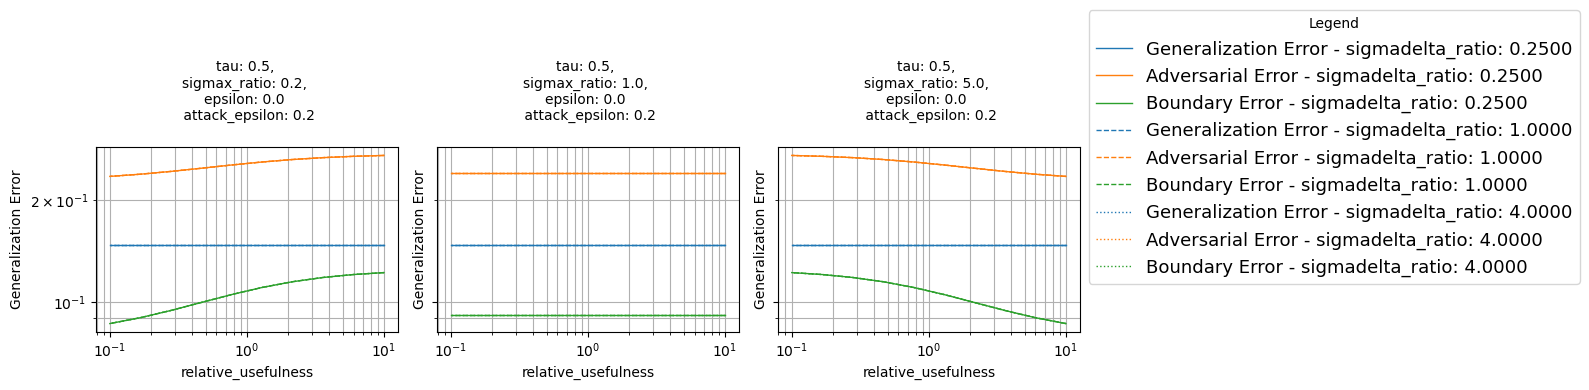

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:147: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:154: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(additional_state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{name} - {sweep}: {epsilon:.4f}', color=palette[idx])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:184: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  delta_scale_value = float(epsilon_subs

saving plot


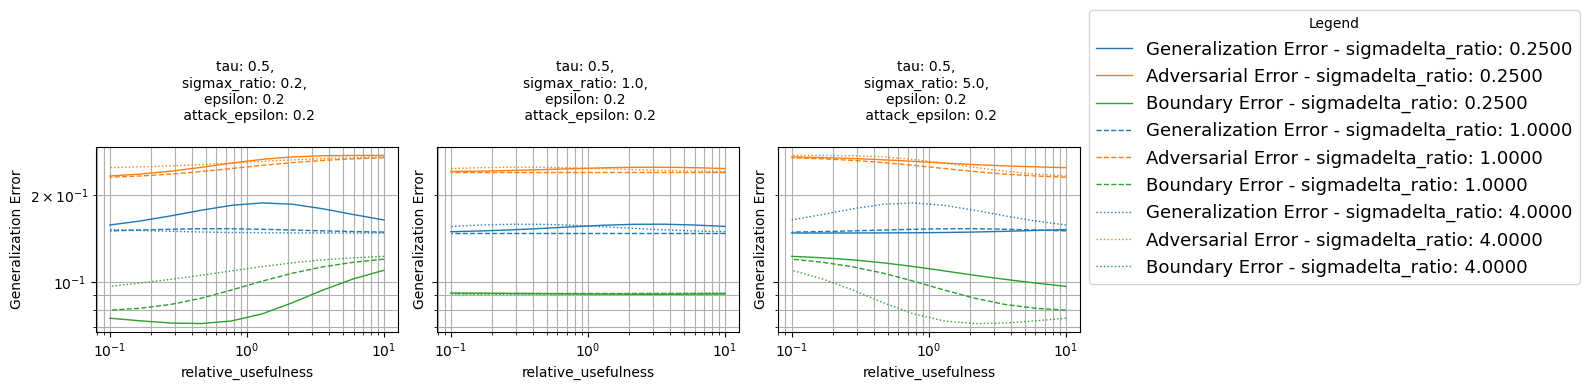

In [3445]:
plot_additionally_state_evolution = ["adversarial_generalization_error_state_evolution","difference_adv_gen_state_evolution"]
plot_additionally_names=["Adversarial Error","Boundary Error"]
create_plot(df2, "Generalization Error", "generalization_error_state_evolution", None, plot_additionally_names=plot_additionally_names,plot_additionally_state_evolution=plot_additionally_state_evolution,plot_attack_epsilon=True)

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:147: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:184: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  delta_scale_value = float(epsilon_subset["sigmadelta_scale_state_evolution"].mean()[0])


saving plot


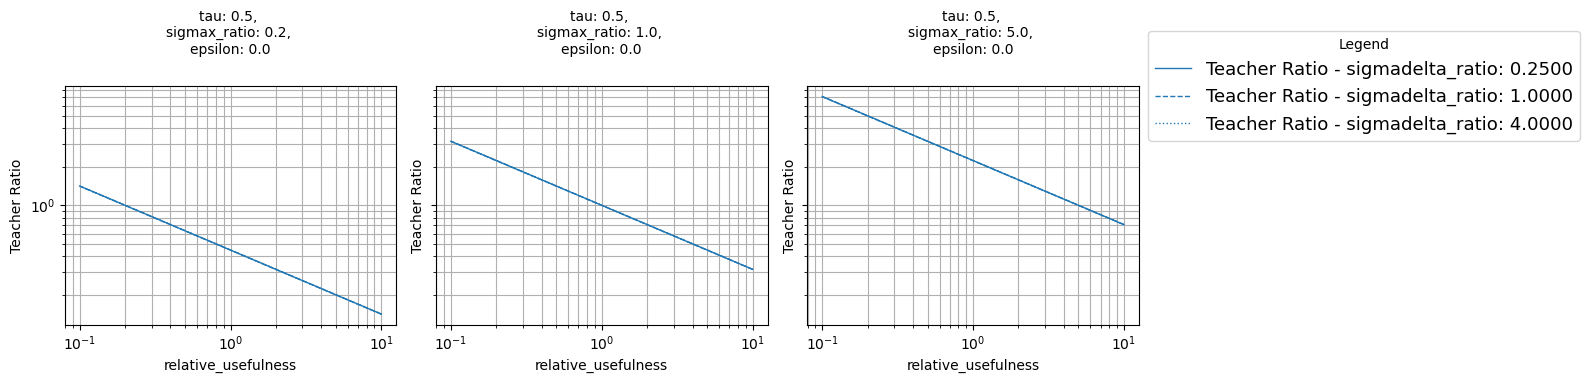

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:147: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:184: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  delta_scale_value = float(epsilon_subset["sigmadelta_scale_state_evolution"].mean()[0])


saving plot


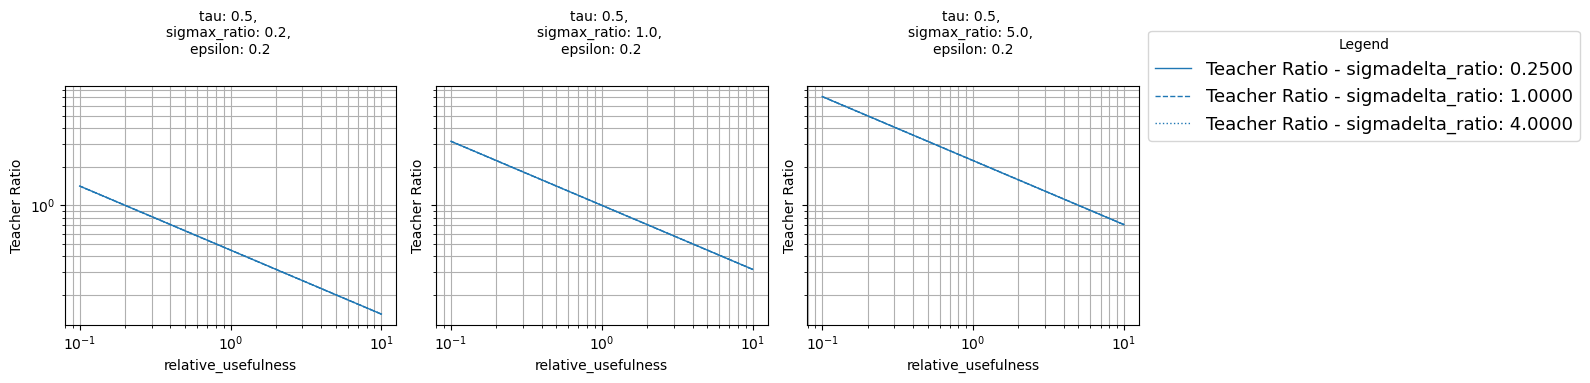

In [3446]:
create_plot(df2, "Teacher Ratio", "theta_ratio", None, log_y=True)

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:147: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:184: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  delta_scale_value = float(epsilon_subset["sigmadelta_scale_state_evolution"].mean()[0])


saving plot


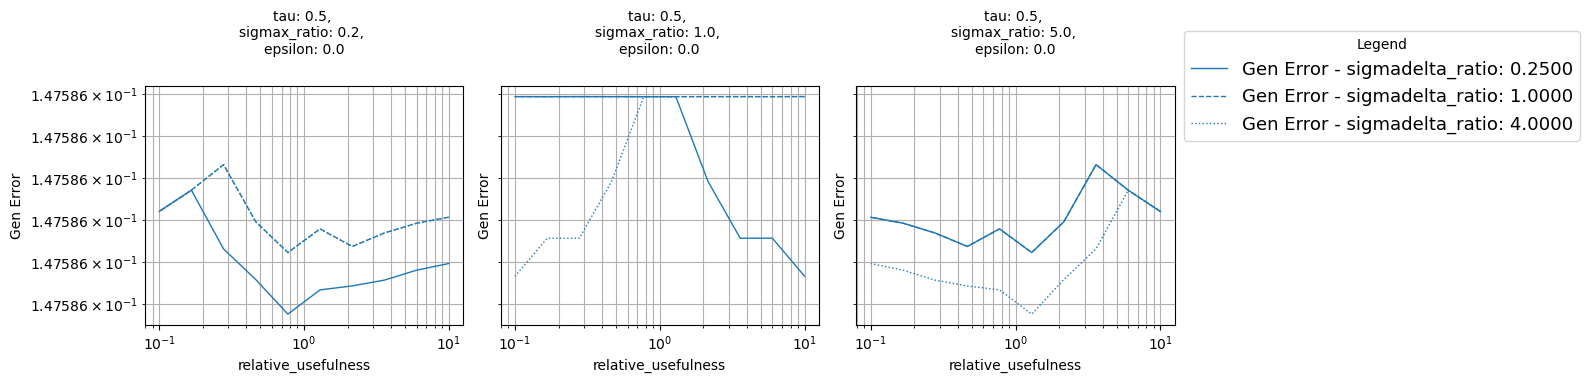

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:147: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:184: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  delta_scale_value = float(epsilon_subset["sigmadelta_scale_state_evolution"].mean()[0])


saving plot


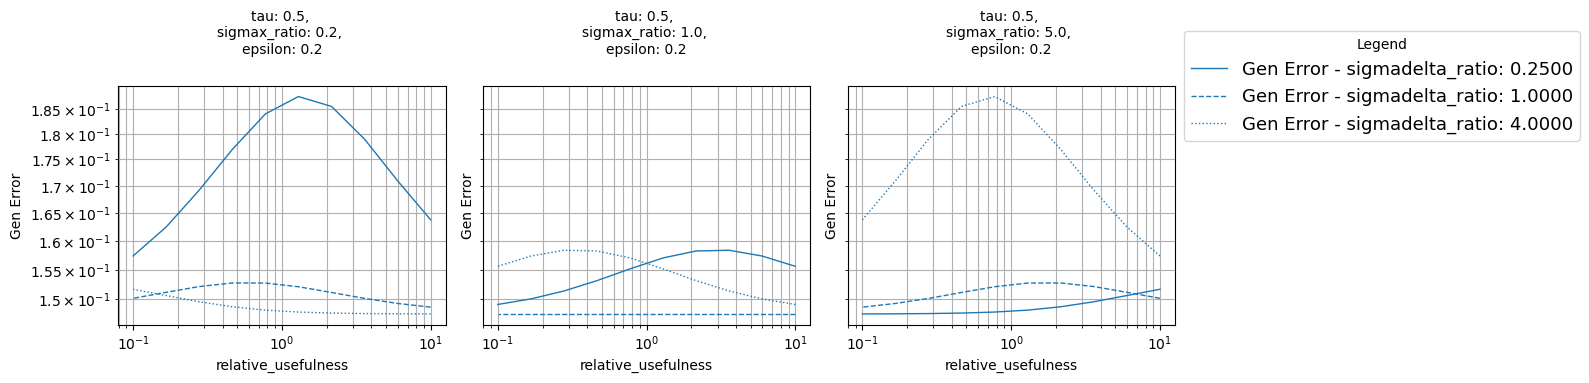

In [3447]:
create_plot(df2, "Gen Error", "generalization_error_state_evolution", None)

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:147: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:184: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  delta_scale_value = float(epsilon_subset["sigmadelta_scale_state_evolution"].mean()[0])


saving plot


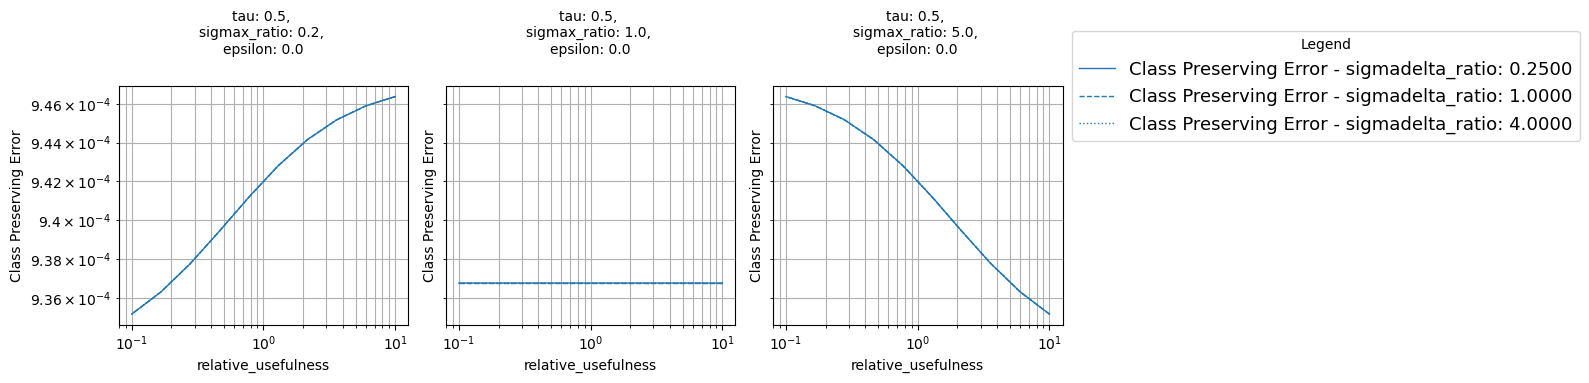

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:147: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:184: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  delta_scale_value = float(epsilon_subset["sigmadelta_scale_state_evolution"].mean()[0])


saving plot


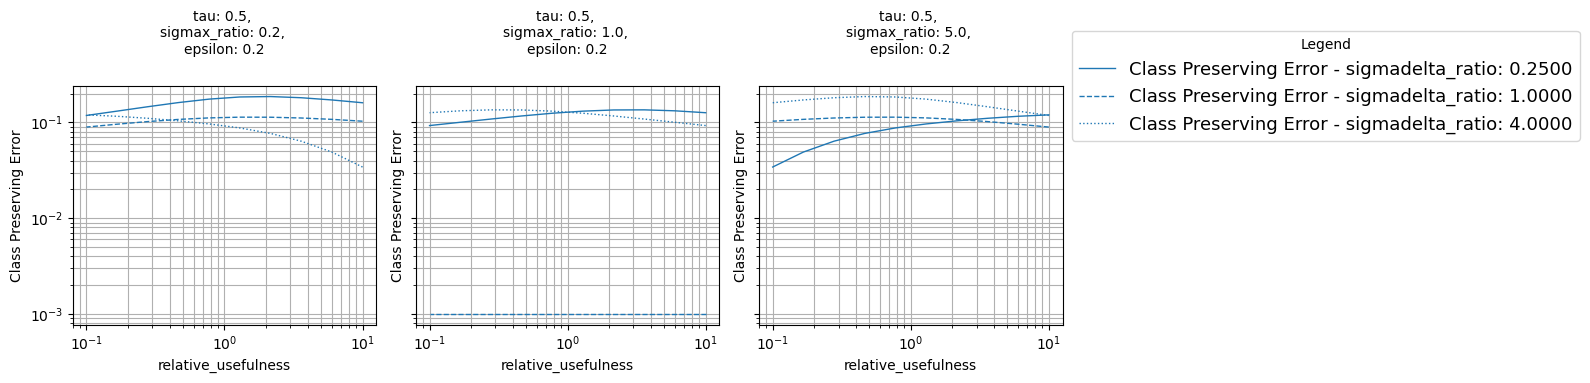

In [3448]:
create_plot(df2, "Class Preserving Error", "fair_adversarial_error_state_evolution", None, log_y=True)

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:147: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:161: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.errorbar(epsilon_subset[target], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[0], capsize=5)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:184: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always b

saving plot


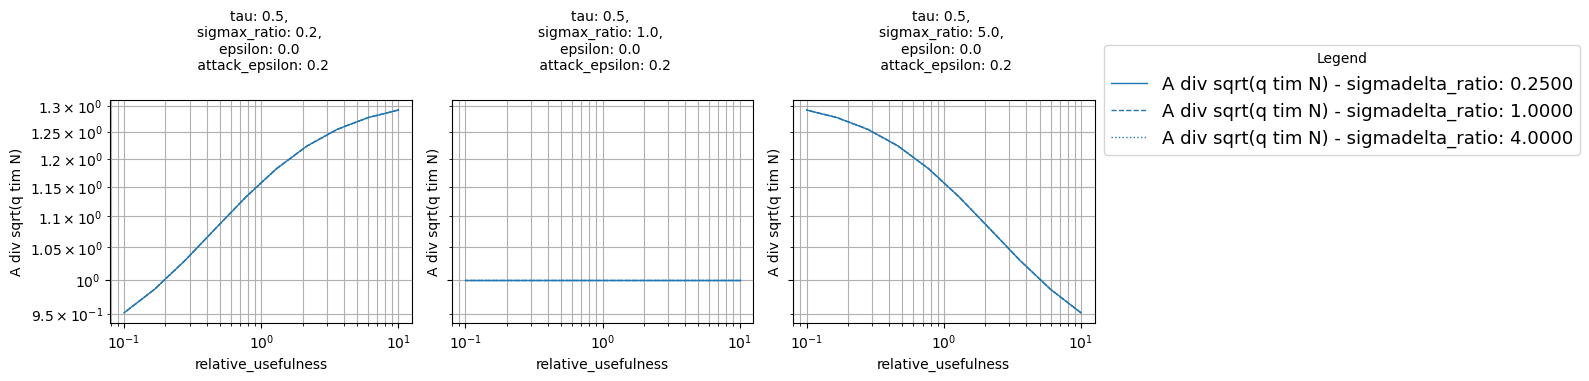

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:147: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:161: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.errorbar(epsilon_subset[target], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[0], capsize=5)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:184: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  delta_scale_value = float(epsilon_subset["sigmadelta_scale_state_evol

saving plot


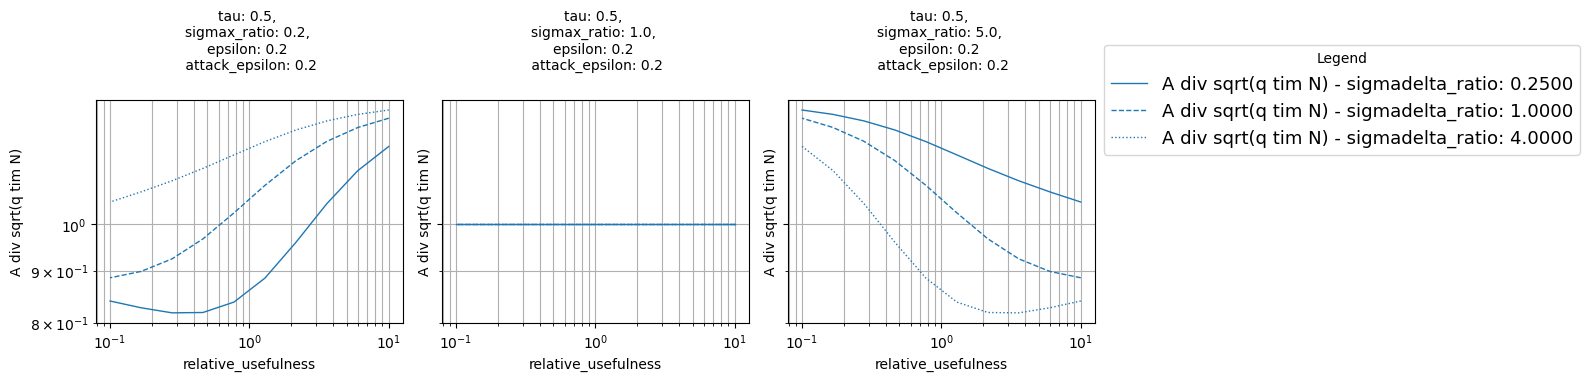

In [3449]:
plot_additionally_names = ["Overlap N", "Overlap q"]
plot_additionally_state_evolution = ["N_state_evolution", "q_state_evolution"]
create_plot(df, "A div sqrt(q tim N)", "A_over_sqrt_qN_state_evolution", "A_over_sqrt_qN_erm",plot_attack_epsilon=True)
# create_plot(df, "DataModel A div sqrt(q tim N)", "data_model_attackability_state_evolution", "A_over_sqrt_qN_state_evolution",plot_attack_epsilon=True, log_y=False)

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:147: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:154: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(additional_state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{name} - {sweep}: {epsilon:.4f}', color=palette[idx])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:161: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.errorbar(epsilo

saving plot


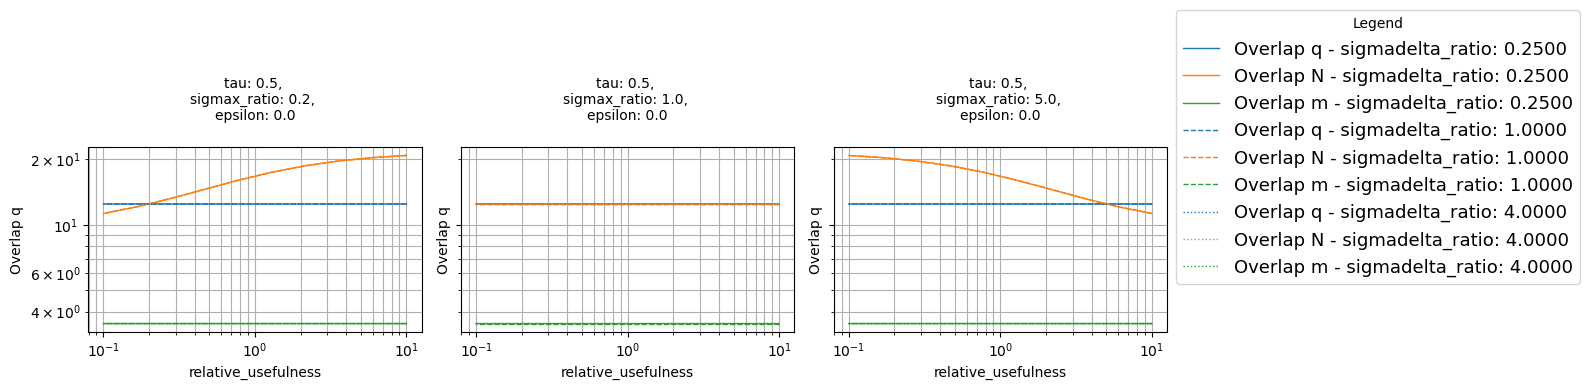

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:147: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:154: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(additional_state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{name} - {sweep}: {epsilon:.4f}', color=palette[idx])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:161: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.errorbar(epsilon_subset[target], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[0], capsize=5)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/i

saving plot


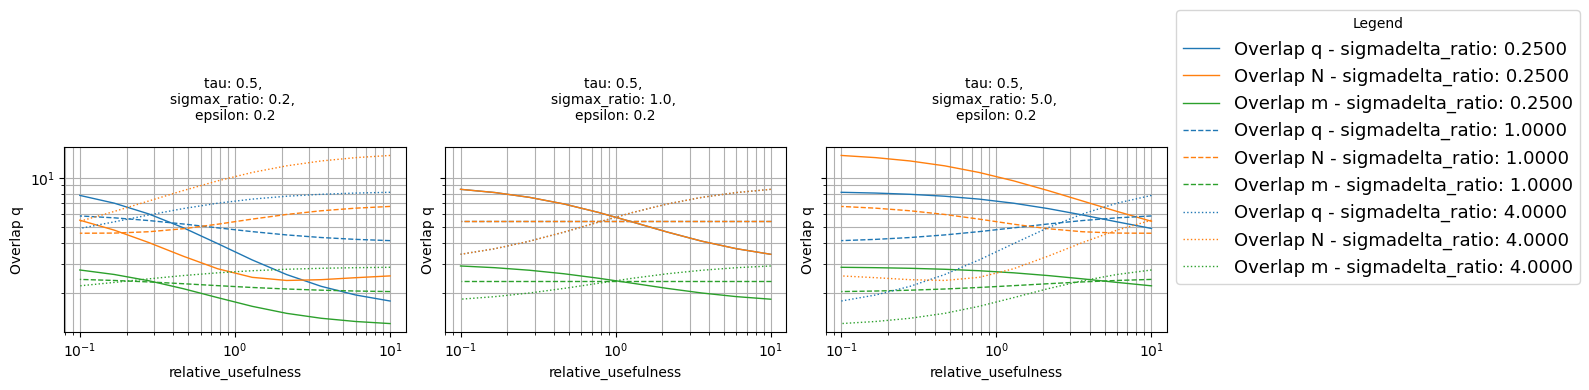

In [3450]:
plot_additionally_names = ["Overlap N", "Overlap m"]
plot_additionally_state_evolution = ["N_state_evolution", "m_state_evolution"]
create_plot(df, "Overlap q", "q_state_evolution","q_erm", log_y=True, plot_additionally_names=plot_additionally_names,plot_additionally_state_evolution=plot_additionally_state_evolution)

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:147: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:184: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  delta_scale_value = float(epsilon_subset["sigmadelta_scale_state_evolution"].mean()[0])


saving plot


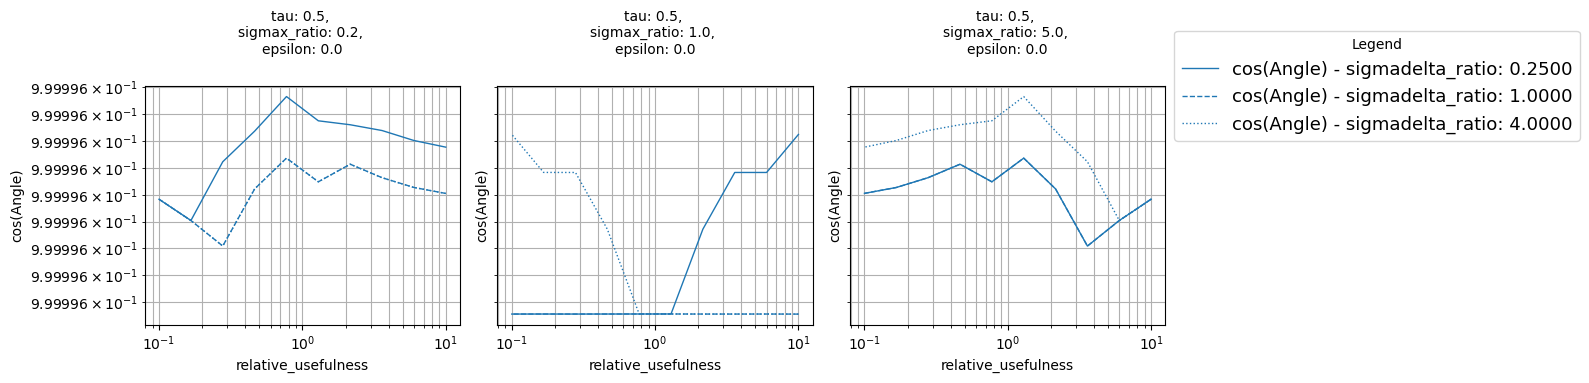

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:147: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:184: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  delta_scale_value = float(epsilon_subset["sigmadelta_scale_state_evolution"].mean()[0])


saving plot


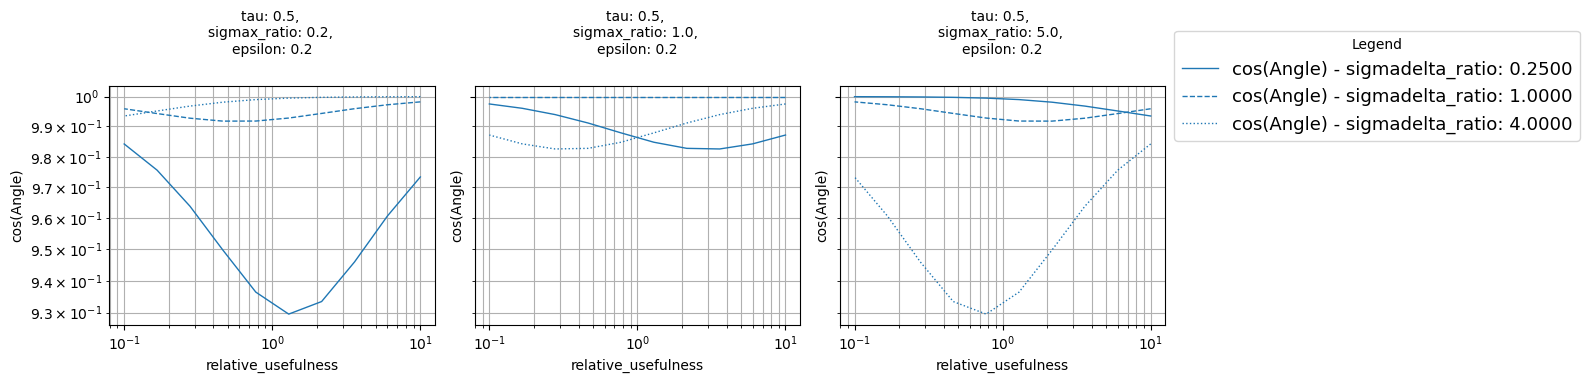

In [3451]:
create_plot(df, "cos(Angle)", "angle_state_evolution",None)

In [3452]:
raise Exception("Stop here")

Exception: Stop here

In [ ]:
# def compute_angle_direct(row):
#     tau =  row["tau"]
#     epsilon = row["epsilon"]
#     alpha = row["alpha"]
#     sigmax_ratio = row["sigmax_ratio"]
#     theta_ratio = row["theta_ratio"]
#     sigmadelta_ratio = row["sigmadelta_ratio"]
#     sigmadelta_scale = row["sigmadelta_scale_state_evolution"]["mean"]

#     d = 1000
#     P_hat = row["P_hat_state_evolution"]["mean"]
#     N_hat = row["N_hat_state_evolution"]["mean"]
#     V_hat = row["sigma_hat_state_evolution"]["mean"]
#     m_hat = row["m_hat_state_evolution"]["mean"]
#     q_hat = row["q_hat_state_evolution"]["mean"]
#     m_original = row["m_state_evolution"]["mean"]
#     q_original = row["q_state_evolution"]["mean"]
#     rho_original = row["rho_state_evolution"]["mean"]

#     actual_sigmax_ratio = row["sigmax_subspace_ratio_state_evolution"]["mean"]
#     actual_theta_ratio = np.sqrt(row["sigmatheta_subspace_ratio_state_evolution"]["mean"])
#     actual_phiphit_ratio = row["phiphit_subspace_ratio_state_evolution"]["mean"]
    


#     # convert to float
#     tau = float(tau)
#     alpha = float(alpha)
#     epsilon = float(epsilon)
#     sigmax_ratio = float(sigmax_ratio)
#     theta_ratio = float(theta_ratio)
#     sigmadelta_ratio = float(sigmadelta_ratio)
#     sigmadelta_scale = float(sigmadelta_scale)
#     P_hat = float(P_hat)
#     N_hat = float(N_hat)
#     V_hat = float(V_hat)
#     m_hat = float(m_hat)
#     q_hat = float(q_hat)
#     actual_sigmax_ratio = float(actual_sigmax_ratio)
#     actual_theta_ratio = float(actual_theta_ratio)
#     actual_theta_ratio = 1/actual_theta_ratio
#     actual_phiphit_ratio = float(actual_phiphit_ratio)

#     P_hat /= alpha
#     N_hat /= alpha
#     V_hat /= alpha
#     m_hat /= alpha
#     q_hat /= alpha


#     """
#     Sanity check
#     """


#     # assert sigmax close to actual_sigmax_ratio
#     assert np.abs(sigmax_ratio - actual_sigmax_ratio) < 1e-5, f"sigmax_ratio: {sigmax_ratio}, actual_sigmax_ratio: {actual_sigmax_ratio}"
#     # assert theta close to actual_theta_ratio
#     assert np.abs(theta_ratio - actual_theta_ratio) < 1e-5, f"theta_ratio: {theta_ratio}, actual_theta_ratio: {actual_theta_ratio}"
#     # let's test if we understand phiphit. phiphitratio = sigmax**2 / theta**2
#     assert np.abs(actual_phiphit_ratio - sigmax_ratio**2 / theta_ratio**2) < 1e-5, f"actual_phiphit_ratio: {actual_phiphit_ratio}, sigmax_ratio**2 / theta_ratio**2: {sigmax_ratio**2 / theta_ratio**2}"


#     """
#     rho = 1 normalisation
#     """
    
#     vhatNorm = np.sqrt( 0.5*(theta_ratio**2 + sigmax_ratio))
#     denom1 = P_hat * sigmadelta_scale * sigmadelta_ratio + N_hat  + V_hat/vhatNorm
#     denom2 = P_hat * sigmadelta_scale + N_hat + V_hat*sigmax_ratio/vhatNorm

#     numerator = theta_ratio**2/denom1 + sigmax_ratio**2/denom2

#     rho_equivalent = (theta_ratio**2 + sigmax_ratio) * ( 1 + tau **2 ) 

#     q_equivalent = theta_ratio**2/denom1**2 + sigmax_ratio**3/denom2**2

#     denom = np.sqrt( rho_equivalent * q_equivalent )

#     return numerator / denom 

# def compute_q_direct(row):
#     tau =  row["tau"]
#     epsilon = row["epsilon"]
#     alpha = row["alpha"]
#     sigmax_ratio = row["sigmax_ratio"]
#     theta_ratio = row["theta_ratio"]
#     sigmadelta_ratio = row["sigmadelta_ratio"]
#     sigmadelta_scale = row["sigmadelta_scale_state_evolution"]["mean"]

#     d = 1000
#     P_hat = row["P_hat_state_evolution"]["mean"]
#     N_hat = row["N_hat_state_evolution"]["mean"]
#     V_hat = row["sigma_hat_state_evolution"]["mean"]
#     m_hat = row["m_hat_state_evolution"]["mean"]
#     q_hat = row["q_hat_state_evolution"]["mean"]
#     m_original = row["m_state_evolution"]["mean"]
#     q_original = row["q_state_evolution"]["mean"]
#     rho_original = row["rho_state_evolution"]["mean"]

#     actual_sigmax_ratio = row["sigmax_subspace_ratio_state_evolution"]["mean"]
#     actual_theta_ratio = np.sqrt(row["sigmatheta_subspace_ratio_state_evolution"]["mean"])
#     actual_phiphit_ratio = row["phiphit_subspace_ratio_state_evolution"]["mean"]
    


#     # convert to float
#     tau = float(tau)
#     alpha = float(alpha)
#     epsilon = float(epsilon)
#     sigmax_ratio = float(sigmax_ratio)
#     theta_ratio = float(theta_ratio)
#     sigmadelta_ratio = float(sigmadelta_ratio)
#     sigmadelta_scale = float(sigmadelta_scale)
#     P_hat = float(P_hat)
#     N_hat = float(N_hat)
#     V_hat = float(V_hat)
#     m_hat = float(m_hat)
#     q_hat = float(q_hat)
#     actual_sigmax_ratio = float(actual_sigmax_ratio)
#     actual_theta_ratio = float(actual_theta_ratio)
#     actual_theta_ratio = 1/actual_theta_ratio
#     actual_phiphit_ratio = float(actual_phiphit_ratio)


#     """
#     Sanity check
#     """


#     # assert sigmax close to actual_sigmax_ratio
#     assert np.abs(sigmax_ratio - actual_sigmax_ratio) < 1e-7, f"sigmax_ratio: {sigmax_ratio}, actual_sigmax_ratio: {actual_sigmax_ratio}"
#     # assert theta close to actual_theta_ratio
#     assert np.abs(theta_ratio - actual_theta_ratio) < 1e-7, f"theta_ratio: {theta_ratio}, actual_theta_ratio: {actual_theta_ratio}"
#     # let's test if we understand phiphit. phiphitratio = sigmax**2 / theta**2
#     assert np.abs(actual_phiphit_ratio - sigmax_ratio**2 / theta_ratio**2) < 1e-7, f"actual_phiphit_ratio: {actual_phiphit_ratio}, sigmax_ratio**2 / theta_ratio**2: {sigmax_ratio**2 / theta_ratio**2}"


#     """
#     rho = 1 normalisation
#     """
    
#     vhatNorm = np.sqrt( 0.5*(theta_ratio**2 + sigmax_ratio))
#     denom1 = P_hat * sigmadelta_scale * sigmadelta_ratio + N_hat  + V_hat/vhatNorm
#     denom2 = P_hat * sigmadelta_scale + N_hat + V_hat*sigmax_ratio/vhatNorm



#     q_equivalent = theta_ratio**2/denom1**2 + sigmax_ratio**3/denom2**2

#     q_equivalent = 2 * m_hat**2 * q_equivalent / ( (theta_ratio**2 + sigmax_ratio)**(2) )

#     return q_equivalent

# def compute_m_direct(row):
#     tau =  row["tau"]
#     epsilon = row["epsilon"]
#     alpha = row["alpha"]
#     sigmax_ratio = row["sigmax_ratio"]
#     theta_ratio = row["theta_ratio"]
#     sigmadelta_ratio = row["sigmadelta_ratio"]
#     sigmadelta_scale = row["sigmadelta_scale_state_evolution"]["mean"]

#     d = 1000
#     P_hat = row["P_hat_state_evolution"]["mean"]
#     N_hat = row["N_hat_state_evolution"]["mean"]
#     V_hat = row["sigma_hat_state_evolution"]["mean"]
#     m_hat = row["m_hat_state_evolution"]["mean"]
#     q_hat = row["q_hat_state_evolution"]["mean"]
#     m_original = row["m_state_evolution"]["mean"]
#     q_original = row["q_state_evolution"]["mean"]
#     rho_original = row["rho_state_evolution"]["mean"]

#     actual_sigmax_ratio = row["sigmax_subspace_ratio_state_evolution"]["mean"]
#     actual_theta_ratio = np.sqrt(row["sigmatheta_subspace_ratio_state_evolution"]["mean"])
#     actual_phiphit_ratio = row["phiphit_subspace_ratio_state_evolution"]["mean"]
    


#     # convert to float
#     tau = float(tau)
#     alpha = float(alpha)
#     epsilon = float(epsilon)
#     sigmax_ratio = float(sigmax_ratio)
#     theta_ratio = float(theta_ratio)
#     sigmadelta_ratio = float(sigmadelta_ratio)
#     sigmadelta_scale = float(sigmadelta_scale)
#     P_hat = float(P_hat)
#     N_hat = float(N_hat)
#     V_hat = float(V_hat)
#     m_hat = float(m_hat)
#     q_hat = float(q_hat)
#     actual_sigmax_ratio = float(actual_sigmax_ratio)
#     actual_theta_ratio = float(actual_theta_ratio)
#     actual_theta_ratio = 1/actual_theta_ratio
#     actual_phiphit_ratio = float(actual_phiphit_ratio)


#     """
#     Sanity check
#     """


#     # assert sigmax close to actual_sigmax_ratio
#     assert np.abs(sigmax_ratio - actual_sigmax_ratio) < 1e-5, f"sigmax_ratio: {sigmax_ratio}, actual_sigmax_ratio: {actual_sigmax_ratio}"
#     # assert theta close to actual_theta_ratio
#     assert np.abs(theta_ratio - actual_theta_ratio) < 1e-5, f"theta_ratio: {theta_ratio}, actual_theta_ratio: {actual_theta_ratio}"
#     # let's test if we understand phiphit. phiphitratio = sigmax**2 / theta**2
#     assert np.abs(actual_phiphit_ratio - sigmax_ratio**2 / theta_ratio**2) < 1e-5, f"actual_phiphit_ratio: {actual_phiphit_ratio}, sigmax_ratio**2 / theta_ratio**2: {sigmax_ratio**2 / theta_ratio**2}"


#     """
#     rho = 1 normalisation
#     """
    
#     vhatNorm = np.sqrt( 0.5*(theta_ratio**2 + sigmax_ratio))
#     denom1 = P_hat * sigmadelta_scale * sigmadelta_ratio + N_hat  + V_hat/vhatNorm
#     denom2 = P_hat * sigmadelta_scale + N_hat + V_hat*sigmax_ratio/vhatNorm



#     m_equivalent = theta_ratio**2/denom1 + sigmax_ratio**2/denom2

#     m_equivalent = np.sqrt(2) * m_hat * m_equivalent / ( (theta_ratio**2 + sigmax_ratio)**(3/2) )

#     return m_equivalent

# def compute_A_direct(row):
#     tau =  row["tau"]
#     epsilon = row["epsilon"]
#     alpha = row["alpha"]
#     sigmax_ratio = row["sigmax_ratio"]
#     theta_ratio = row["theta_ratio"]
#     sigmadelta_ratio = row["sigmadelta_ratio"]
#     sigmadelta_scale = row["sigmadelta_scale_state_evolution"]["mean"]

#     d = 1000
#     P_hat = row["P_hat_state_evolution"]["mean"]
#     N_hat = row["N_hat_state_evolution"]["mean"]
#     V_hat = row["sigma_hat_state_evolution"]["mean"]
#     m_hat = row["m_hat_state_evolution"]["mean"]
#     q_hat = row["q_hat_state_evolution"]["mean"]
#     m_original = row["m_state_evolution"]["mean"]
#     q_original = row["q_state_evolution"]["mean"]
#     rho_original = row["rho_state_evolution"]["mean"]

#     actual_sigmax_ratio = row["sigmax_subspace_ratio_state_evolution"]["mean"]
#     actual_theta_ratio = np.sqrt(row["sigmatheta_subspace_ratio_state_evolution"]["mean"])
#     actual_phiphit_ratio = row["phiphit_subspace_ratio_state_evolution"]["mean"]
    


#     # convert to float
#     tau = float(tau)
#     alpha = float(alpha)
#     epsilon = float(epsilon)
#     sigmax_ratio = float(sigmax_ratio)
#     theta_ratio = float(theta_ratio)
#     sigmadelta_ratio = float(sigmadelta_ratio)
#     sigmadelta_scale = float(sigmadelta_scale)
#     P_hat = float(P_hat)
#     N_hat = float(N_hat)
#     V_hat = float(V_hat)
#     m_hat = float(m_hat)
#     q_hat = float(q_hat)
#     actual_sigmax_ratio = float(actual_sigmax_ratio)
#     actual_theta_ratio = float(actual_theta_ratio)
#     actual_theta_ratio = 1/actual_theta_ratio
#     actual_phiphit_ratio = float(actual_phiphit_ratio)


#     """
#     Sanity check
#     """


#     # assert sigmax close to actual_sigmax_ratio
#     assert np.abs(sigmax_ratio - actual_sigmax_ratio) < 1e-5, f"sigmax_ratio: {sigmax_ratio}, actual_sigmax_ratio: {actual_sigmax_ratio}"
#     # assert theta close to actual_theta_ratio
#     assert np.abs(theta_ratio - actual_theta_ratio) < 1e-5, f"theta_ratio: {theta_ratio}, actual_theta_ratio: {actual_theta_ratio}"
#     # let's test if we understand phiphit. phiphitratio = sigmax**2 / theta**2
#     assert np.abs(actual_phiphit_ratio - sigmax_ratio**2 / theta_ratio**2) < 1e-5, f"actual_phiphit_ratio: {actual_phiphit_ratio}, sigmax_ratio**2 / theta_ratio**2: {sigmax_ratio**2 / theta_ratio**2}"


#     """
#     rho = 1 normalisation
#     """
    
#     vhatNorm = np.sqrt( 0.5*(theta_ratio**2 + sigmax_ratio))
#     denom1 = P_hat * sigmadelta_scale * sigmadelta_ratio + N_hat  + V_hat/vhatNorm
#     denom2 = P_hat * sigmadelta_scale + N_hat + V_hat*sigmax_ratio/vhatNorm



#     A_equivalent = theta_ratio**2/denom1**2 + sigmax_ratio**2/denom2**2

#     A_equivalent = np.sqrt(2) * m_hat**2 * A_equivalent / ( (theta_ratio**2 + sigmax_ratio)**(3/2) )

#     return A_equivalent

# def compute_F_direct(row):
#     tau =  row["tau"]
#     epsilon = row["epsilon"]
#     alpha = row["alpha"]
#     sigmax_ratio = row["sigmax_ratio"]
#     theta_ratio = row["theta_ratio"]
#     sigmadelta_ratio = row["sigmadelta_ratio"]
#     sigmadelta_scale = row["sigmadelta_scale_state_evolution"]["mean"]

#     d = 1000
#     P_hat = row["P_hat_state_evolution"]["mean"]
#     N_hat = row["N_hat_state_evolution"]["mean"]
#     V_hat = row["sigma_hat_state_evolution"]["mean"]
#     m_hat = row["m_hat_state_evolution"]["mean"]
#     q_hat = row["q_hat_state_evolution"]["mean"]
#     m_original = row["m_state_evolution"]["mean"]
#     q_original = row["q_state_evolution"]["mean"]
#     rho_original = row["rho_state_evolution"]["mean"]

#     actual_sigmax_ratio = row["sigmax_subspace_ratio_state_evolution"]["mean"]
#     actual_theta_ratio = np.sqrt(row["sigmatheta_subspace_ratio_state_evolution"]["mean"])
#     actual_phiphit_ratio = row["phiphit_subspace_ratio_state_evolution"]["mean"]
    


#     # convert to float
#     tau = float(tau)
#     alpha = float(alpha)
#     epsilon = float(epsilon)
#     sigmax_ratio = float(sigmax_ratio)
#     theta_ratio = float(theta_ratio)
#     sigmadelta_ratio = float(sigmadelta_ratio)
#     sigmadelta_scale = float(sigmadelta_scale)
#     P_hat = float(P_hat)
#     N_hat = float(N_hat)
#     V_hat = float(V_hat)
#     m_hat = float(m_hat)
#     q_hat = float(q_hat)
#     actual_sigmax_ratio = float(actual_sigmax_ratio)
#     actual_theta_ratio = float(actual_theta_ratio)
#     actual_theta_ratio = 1/actual_theta_ratio
#     actual_phiphit_ratio = float(actual_phiphit_ratio)


#     """
#     Sanity check
#     """


#     # assert sigmax close to actual_sigmax_ratio
#     assert np.abs(sigmax_ratio - actual_sigmax_ratio) < 1e-5, f"sigmax_ratio: {sigmax_ratio}, actual_sigmax_ratio: {actual_sigmax_ratio}"
#     # assert theta close to actual_theta_ratio
#     assert np.abs(theta_ratio - actual_theta_ratio) < 1e-5, f"theta_ratio: {theta_ratio}, actual_theta_ratio: {actual_theta_ratio}"
#     # let's test if we understand phiphit. phiphitratio = sigmax**2 / theta**2
#     assert np.abs(actual_phiphit_ratio - sigmax_ratio**2 / theta_ratio**2) < 1e-5, f"actual_phiphit_ratio: {actual_phiphit_ratio}, sigmax_ratio**2 / theta_ratio**2: {sigmax_ratio**2 / theta_ratio**2}"


#     """
#     rho = 1 normalisation
#     """
    
#     vhatNorm = np.sqrt( 0.5*(theta_ratio**2 + sigmax_ratio))
#     denom1 = P_hat * sigmadelta_scale * sigmadelta_ratio + N_hat  + V_hat/vhatNorm
#     denom2 = P_hat * sigmadelta_scale + N_hat + V_hat*sigmax_ratio/vhatNorm



#     F_equivalent = theta_ratio**2/denom1 + sigmax_ratio/denom2

#     F_equivalent = 2 * m_hat * F_equivalent / ( (theta_ratio**2 + sigmax_ratio) )

#     return F_equivalent


# def compute_gen_error_direct( row):
#     angle = row["angle_direct"]["mean"]
#     angle = float(angle)
#     return np.arccos(angle) / np.pi
    
# def compute_attackability_direct(row):
#     tau =  row["tau"]
#     epsilon = row["epsilon"]
#     alpha = row["alpha"]
#     sigmax_ratio = row["sigmax_ratio"]
#     theta_ratio = row["theta_ratio"]
#     sigmadelta_ratio = row["sigmadelta_ratio"]
#     sigmadelta_scale = row["sigmadelta_scale_state_evolution"]["mean"]

#     d = 1000
#     P_hat = row["P_hat_state_evolution"]["mean"]
#     N_hat = row["N_hat_state_evolution"]["mean"]
#     V_hat = row["sigma_hat_state_evolution"]["mean"]
#     m_hat = row["m_hat_state_evolution"]["mean"]
#     q_hat = row["q_hat_state_evolution"]["mean"]
#     m_original = row["m_state_evolution"]["mean"]
#     q_original = row["q_state_evolution"]["mean"]
#     rho_original = row["rho_state_evolution"]["mean"]

#     actual_sigmax_ratio = row["sigmax_subspace_ratio_state_evolution"]["mean"]
#     actual_theta_ratio = np.sqrt(row["sigmatheta_subspace_ratio_state_evolution"]["mean"])
#     actual_phiphit_ratio = row["phiphit_subspace_ratio_state_evolution"]["mean"]
    


#     # convert to float
#     tau = float(tau)
#     alpha = float(alpha)
#     epsilon = float(epsilon)
#     sigmax_ratio = float(sigmax_ratio)
#     theta_ratio = float(theta_ratio)
#     sigmadelta_ratio = float(sigmadelta_ratio)
#     sigmadelta_scale = float(sigmadelta_scale)
#     P_hat = float(P_hat)
#     N_hat = float(N_hat)
#     V_hat = float(V_hat)
#     m_hat = float(m_hat)
#     q_hat = float(q_hat)
#     actual_sigmax_ratio = float(actual_sigmax_ratio)
#     actual_theta_ratio = float(actual_theta_ratio)
#     actual_theta_ratio = 1/actual_theta_ratio
#     actual_phiphit_ratio = float(actual_phiphit_ratio)

#     P_hat_zero = P_hat / alpha
#     N_hat_zero = N_hat / alpha
#     V_hat_zero = V_hat / alpha
#     m_hat_zero = m_hat / alpha
#     q_hat_zero = q_hat / alpha


#     """
#     Sanity check
#     """


#     # assert sigmax close to actual_sigmax_ratio
#     assert np.abs(sigmax_ratio - actual_sigmax_ratio) < 1e-5, f"sigmax_ratio: {sigmax_ratio}, actual_sigmax_ratio: {actual_sigmax_ratio}"
#     # assert theta close to actual_theta_ratio
#     assert np.abs(theta_ratio - actual_theta_ratio) < 1e-5, f"theta_ratio: {theta_ratio}, actual_theta_ratio: {actual_theta_ratio}"
#     # let's test if we understand phiphit. phiphitratio = sigmax**2 / theta**2
#     assert np.abs(actual_phiphit_ratio - sigmax_ratio**2 / theta_ratio**2) < 1e-5, f"actual_phiphit_ratio: {actual_phiphit_ratio}, sigmax_ratio**2 / theta_ratio**2: {sigmax_ratio**2 / theta_ratio**2}"


#     """
#     rho = 1 normalisation
#     """
    
#     vhatNorm = np.sqrt( 0.5*(theta_ratio**2 + sigmax_ratio))
#     denom1 = P_hat_zero * sigmadelta_scale * sigmadelta_ratio + N_hat_zero  + V_hat_zero/vhatNorm
#     denom2 = P_hat_zero * sigmadelta_scale + N_hat_zero + V_hat_zero*sigmax_ratio/vhatNorm

    
#     A_equivalent = theta_ratio**2/denom1**2 + sigmax_ratio**2/denom2**2
#     A_equivalent =  np.sqrt(2) * A_equivalent / ( (theta_ratio**2 + sigmax_ratio)**(3/2) )

#     n_equivalent = theta_ratio**2/denom1**2 + sigmax_ratio**2/denom2**2
#     q_equivalent = theta_ratio**2/denom1**2 + sigmax_ratio**3/denom2**2

#     n_equivalent = np.sqrt(2) * n_equivalent / ( (theta_ratio**2 + sigmax_ratio)**(3/2) )
#     q_equivalent = 2 * q_equivalent / ( (theta_ratio**2 + sigmax_ratio)**(2) )

#     return A_equivalent / np.sqrt( n_equivalent * q_equivalent )

# def compute_angle_from_direct_overlaps(row):
#     q_direct = row["q_direct"]["mean"]
#     m_direct = row["m_direct"]["mean"]
#     tau = row["tau"]

#     q_direct = float(q_direct)
#     m_direct = float(m_direct)
#     tau = float(tau)

#     return np.arccos( m_direct / np.sqrt( ( 1 + tau**2 ) * q_direct) ) / np.pi


# from scipy.special import erfc, erf, logit, owens_t

# def compute_adversarial_test_error(row):
    
#     epsilon = row["epsilon"]
#     tau = row["tau"]
#     epsilon = float(epsilon)
#     tau = float(tau)

#     attackability = row["attackability_direct"]["mean"]
#     angle = row["angle_direct"]["mean"]

#     attackability = float(attackability)
#     angle = float(angle)


#     # compute the adversarial test error
#     a = angle / np.sqrt((1 + tau**2 ) - angle**2)

#     b = epsilon * attackability

#     owen = 2 * owens_t(a*b , 1/a)

#     erferfc = 0.5 * erf(b/np.sqrt(2)) * erfc(-a*b/np.sqrt(2))

#     adv_error = owen + erferfc 

#     return adv_error

# def compute_adversarial_test_error_direct_overlap(row):
#     epsilon = row["epsilon"]
#     tau = row["tau"]
#     epsilon = float(epsilon)
#     tau = float(tau)

#     A = row["A_direct"]["mean"]
#     q = row["q_direct"]["mean"]
#     angle = row["angle_direct"]["mean"]

#     A = float(A)
#     angle = float(angle)
#     q = float(q)

#     attackability = np.sqrt( A / q)

#     # compute the adversarial test error
#     a = angle / np.sqrt((1 + tau**2 ) - angle**2)

#     b = epsilon * attackability

#     owen = 2 * owens_t(a*b , 1/a)

#     erferfc = 0.5 * erf(b/np.sqrt(2)) * erfc(-a*b/np.sqrt(2))

#     adv_error = owen + erferfc 

#     return adv_error


# from scipy.integrate import quad

# def fair_adversarial_error_overlaps(row):
#     tau =  row["tau"]
#     epsilon = row["epsilon"]
#     alpha = row["alpha"]
#     sigmax_ratio = row["sigmax_ratio"]
#     theta_ratio = row["theta_ratio"]
#     sigmadelta_ratio = row["sigmadelta_ratio"]
#     sigmadelta_scale = row["sigmadelta_scale_state_evolution"]["mean"]

#     d = 1000
#     P_hat = row["P_hat_state_evolution"]["mean"]
#     N_hat = row["N_hat_state_evolution"]["mean"]
#     V_hat = row["sigma_hat_state_evolution"]["mean"]
#     m_hat = row["m_hat_state_evolution"]["mean"]
#     q_hat = row["q_hat_state_evolution"]["mean"]
#     m_original = row["m_state_evolution"]["mean"]
#     q_original = row["q_state_evolution"]["mean"]
#     rho_original = row["rho_state_evolution"]["mean"]

#     actual_sigmax_ratio = row["sigmax_subspace_ratio_state_evolution"]["mean"]
#     actual_theta_ratio = np.sqrt(row["sigmatheta_subspace_ratio_state_evolution"]["mean"])
#     actual_phiphit_ratio = row["phiphit_subspace_ratio_state_evolution"]["mean"]
    

#     q_direct = row["q_direct"]["mean"]
#     m_direct = row["m_direct"]["mean"]
#     A_direct = row["A_direct"]["mean"]
#     F_direct = row["F_direct"]["mean"]
#     N_direct = A_direct



#     # convert to float
#     tau = float(tau)
#     alpha = float(alpha)
#     epsilon = float(epsilon)
#     sigmax_ratio = float(sigmax_ratio)
#     theta_ratio = float(theta_ratio)
#     sigmadelta_ratio = float(sigmadelta_ratio)
#     sigmadelta_scale = float(sigmadelta_scale)
#     P_hat = float(P_hat)
#     N_hat = float(N_hat)
#     V_hat = float(V_hat)
#     m_hat = float(m_hat)
#     q_hat = float(q_hat)
#     actual_sigmax_ratio = float(actual_sigmax_ratio)
#     actual_theta_ratio = float(actual_theta_ratio)
#     actual_theta_ratio = 1/actual_theta_ratio
#     actual_phiphit_ratio = float(actual_phiphit_ratio)

#     P_hat_zero = P_hat / alpha
#     N_hat_zero = N_hat / alpha
#     V_hat_zero = V_hat / alpha
#     m_hat_zero = m_hat / alpha
#     q_hat_zero = q_hat / alpha

#     q_direct = float(q_direct)
#     m_direct = float(m_direct)
#     A_direct = float(A_direct)
#     F_direct = float(F_direct)
#     N_direct = float(N_direct)


#     """
#     rho 1 norm
#     """
#     gamma = 0.01

#     V = (1 )*q_direct - m_direct**2
#     gamma_max = gamma+epsilon*F_direct/np.sqrt(N_direct)

#     # first term
#     def erfc_term(nu):
#         return np.exp((-(nu**2))/(2*(1 ))) * erfc( ( F_direct*m_direct*nu + A_direct*(1 )*( gamma - nu ) ) / (F_direct * np.sqrt( 2 * (1 ) * V )))
    
#     def erf_term(nu):
#         return np.exp((-(nu**2))/(2 * (1 ))) * (1 + erf( ( F_direct * m_direct * nu - A_direct * (1 ) * ( nu + gamma) ) / (F_direct * np.sqrt(2 * (1 ) * V)) ))

#     first_term = quad(lambda nu: erfc_term(nu),gamma,gamma_max,limit=500)[0]
#     first_term += quad(lambda nu: erf_term(nu),-gamma_max,-gamma,limit=500)[0]
#     first_term /= (2*np.sqrt(2*np.pi * (1 )))


#     # second term
#     def second_integral(nu):
#         return erfc((-epsilon*A_direct*(1 ) + np.sqrt(N_direct)*m_direct*nu)/np.sqrt(N_direct*2*(1 ) * V)) * np.exp(-(nu)**2 / (2*(1 )))

#     result2 = quad(lambda nu: second_integral(nu),gamma_max,np.inf,limit=500)
#     second_term = result2[0]
#     second_term /= np.sqrt(2*np.pi * (1 ))

    
#     # third term
#     def third_integral(nu):
#         return np.exp(-(nu)**2/(2*(1 )) ) * erfc( m_direct*nu / np.sqrt(2*(1 ) * V))
#     result3 = quad(lambda nu: third_integral(nu),0,gamma,limit=500)
#     third_term = result3[0]
#     third_term /= np.sqrt(2*np.pi * (1 ))
    
#     return first_term + second_term + third_term
    

# # create a copy of the dataframe
# df2 = df.reset_index()

# # remove epsilons higher than 0.2
# # df2 = df2[df2["epsilon"] >= 0.7]

# df2["q_direct"] = df2.apply(lambda x: compute_q_direct(x), axis=1)

# # apply mean and std to the new column
# df_result = df2["q_direct"].apply(lambda x: pd.Series({"mean":x, "std":0}))
# multiindex = pd.MultiIndex.from_product([['q_direct'], ['mean', 'std']], names=['', ''])
# df_result.columns = multiindex
# # Concatenate the original DataFrame with the computed values DataFrame
# df2 = pd.concat([df2, df_result], axis=1)

# df2["A_direct"] = df2.apply(lambda x: compute_A_direct(x), axis=1)

# # apply mean and std to the new column
# df_result = df2["A_direct"].apply(lambda x: pd.Series({"mean":x, "std":0}))
# multiindex = pd.MultiIndex.from_product([['A_direct'], ['mean', 'std']], names=['', ''])
# df_result.columns = multiindex
# # Concatenate the original DataFrame with the computed values DataFrame
# df2 = pd.concat([df2, df_result], axis=1)


# df2["F_direct"] = df2.apply(lambda x: compute_F_direct(x), axis=1)

# # apply mean and std to the new column
# df_result = df2["F_direct"].apply(lambda x: pd.Series({"mean":x, "std":0}))
# multiindex = pd.MultiIndex.from_product([['F_direct'], ['mean', 'std']], names=['', ''])
# df_result.columns = multiindex
# # Concatenate the original DataFrame with the computed values DataFrame
# df2 = pd.concat([df2, df_result], axis=1)

# df2["m_direct"] = df2.apply(lambda x: compute_m_direct(x), axis=1)

# # apply mean and std to the new column
# df_result = df2["m_direct"].apply(lambda x: pd.Series({"mean":x, "std":0}))
# multiindex = pd.MultiIndex.from_product([['m_direct'], ['mean', 'std']], names=['', ''])
# df_result.columns = multiindex
# # Concatenate the original DataFrame with the computed values DataFrame
# df2 = pd.concat([df2, df_result], axis=1)

# df2["gen_error_overlap_direct"] = df2.apply(lambda x: compute_angle_from_direct_overlaps(x), axis=1)

# # apply mean and std to the new column
# df_result = df2["gen_error_overlap_direct"].apply(lambda x: pd.Series({"mean":x, "std":0}))
# multiindex = pd.MultiIndex.from_product([['gen_error_overlap_direct'], ['mean', 'std']], names=['', ''])
# df_result.columns = multiindex
# # Concatenate the original DataFrame with the computed values DataFrame
# df2 = pd.concat([df2, df_result], axis=1)


# df2["angle_direct"] = df2.apply(lambda x: compute_angle_direct(x), axis=1)

# # apply mean and std to the new column
# df_result = df2["angle_direct"].apply(lambda x: pd.Series({"mean":x, "std":0}))
# multiindex = pd.MultiIndex.from_product([['angle_direct'], ['mean', 'std']], names=['', ''])
# df_result.columns = multiindex
# # Concatenate the original DataFrame with the computed values DataFrame
# df2 = pd.concat([df2, df_result], axis=1)

# df2["gen_error_direct"] = df2.apply(lambda x: compute_gen_error_direct(x), axis=1)

# # apply mean and std to the new column
# df_result = df2["gen_error_direct"].apply(lambda x: pd.Series({"mean":x, "std":0}))
# multiindex = pd.MultiIndex.from_product([['gen_error_direct'], ['mean', 'std']], names=['', ''])
# df_result.columns = multiindex
# # Concatenate the original DataFrame with the computed values DataFrame
# df2 = pd.concat([df2, df_result], axis=1)

# df2["attackability_direct"] = df2.apply(lambda x: compute_attackability_direct(x), axis=1)

# # apply mean and std to the new column
# df_result = df2["attackability_direct"].apply(lambda x: pd.Series({"mean":x, "std":0}))
# multiindex = pd.MultiIndex.from_product([['attackability_direct'], ['mean', 'std']], names=['', ''])
# df_result.columns = multiindex
# # Concatenate the original DataFrame with the computed values DataFrame
# df2 = pd.concat([df2, df_result], axis=1)


# df2["adversarial_test_error_direct"] = df2.apply(lambda x: compute_adversarial_test_error(x), axis=1)

# # apply mean and std to the new column
# df_result = df2["adversarial_test_error_direct"].apply(lambda x: pd.Series({"mean":x, "std":0}))
# multiindex = pd.MultiIndex.from_product([['adversarial_test_error_direct'], ['mean', 'std']], names=['', ''])
# df_result.columns = multiindex
# # Concatenate the original DataFrame with the computed values DataFrame
# df2 = pd.concat([df2, df_result], axis=1)

# df2["adversarial_test_error_direct_overlap"] = df2.apply(lambda x: compute_adversarial_test_error_direct_overlap(x), axis=1)

# # apply mean and std to the new column
# df_result = df2["adversarial_test_error_direct_overlap"].apply(lambda x: pd.Series({"mean":x, "std":0}))
# multiindex = pd.MultiIndex.from_product([['adversarial_test_error_direct_overlap'], ['mean', 'std']], names=['', ''])
# df_result.columns = multiindex
# # Concatenate the original DataFrame with the computed values DataFrame
# df2 = pd.concat([df2, df_result], axis=1)

# df2["class_preserving_direct"] = df2.apply(lambda x: fair_adversarial_error_overlaps(x), axis=1)

# # apply mean and std to the new column
# df_result = df2["class_preserving_direct"].apply(lambda x: pd.Series({"mean":x, "std":0}))
# multiindex = pd.MultiIndex.from_product([['class_preserving_direct'], ['mean', 'std']], names=['', ''])
# df_result.columns = multiindex
# # Concatenate the original DataFrame with the computed values DataFrame
# df2 = pd.concat([df2, df_result], axis=1)


# # set all quantities from the df index in df2 as index
# df2 = df2.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","sigmax_ratio","sigmadelta_ratio","theta_ratio","data_model_name"]) #,"p_calibration"

# # sort index
# df2.sort_index()
# df2[["gen_error_direct","attackability_direct","adversarial_test_error_direct","q_direct"]]

In [ ]:
# create_plot(df, "m div sqrt( rho tim q min m pow 2)", "m_over_sqrt_rhoq_minus_m2_state_evolution", "m_over_sqrt_rhoq_minus_m2_erm")

In [ ]:
# create_plot(df, "Difference Adv to Generalization Error", "difference_adv_gen_state_evolution", "difference_adv_gen_erm",plot_attack_epsilon=True)


In [ ]:
# create_plot(df, "Ratio Adv to Generalization Error", "ratio_adv_gen_state_evolution", "ratio_adv_gen_erm",plot_attack_epsilon=True)

In [ ]:
# create_plot(df, "Noiseless Generalization Error", "noiseless_generalization_error_state_evolution", "noiseless_generalization_error_erm_erm", log_y=True)

In [ ]:
# create_plot(df, "Angle noiseless vs noise subtraction","noiseless_angle_to_generalisation_state_evolution","noiseless_generalization_error_state_evolution")

In [ ]:
# create_plot(df, "Angle noiseless gen error","noiseless_angle_to_generalisation_state_evolution","noiseless_angle_to_generalisation_erm")

In [ ]:
# create_plot(df, "Generalization Error", "generalization_error_state_evolution", "generalization_error_erm_erm", log_y=True)

In [ ]:
df[["sigmax_subspace_ratio_state_evolution","sigmatheta_subspace_ratio_state_evolution","phiphit_subspace_ratio_state_evolution"]]

sigmax_subspace_ratio_state_evolution  \
                                                                                                                                                                                             mean   
alpha    epsilon tau lam   problem_type attack_epsilon sigmax_ratio sigmadelta_ratio relative_usefulness data_model_name                                                                            
100000.0 0.0     0.5 0.001 Logistic     0.2            0.2          0.25             9.999999            KFeaturesModel_TwoFeatures_ProtectingSecondStro...                                   0.2   
                                                                                     5.994842            KFeaturesModel_TwoFeatures_ProtectingSecondStro...                                   0.2   
                                                                                     3.593814            KFeaturesModel_TwoFeatures_ProtectingSecondStro...                                   0.2   
                                                                                     2.154435            KFeaturesModel_TwoFeatures_ProtectingSecondStro...                                   0.2   
                                                                                     1.291550            KFeaturesModel_TwoFeatures_ProtectingSecondStro...                                   0.2   
...                                                                                                                                                                                           ...   
         0.2     0.5 0.001 Logistic     0.2            5.0          4.00             0.774264            KFeaturesModel_TwoFeatures_ProtectingFirstStron...                                   5.0   
                                                                                     0.464159            KFeaturesModel_TwoFeatures_ProtectingFirstStron...                                   5.0   
                                                                                     0.278256            KFeaturesModel_TwoFeatures_ProtectingFirstStron...                                   5.0   
                                                                                     0.166810            KFeaturesModel_TwoFeatures_ProtectingFirstStron...                                   5.0   
                                                                                     0.100000            KFeaturesModel_TwoFeatures_ProtectingFirstStron...                                   5.0   

                                                                                                                                                                 \
                                                                                                                                                            std   
alpha    epsilon tau lam   problem_type attack_epsilon sigmax_ratio sigmadelta_ratio relative_usefulness data_model_name                                          
100000.0 0.0     0.5 0.001 Logistic     0.2            0.2          0.25             9.999999            KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN   
                                                                                     5.994842            KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN   
                                                                                     3.593814            KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN   
                                                                                     2.154435            KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN   
                                                                                     1.291550            KFeaturesModel_TwoFeatures_ProtectingSecondStro... NaN   
...                                                                                          

In [ ]:
# create_plot(df2,"Direct Gen Error", "generalization_error_state_evolution","gen_error_direct")
# create_plot(df2,"Direct q overlap", "q_state_evolution","gen_error_direct")
# create_plot(df2,"Direct q overlap", "q_state_evolution",None)
# create_plot(df2,"Direct m overlap", "m_state_evolution","gen_error_direct")
# create_plot(df2,"Direct m overlap", "m_state_evolution",None)

In [ ]:
# def compute_attackability_direct(row):
#     tau =  row["tau"]
#     epsilon = row["epsilon"]
#     sigmax_ratio = row["sigmax_ratio"]
#     theta_ratio = row["theta_ratio"]
#     d = 1000
#     P_hat = row["P_hat_state_evolution"]["mean"]
#     N_hat = row["N_hat_state_evolution"]["mean"]
#     V_hat = row["sigma_hat_state_evolution"]["mean"]
#     m_hat = row["m_hat_state_evolution"]["mean"]
#     m_original = row["m_state_evolution"]["mean"]
#     q_original = row["q_state_evolution"]["mean"]
#     rho_original = row["rho_state_evolution"]["mean"]

#     # convert to float
#     tau = float(tau)
#     epsilon = float(epsilon)
#     sigmax_ratio = float(sigmax_ratio)
#     theta_ratio = float(theta_ratio)
#     P_hat = float(P_hat)
#     N_hat = float(N_hat)
#     V_hat = float(V_hat)
#     m_hat = float(m_hat)

#     """
#     Unnormalized
#     """

#     # denom1 = (P_hat + N_hat)  + V_hat
#     # denom2 = (P_hat + N_hat)  + V_hat * sigmax_ratio

#     # # m
#     # m = m_hat * ( ( sigmax_ratio**2 )/denom2 + ( theta_ratio**2 )/denom1 ) / 2
#     # # return m


#     # # q
    
#     # q = m_hat**2 * ( ( theta_ratio**2 )/denom1**2 + (sigmax_ratio**3)/denom2**2 ) / 2 
#     # # return q

#     # # rho
#     # rho = ( sigmax_ratio + theta_ratio**2 ) / 2
#     # # return rho

#     # # return np.arccos( (1+theta_ratio**2)/ np.sqrt(  ( 1 + theta_ratio**2  + 2*tau**2) * ( 1 + theta_ratio**2 ) )  ) / np.pi

#     # return np.arccos(1/np.sqrt(1 + (2 * tau**2)/(1 + theta_ratio**2)))/np.pi


#     # """
#     # rho = 1 normalisation
#     # """
    
#     # vhatNorm = np.sqrt(theta_ratio**2 + sigmax_ratio)
#     # denom1 = P_hat + N_hat  + V_hat*np.sqrt(2)/vhatNorm
#     # denom2 = P_hat + N_hat + V_hat*np.sqrt(2)*sigmax_ratio/vhatNorm

    
#     # # q
#     # q = m_hat**2 * 2 * ( theta_ratio**2/denom1**2 + sigmax_ratio**3/denom2**2 ) / (theta_ratio**2 + sigmax_ratio)**2
    




#     # num = theta_ratio**2/denom1**2 + sigmax_ratio**2/denom2**2
#     # denom = theta_ratio**2/denom1**2 + sigmax_ratio**3/denom2**2

#     # return ( theta_ratio**2 + sigmax_ratio )**(1/4) * np.sqrt( num/denom ) / ( 2**(1/4) )
    

#     """
#     Trace Normalisation
#     """

#     # return np.arccos(1/np.sqrt(1 + tau**2))/np.pi

#     vhatNorm = 1 + sigmax_ratio

#     denom1 = P_hat + N_hat  + 2 * V_hat/vhatNorm
#     denom2 = P_hat + N_hat + 2 * V_hat*sigmax_ratio/vhatNorm

#     # q
#     q = m_hat**2 * 8 * ( theta_ratio**2/denom1**2 + sigmax_ratio**3/denom2**2 ) / ( ( 1 + theta_ratio**2 ) * ( 1 + sigmax_ratio )**3 )

#     # A
#     A = m_hat**2 * 4 * ( theta_ratio**2/denom1**2 + sigmax_ratio**2/denom2**2 ) / ( ( 1 + theta_ratio**2 ) * ( 1 + sigmax_ratio )**2 )

#     # N
#     N = m_hat**2 * 4 * ( theta_ratio**2/denom1**2 + sigmax_ratio**2/denom2**2 ) / ( ( 1 + theta_ratio**2 ) * ( 1 + sigmax_ratio )**2 )

#     return A / np.sqrt(q *N)

    

    

# # create a copy of the dataframe
# df2 = df.reset_index()

# # remove epsilons higher than 0.2
# # df2 = df2[df2["epsilon"] <= 0.2]

# df2["attackability_direct"] = df2.apply(lambda x: compute_attackability_direct(x), axis=1)

# # apply mean and std to the new column
# df_result = df2["attackability_direct"].apply(lambda x: pd.Series({"mean":x, "std":0}))
# multiindex = pd.MultiIndex.from_product([['attackability_direct'], ['mean', 'std']], names=['', ''])
# df_result.columns = multiindex
# # Concatenate the original DataFrame with the computed values DataFrame
# df2 = pd.concat([df2, df_result], axis=1)


# # set all quantities from the df index in df2 as index
# df2 = df2.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","sigmax_ratio","sigmadelta_ratio","theta_ratio","data_model_name"]) #,"p_calibration"

# # sort index
# df2.sort_index()
# df2[["attackability_direct"]]

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/147034815.py:100: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/147034815.py:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  tau = float(tau)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/147034815.py:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  epsilon = float(epsilon)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/147034815.py:18: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigmax_ratio = float(sigmax_ratio)


TypeError: cannot convert the series to <class 'float'>

In [ ]:
# create_plot(df2,"Direct Attackability", "A_over_sqrt_qN_state_evolution","attackability_direct")


In [ ]:
# create_plot(df, "Noiseless Adversarial Test Error", "noiseless_adversarial_generalization_error_state_evolution", "noiseless_adversarial_generalization_error_erm",log_y=True,log_x=True,plot_attack_epsilon=True)

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:67: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:146: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:160: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.errorbar(epsilon_subset[target], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[0], capsize=5)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always b

saving plot


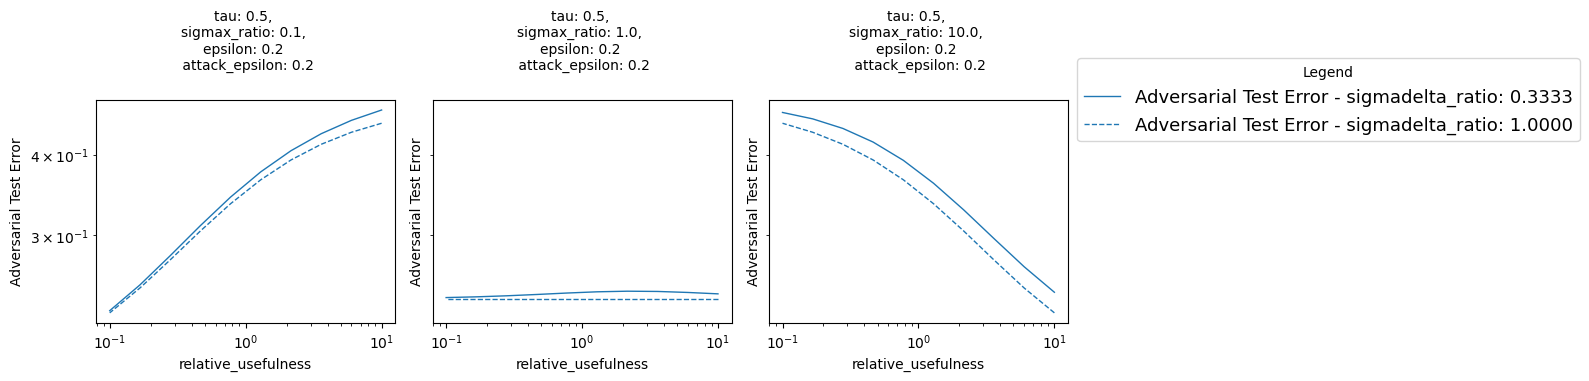

In [ ]:
# create_plot(df, "Adversarial Test Error", "adversarial_generalization_error_state_evolution", "adversarial_generalization_error_erm",log_y=True,log_x=True,plot_attack_epsilon=True)
# create_plot(df, "DataModel Adversarial Test Error", "adversarial_generalization_error_state_evolution", "data_model_adversarial_generalization_error_state_evolution",log_y=True,log_x=True,plot_attack_epsilon=True)

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:67: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:146: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:160: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.errorbar(epsilon_subset[target], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[0], capsize=5)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always b

saving plot


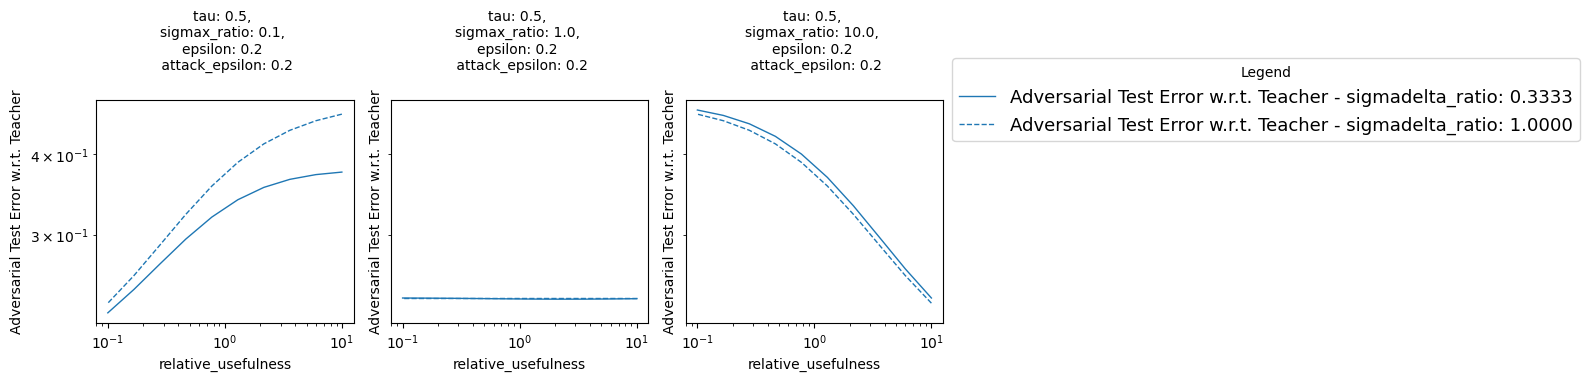

In [ ]:
# create_plot(df, "Adversarial Test Error w.r.t. Teacher", "adversarial_generalization_error_teacher_state_evolution", "adversarial_generalization_error_teacher_erm",log_y=True,log_x=True,plot_attack_epsilon=True)

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:67: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:146: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:160: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.errorbar(epsilon_subset[target], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[0], capsize=5)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always b

saving plot


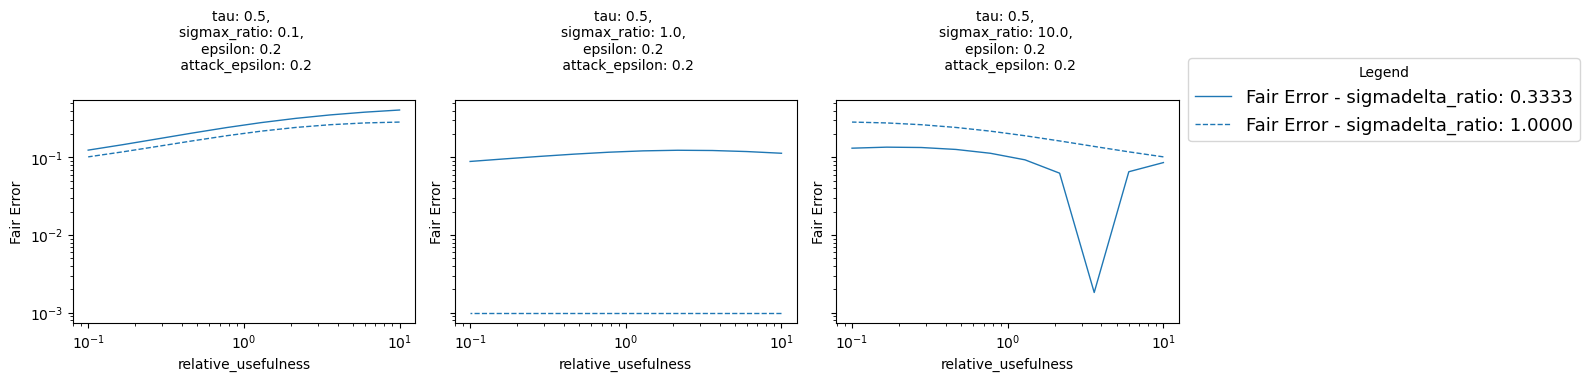

In [ ]:
# plot the fair adversarial error
# create_plot(df, "Fair Error", "fair_adversarial_error_state_evolution","fair_adversarial_error_erm",plot_attack_epsilon=True)

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:67: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:146: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:160: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.errorbar(epsilon_subset[target], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[0], capsize=5)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always b

saving plot


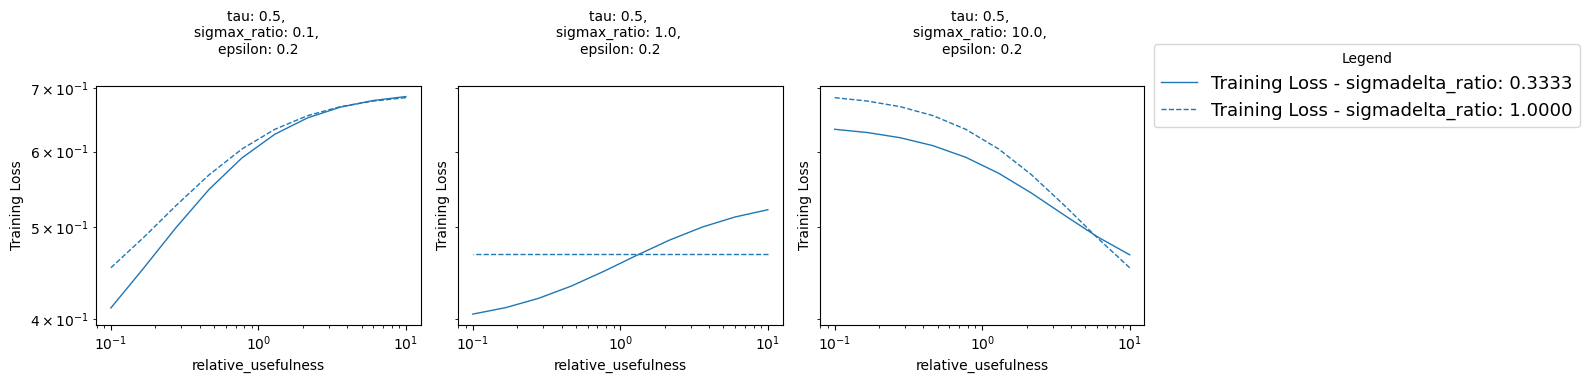

In [ ]:
# create_plot(df, "Training Loss", "training_loss_state_evolution", "training_loss_erm", log_y=True)

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:147: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:154: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(additional_state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{name} - {sweep}: {epsilon:.4f}', color=palette[idx])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:161: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.errorbar(epsilo

saving plot


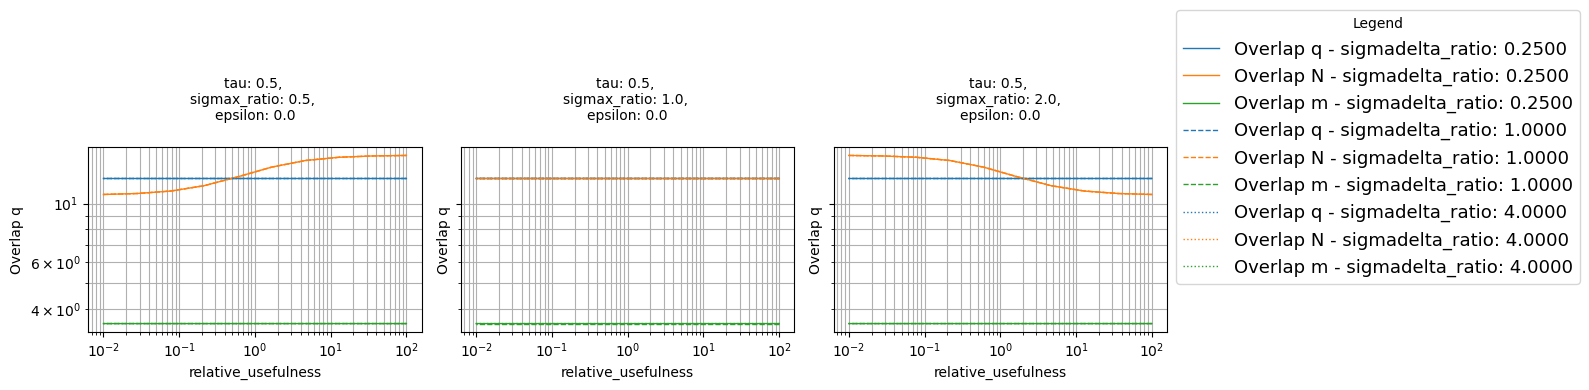

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:147: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:154: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(additional_state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{name} - {sweep}: {epsilon:.4f}', color=palette[idx])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:161: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.errorbar(epsilon_subset[target], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[0], capsize=5)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/i

saving plot


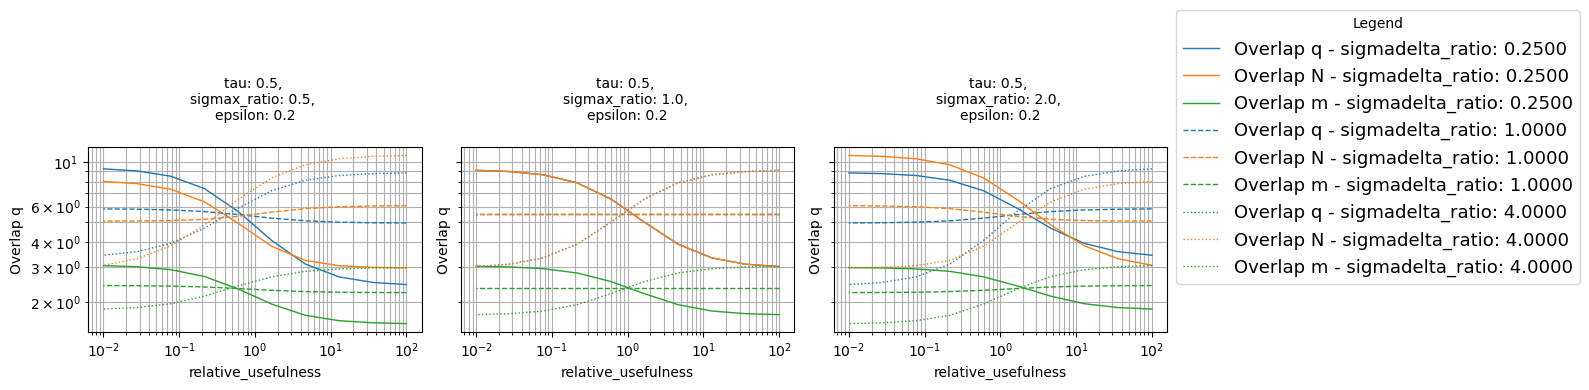

In [ ]:
def compute_angle_direct(row):
    tau =  row["tau"]
    epsilon = row["epsilon"]
    sigmax_ratio = row["sigmax_ratio"]
    theta_ratio = row["theta_ratio"]
    d = 1000
    P_hat = row["P_hat_state_evolution"]["mean"]
    N_hat = row["N_hat_state_evolution"]["mean"]
    V_hat = row["sigma_hat_state_evolution"]["mean"]
    m_hat = row["m_hat_state_evolution"]["mean"]
    m_original = row["m_state_evolution"]["mean"]
    q_original = row["q_state_evolution"]["mean"]
    rho_original = row["rho_state_evolution"]["mean"]

    # convert to float
    tau = float(tau)
    epsilon = float(epsilon)
    sigmax_ratio = float(sigmax_ratio)
    theta_ratio = float(theta_ratio)
    P_hat = float(P_hat)
    N_hat = float(N_hat)
    V_hat = float(V_hat)
    m_hat = float(m_hat)

    # sigmax_ratio = 1 / sigmax_ratio
    # theta_ratio = 1 / theta_ratio

    denom1 = (P_hat + N_hat) * (1 + sigmax_ratio) + 2 * V_hat
    denom2 = (P_hat + N_hat) * (1 + sigmax_ratio) + 2 * V_hat * sigmax_ratio

    nume = 1/denom1 + ( theta_ratio**2 * sigmax_ratio**2 )/denom2
    rho_part = ((2 + 2*sigmax_ratio * theta_ratio**2)  ) 
    denom = np.sqrt( rho_part * ( 1/denom1**2 + ( theta_ratio**2 * sigmax_ratio**3 )/denom2**2 ) )

    # m
    m = m_hat *  4 * nume / ( (1 + sigmax_ratio) * ( 1 + theta_ratio**2 ) )   
    # return m 


    # q
    nume_q = 1/denom1**2 + ( theta_ratio**2 * sigmax_ratio**3 )/denom2**2
    q = 8 * m_hat**2 * ( nume_q )/ ( (1 + sigmax_ratio) * ( 1 + theta_ratio**2 ) )   
    # return q

    # rho
    rho = 2 * ( 1 + sigmax_ratio * theta_ratio**2) / ( (1 + sigmax_ratio ) * (1 + theta_ratio**2) )
    # return rho


    # return m / np.sqrt( rho  * q )

    # assert np.isclose(m, m_original, rtol=1e-3), f"m {m} {m_original}, q {q} {q_original}, rho {rho} {rho_original}, angle {m/np.sqrt(rho * q)} {m_original / np.sqrt( rho_original * q_original )}"
    # assert np.isclose(q, q_original, rtol=1e-3), f"m {m} {m_original}, q {q} {q_original}, rho {rho} {rho_original}, angle {m/np.sqrt(rho * q)} {m_original / np.sqrt( rho_original * q_original )}"
    # assert np.isclose(rho, rho_original, rtol=1e-3), f"m {m} {m_original}, q {q} {q_original}, rho {rho} {rho_original}, angle {m/np.sqrt(rho * q)} {m_original / np.sqrt( rho_original * q_original )}"

    angle = m / np.sqrt( rho  * q )
    original_angle = m_original / np.sqrt( rho_original  * q_original )

    # assert np.isclose(angle, original_angle, rtol=1e-1), f"m {m} {m_original}, q {q} {q_original}, rho {rho} {rho_original}, angle {m/np.sqrt(rho * q)} {m_original / np.sqrt( rho_original * q_original )}"

    # return angle


    return np.sqrt(2)*nume/denom

    

# create a copy of the dataframe
df2 = df.reset_index()

df2["angle_direct"] = df2.apply(lambda x: compute_angle_direct(x), axis=1)

# apply mean and std to the new column
df_result = df2["angle_direct"].apply(lambda x: pd.Series({"mean":x, "std":0}))
multiindex = pd.MultiIndex.from_product([['angle_direct'], ['mean', 'std']], names=['', ''])
df_result.columns = multiindex
# Concatenate the original DataFrame with the computed values DataFrame
df2 = pd.concat([df2, df_result], axis=1)


# set all quantities from the df index in df2 as index
df2 = df2.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","sigmax_ratio","sigmadelta_ratio","theta_ratio","data_model_name"]) #,"p_calibration"

# sort index
df2.sort_index()
df2[["angle_direct"]]

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/2956594114.py:69: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/2956594114.py:16: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  tau = float(tau)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/2956594114.py:17: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  epsilon = float(epsilon)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/2956594114.py:18: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigmax_ratio = float(sigmax_ratio)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_

angle_direct  \
                                                                                                                                                                   
alpha    epsilon tau lam   problem_type attack_epsilon sigmax_ratio sigmadelta_ratio theta_ratio data_model_name                                                   
100000.0 0.2     0.5 0.001 Logistic     0.2            0.1          0.333333         0.100000    KFeaturesModel_TwoFeatures_ProtectingFirstStron...     0.999651   
                                                                                                 KFeaturesModel_TwoFeatures_ProtectingSecondStro...     0.999651   
                                                                                     0.129155    KFeaturesModel_TwoFeatures_ProtectingFirstStron...     0.999446   
                                                                                                 KFeaturesModel_TwoFeatures_ProtectingSecondStro...     0.999446   
                                                                                     0.166810    KFeaturesModel_TwoFeatures_ProtectingFirstStron...     0.999133   
...                                                                                                                                                          ...   
                                                       10.0         1.000000         3.593814    KFeaturesModel_TwoFeatures_ProtectingIdentity_A...     0.998501   
                                                                                     4.641589    KFeaturesModel_TwoFeatures_ProtectingIdentity_A...     0.999004   
                                                                                     5.994842    KFeaturesModel_TwoFeatures_ProtectingIdentity_A...     0.999349   
                                                                                     7.742637    KFeaturesModel_TwoFeatures_ProtectingIdentity_A...     0.999580   
                                                                                     10.000000   KFeaturesModel_TwoFeatures_ProtectingIdentity_A...     0.999733   

                                                                                                                                                               \
                                                                                                                                                         mean   
alpha    epsilon tau lam   problem_type attack_epsilon sigmax_ratio sigmadelta_ratio theta_ratio data_model_name                                                
100000.0 0.2     0.5 0.001 Logistic     0.2            0.1          0.333333         0.100000    KFeaturesModel_TwoFeatures_ProtectingFirstStron...  0.999651   
                                                                                                 KFeaturesModel_TwoFeatures_ProtectingSecondStro...  0.999651   
                                                                                     0.129155    KFeaturesModel_TwoFeatures_ProtectingFirstStron...  0.999446   
                                                                                                 KFeaturesModel_TwoFeatures_ProtectingSecondStro...  0.999446   
                                                                                     0.166810    KFeaturesModel_TwoFeatures_ProtectingFirstStron...  0.999133   
...                                                                                                                                                       ...   
                                                       10.0         1.000000         3.593814    KFeaturesModel_TwoFeatures_ProtectingIdentity_A...  0.998501   
                                                                                     4.641589    KFeaturesModel_TwoFeatures_ProtectingIdentity_A...  0.999004   
                                                                                

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:67: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:146: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:160: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.errorbar(epsilon_subset[target], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[0], capsize=5)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always b

saving plot


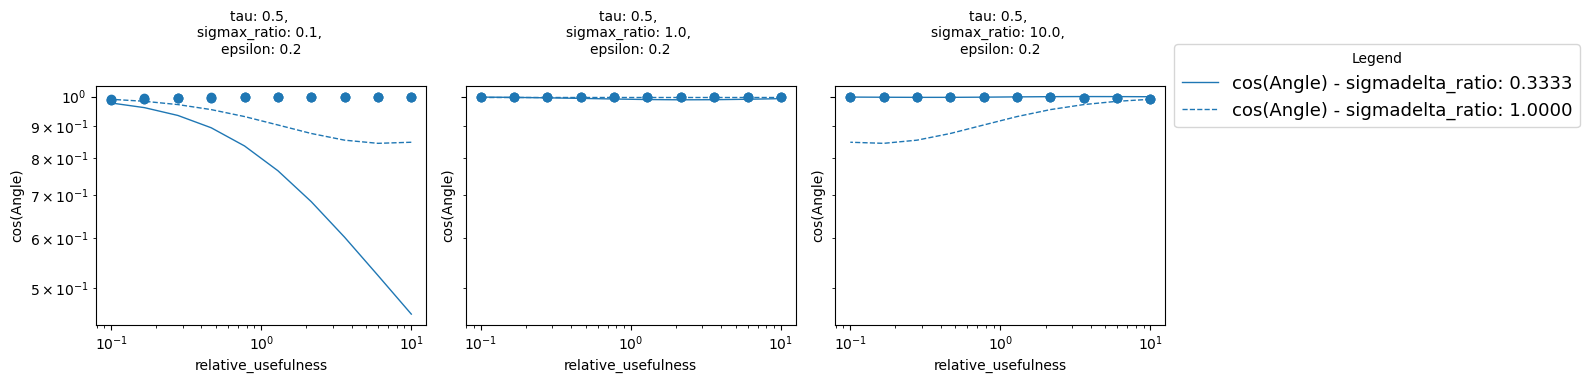

In [ ]:
create_plot(df2, "cos(Angle)", "angle_state_evolution","angle_direct", log_y=True)
# create_plot(df2, "datamodel Angle", "angle_state_evolution","data_model_angle_state_evolution", log_y=True)
# create_plot(df2, "Direct cos(Angle)", "data_model_angle_state_evolution","angle_direct", log_y=True)

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:147: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:161: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.errorbar(epsilon_subset[target], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[0], capsize=5)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:184: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always b

saving plot


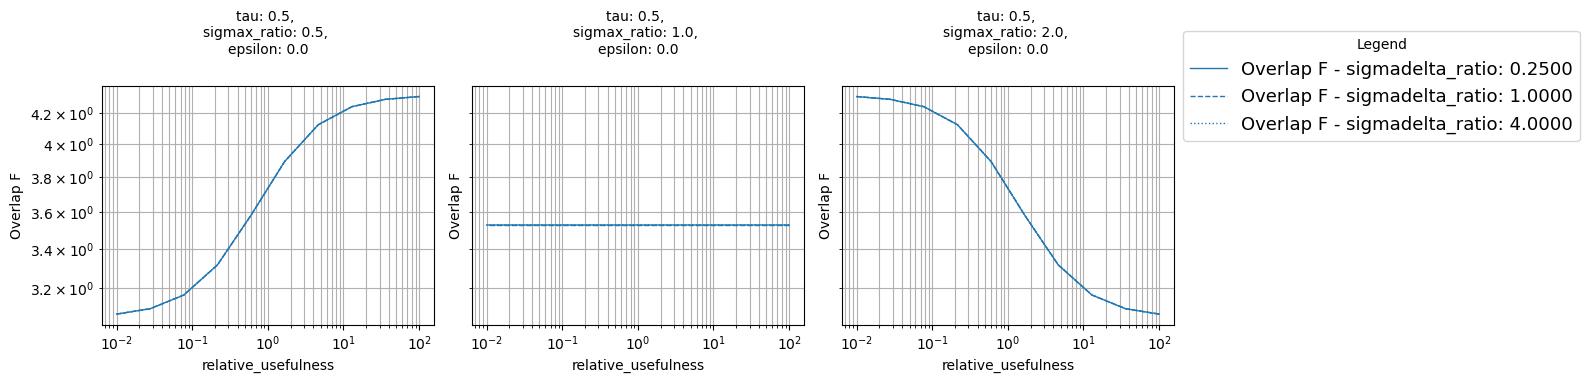

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:147: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:161: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.errorbar(epsilon_subset[target], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[0], capsize=5)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:184: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  delta_scale_value = float(epsilon_subset["sigmadelta_scale_state_evol

saving plot


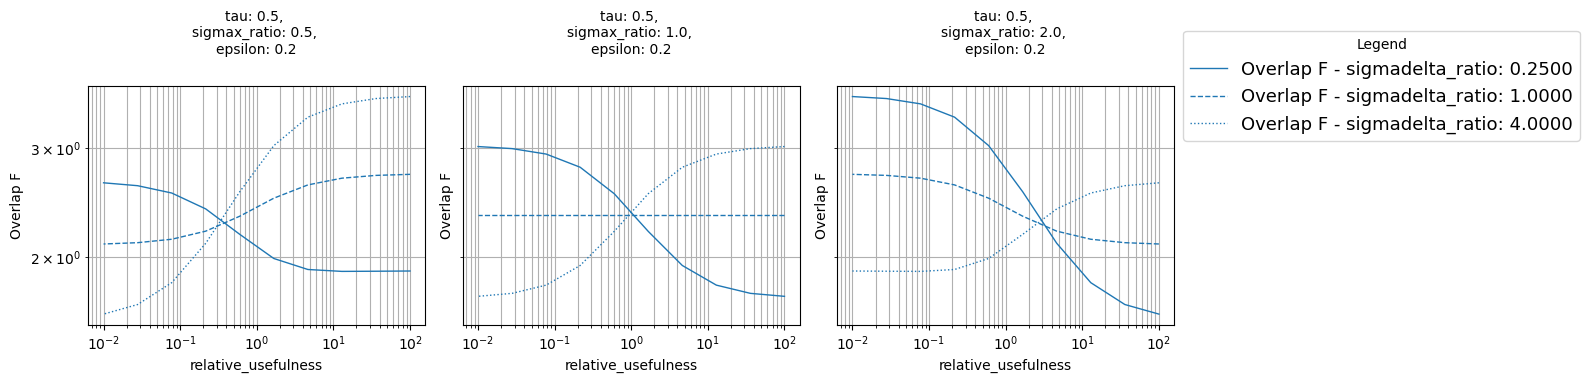

In [ ]:
# Plot the F overlap
create_plot(df, "Overlap F", "F_state_evolution","F_erm", log_y=True)

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:147: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:161: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.errorbar(epsilon_subset[target], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[0], capsize=5)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:184: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always b

saving plot


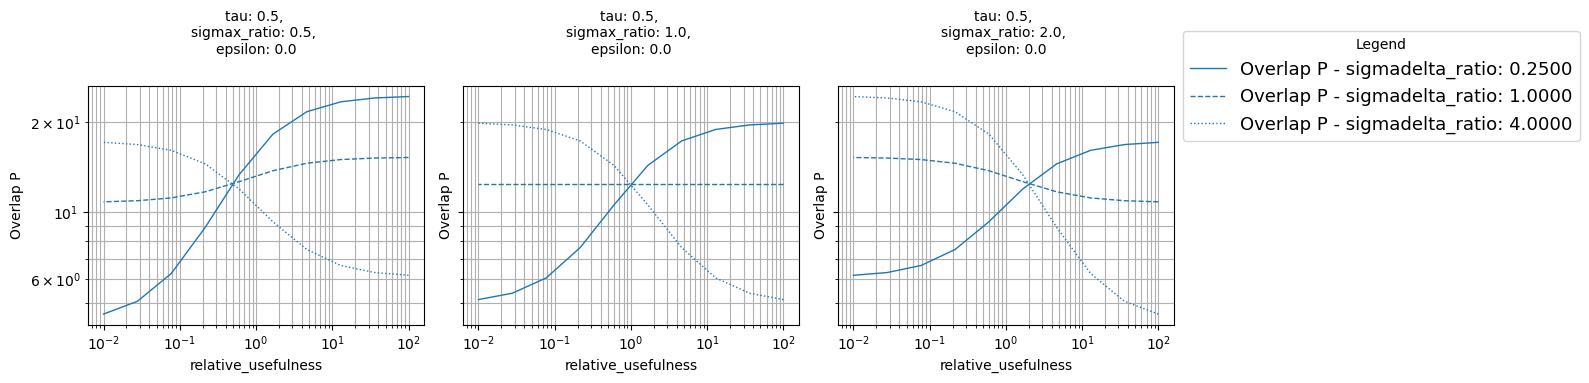

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:147: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:161: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.errorbar(epsilon_subset[target], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[0], capsize=5)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:184: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  delta_scale_value = float(epsilon_subset["sigmadelta_scale_state_evol

saving plot


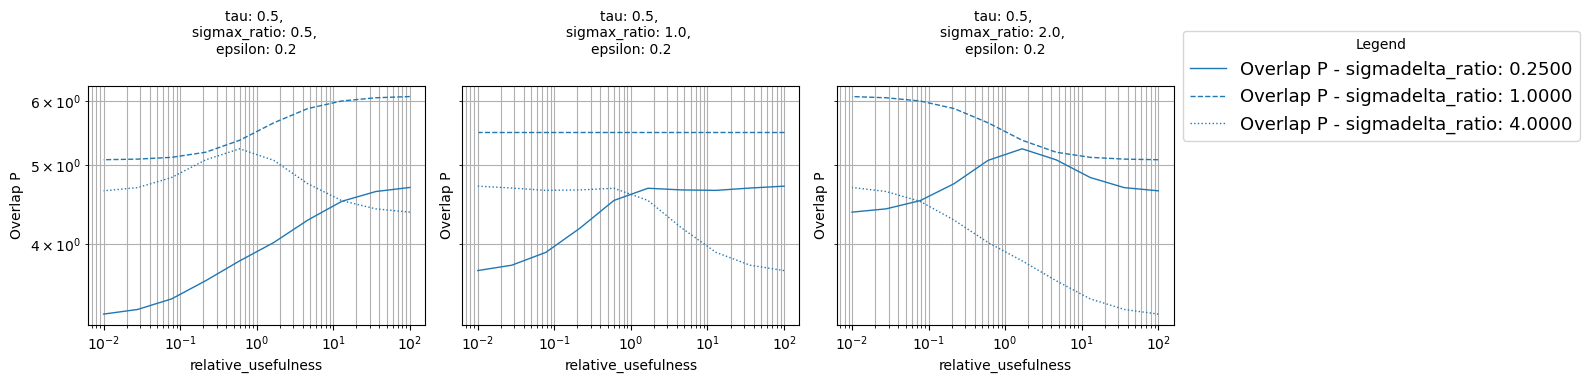

In [ ]:
# Plot the P overlap
create_plot(df, "Overlap P", "P_state_evolution","P_erm", log_y=True)

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:147: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:161: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.errorbar(epsilon_subset[target], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[0], capsize=5)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:184: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always b

saving plot


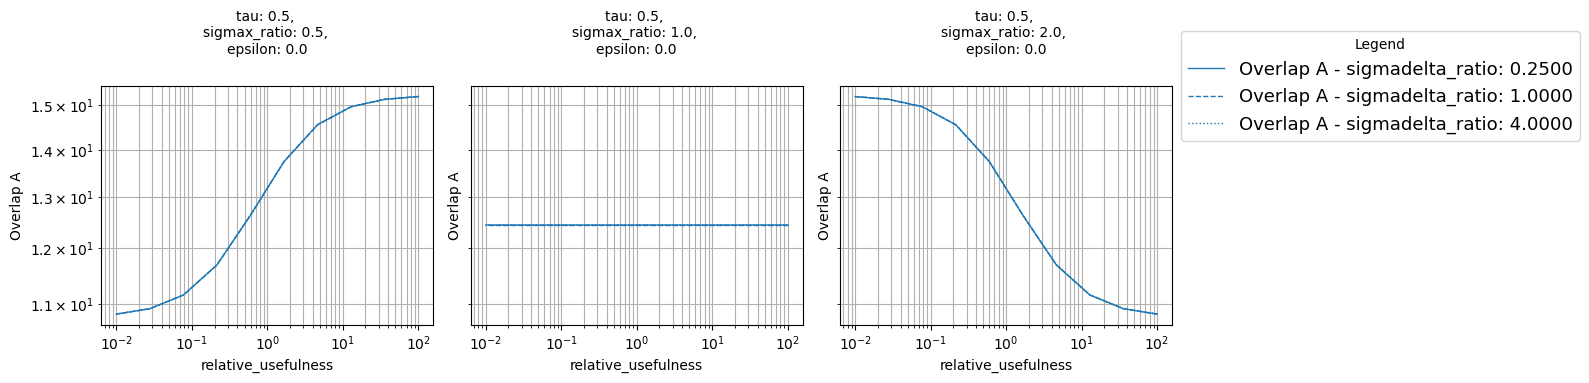

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:147: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:161: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.errorbar(epsilon_subset[target], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[0], capsize=5)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1059777876.py:184: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  delta_scale_value = float(epsilon_subset["sigmadelta_scale_state_evol

saving plot


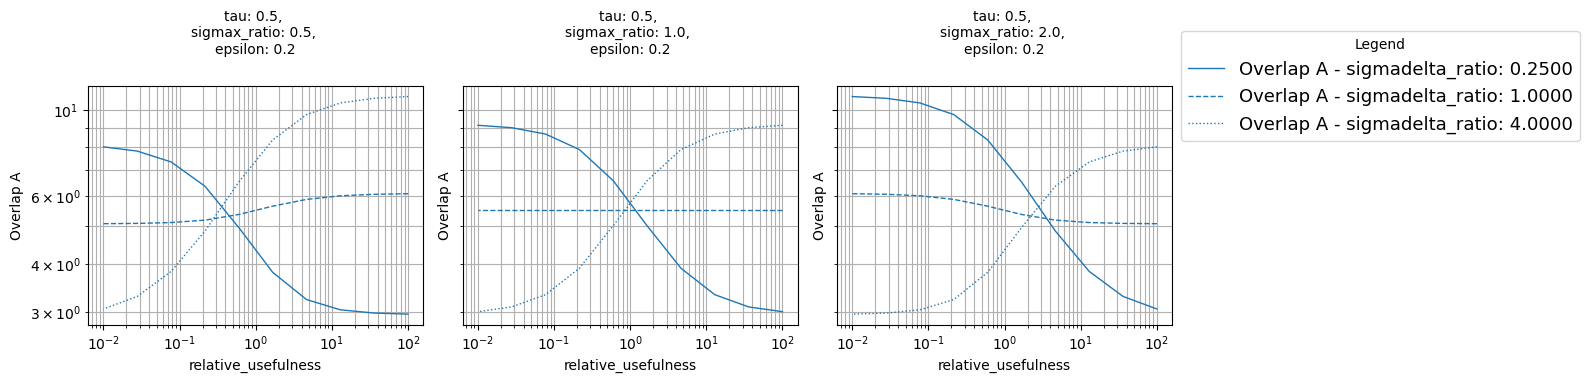

In [ ]:
# Plot the A overlap
create_plot(df, "Overlap A", "A_state_evolution","A_erm", log_y=True)

In [ ]:
# # subset df to keep only where p = 0.5
# p = 0.6
# dfp = df[df.index.get_level_values("p_calibration") == p]
# # remove epsilon = 1
# # dfp = dfp[dfp.index.get_level_values("epsilon") != 1]

# create_plot(dfp, f"Calibration p: {p}", "calibration_state_evolution","erm_calibration_erm",log_y=False)
# # erm_calibration_erm	analytical_calibration_erm	calibration_state_evolution

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:67: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:146: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:160: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.errorbar(epsilon_subset[target], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[0], capsize=5)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always b

saving plot


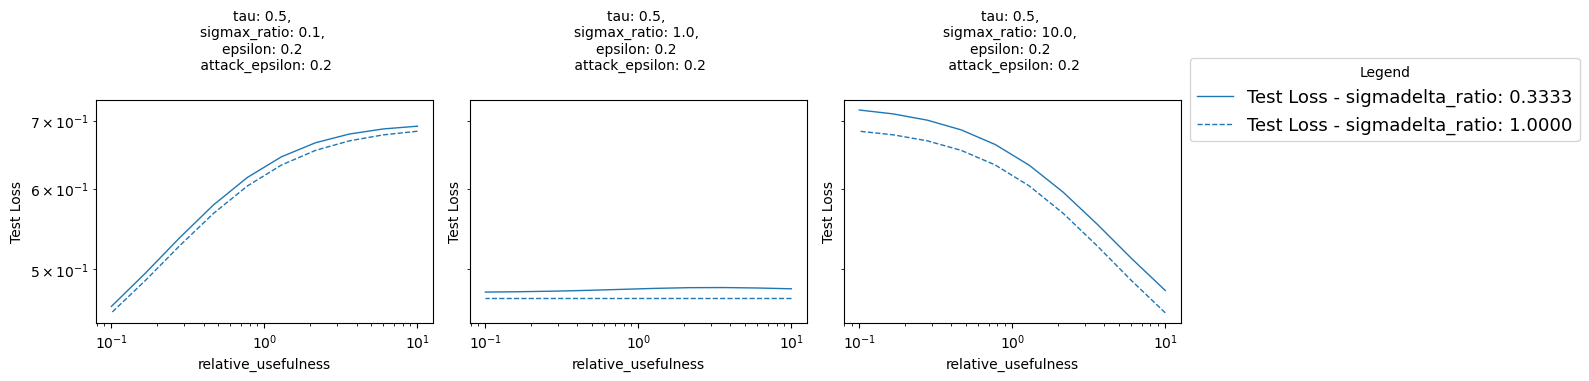

In [ ]:
# plot test loss erm
create_plot(df, "Test Loss", "test_loss_state_evolution","test_loss_erm",log_y=True,plot_attack_epsilon=True)

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:67: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:146: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  delta_scale_value = float(epsilon_subset["sigmadelta_scale_state_evolution"].mean()[0])


saving plot


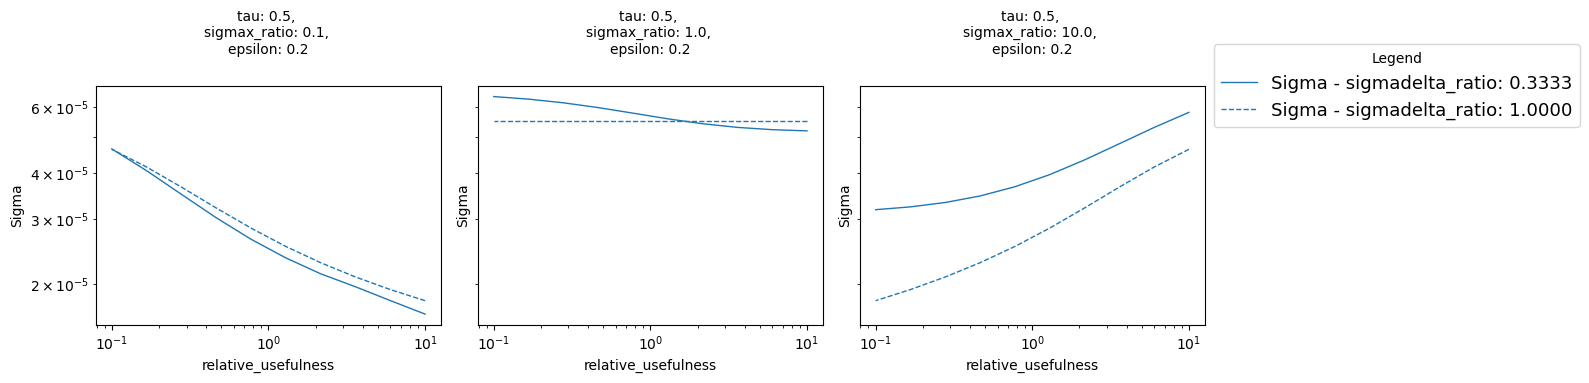

In [ ]:
# Plot sigma for the state evolution
create_plot(df, "Sigma", "sigma_state_evolution", None)

In [ ]:
df.index

MultiIndex([(100000.0, 0.2, 0.5, 0.001, 'Logistic', 0.2,  0.1, ...),
            (100000.0, 0.2, 0.5, 0.001, 'Logistic', 0.2,  0.1, ...),
            (100000.0, 0.2, 0.5, 0.001, 'Logistic', 0.2,  0.1, ...),
            (100000.0, 0.2, 0.5, 0.001, 'Logistic', 0.2,  0.1, ...),
            (100000.0, 0.2, 0.5, 0.001, 'Logistic', 0.2,  0.1, ...),
            (100000.0, 0.2, 0.5, 0.001, 'Logistic', 0.2,  0.1, ...),
            (100000.0, 0.2, 0.5, 0.001, 'Logistic', 0.2,  0.1, ...),
            (100000.0, 0.2, 0.5, 0.001, 'Logistic', 0.2,  0.1, ...),
            (100000.0, 0.2, 0.5, 0.001, 'Logistic', 0.2,  0.1, ...),
            (100000.0, 0.2, 0.5, 0.001, 'Logistic', 0.2,  0.1, ...),
            (100000.0, 0.2, 0.5, 0.001, 'Logistic', 0.2,  0.1, ...),
            (100000.0, 0.2, 0.5, 0.001, 'Logistic', 0.2,  0.1, ...),
            (100000.0, 0.2, 0.5, 0.001, 'Logistic', 0.2,  0.1, ...),
            (100000.0, 0.2, 0.5, 0.001, 'Logistic', 0.2,  0.1, ...),
            (100000.0, 0.2, 0.5, 0

In [ ]:
from scipy.special import erfc
from scipy.integrate import quad

def compute_integrated_sigma_hat(row):
    m = row["m_state_evolution"]["mean"]
    q = row["q_state_evolution"]["mean"]
    rho = row["rho_state_evolution"]["mean"]
    alpha = row["alpha"]
    epsilon = row["epsilon"]
    tau = row["tau"]
    P = row["P_state_evolution"]["mean"]
    N = row["N_state_evolution"]["mean"]

    # convert all values to float
    m = float(m)
    q = float(q)
    rho = float(rho)
    alpha = float(alpha)
    epsilon = float(epsilon)
    tau = float(tau)
    P = float(P)
    N = float(N)

    def integrand(xi,y):
        z_0 = erfc(  ( (-y * m) / np.sqrt(q) * xi) / np.sqrt(2*(tau**2 + (rho - m**2/q))))

        derivative_f_out = 1 / ( 4 * np.cosh( ( y*np.sqrt(q)*xi - epsilon*P/np.sqrt(N) ) /2 )**2 )

        return z_0 * ( derivative_f_out ) * gaussian(xi,0,1)

    Iplus = quad(lambda xi: integrand(xi,1) , -20, 20, limit=500)[0]
    Iminus = quad(lambda xi: integrand(xi,-1) , -20, 20, limit=500)[0]

    return  0.5 * alpha * (Iplus + Iminus)

def compute_simplified_sigma_hat(row):
    m = row["m_state_evolution"]["mean"]
    q = row["q_state_evolution"]["mean"]
    rho = row["rho_state_evolution"]["mean"]
    alpha = row["alpha"]
    epsilon = row["epsilon"]
    tau = row["tau"]
    P = row["P_state_evolution"]["mean"]
    N = row["N_state_evolution"]["mean"]

    # convert all values to float
    m = float(m)
    q = float(q)
    rho = float(rho)
    alpha = float(alpha)
    epsilon = float(epsilon)
    tau = float(tau)
    P = float(P)
    N = float(N)

    def integrand(xi,y):
        z_0 = erfc(  ( (-y * m) / np.sqrt(q) * xi) / np.sqrt(2*(tau**2 + (rho - m**2/q))))

        x = ( y*np.sqrt(q)*xi - epsilon*P/np.sqrt(N) ) /2

        derivative_f_out = 1/4 - 0.25 * x**2 # + x**4 / 6 - 17/180 * x**6

        return z_0 * ( derivative_f_out ) * gaussian(xi,0,1)

    Iplus = quad(lambda xi: integrand(xi,1) , -20, 20, limit=500)[0]
    Iminus = quad(lambda xi: integrand(xi,-1) , -20, 20, limit=500)[0]

    return  alpha * (Iplus + Iminus) / 32



def compute_direct_sigma_hat(row):
    tau =  row["tau"]
    # convert to float
    tau = float(tau)
    return row["alpha"]/16 *( -row["q_state_evolution"]["mean"] + 2 * 1.12838 * row["m_state_evolution"]["mean"] * row["P_state_evolution"]["mean"] * row["epsilon"] / (np.sqrt( 2 * row["N_state_evolution"]["mean"] * row["rho_state_evolution"]["mean"] + 2 * tau**2 )) - row["epsilon"] * row["P_state_evolution"]["mean"]**2 /row["N_state_evolution"]["mean"] + 1 )

# create a copy of the dataframe
df2 = df.reset_index()

df2["sigma_hat_direct"] = df2.apply(compute_direct_sigma_hat, axis=1)
df2["sigma_hat_integrated"] = df2.apply(compute_integrated_sigma_hat, axis=1)
df2["sigma_hat_simplified"] = df2.apply(compute_simplified_sigma_hat, axis=1)

# apply mean and std to the new column
df_result = df2["sigma_hat_direct"].apply(lambda x: pd.Series({"mean":x, "std":0}))
multiindex = pd.MultiIndex.from_product([['sigma_hat_direct'], ['mean', 'std']], names=['', ''])
df_result.columns = multiindex
# Concatenate the original DataFrame with the computed values DataFrame
df2 = pd.concat([df2, df_result], axis=1)

# apply mean and std to the new column
df_result = df2["sigma_hat_integrated"].apply(lambda x: pd.Series({"mean":x, "std":0}))
multiindex = pd.MultiIndex.from_product([['sigma_hat_integrated'], ['mean', 'std']], names=['', ''])
df_result.columns = multiindex
# Concatenate the original DataFrame with the computed values DataFrame
df2 = pd.concat([df2, df_result], axis=1)

# apply mean and std to the new column
df_result = df2["sigma_hat_simplified"].apply(lambda x: pd.Series({"mean":x, "std":0}))
multiindex = pd.MultiIndex.from_product([['sigma_hat_simplified'], ['mean', 'std']], names=['', ''])
df_result.columns = multiindex
# Concatenate the original DataFrame with the computed values DataFrame
df2 = pd.concat([df2, df_result], axis=1)

# set all quantities from the df index in df2 as index
df2 = df2.set_index(["alpha","epsilon","tau","lam","problem_type","attack_epsilon","sigmax_ratio","sigmadelta_ratio","theta_ratio","data_model_name"]) #,"p_calibration"

# sort index
df2.sort_index()
df2[["sigma_hat_direct","sigma_hat_integrated","sigma_hat_simplified"]]


/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/733150166.py:79: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/733150166.py:75: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  tau = float(tau)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/733150166.py:18: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  alpha = float(alpha)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/733150166.py:19: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  epsilon = float(epsilon)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/733150166.py

sigma_hat_direct  \
                                                                                                                                                                       
alpha    epsilon tau lam   problem_type attack_epsilon sigmax_ratio sigmadelta_ratio theta_ratio data_model_name                                                       
100000.0 0.2     0.5 0.001 Logistic     0.2            0.1          0.333333         0.100000    KFeaturesModel_TwoFeatures_ProtectingFirstStron...      5804.674553   
                                                                                                 KFeaturesModel_TwoFeatures_ProtectingSecondStro...      5804.674553   
                                                                                     0.129155    KFeaturesModel_TwoFeatures_ProtectingFirstStron...      5420.603632   
                                                                                                 KFeaturesModel_TwoFeatures_ProtectingSecondStro...      5420.603632   
                                                                                     0.166810    KFeaturesModel_TwoFeatures_ProtectingFirstStron...      4756.464546   
...                                                                                                                                                              ...   
                                                       10.0         1.000000         3.593814    KFeaturesModel_TwoFeatures_ProtectingIdentity_A...      1663.964024   
                                                                                     4.641589    KFeaturesModel_TwoFeatures_ProtectingIdentity_A...      3328.568590   
                                                                                     5.994842    KFeaturesModel_TwoFeatures_ProtectingIdentity_A...      4374.382636   
                                                                                     7.742637    KFeaturesModel_TwoFeatures_ProtectingIdentity_A...      5022.925098   
                                                                                     10.000000   KFeaturesModel_TwoFeatures_ProtectingIdentity_A...      5421.546540   

                                                                                                                                                                  \
                                                                                                                                                            mean   
alpha    epsilon tau lam   problem_type attack_epsilon sigmax_ratio sigmadelta_ratio theta_ratio data_model_name                                                   
100000.0 0.2     0.5 0.001 Logistic     0.2            0.1          0.333333         0.100000    KFeaturesModel_TwoFeatures_ProtectingFirstStron...  5804.674553   
                                                                                                 KFeaturesModel_TwoFeatures_ProtectingSecondStro...  5804.674553   
                                                                                     0.129155    KFeaturesModel_TwoFeatures_ProtectingFirstStron...  5420.603632   
                                                                                                 KFeaturesModel_TwoFeatures_ProtectingSecondStro...  5420.603632   
                                                                                     0.166810    KFeaturesModel_TwoFeatures_ProtectingFirstStron...  4756.464546   
...                                                                                                                                                          ...   
                                                       10.0         1.000000         3.593814    KFeaturesModel_TwoFeatures_ProtectingIdentity_A...  1663.964024   
                                                                                     4.641589    KFeaturesModel_TwoFeatures_ProtectingIdentity_A...  3328.5

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:67: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:146: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:160: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.errorbar(epsilon_subset[target], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[0], capsize=5)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always b

saving plot


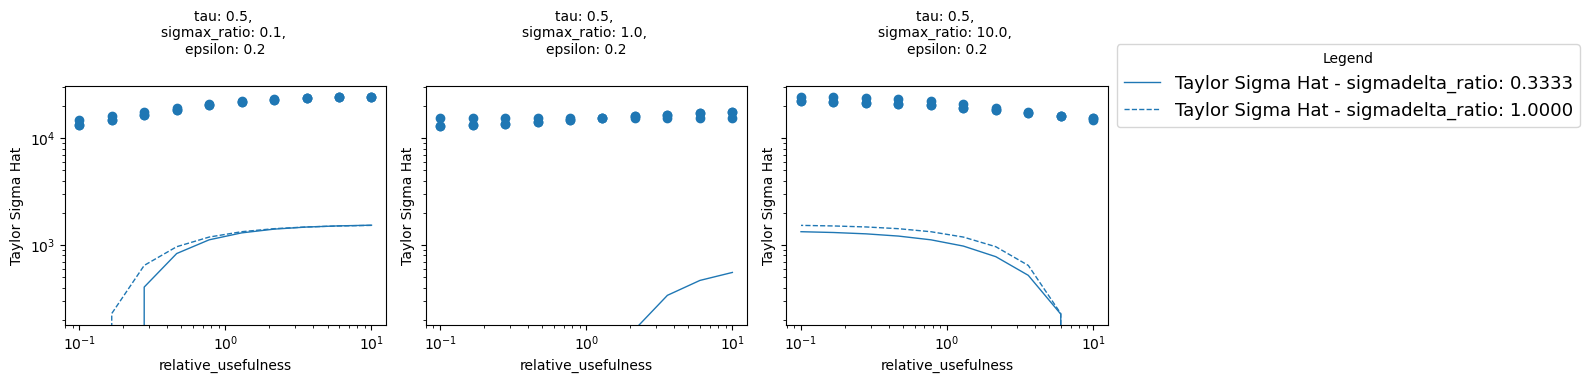

In [ ]:
create_plot(df2, "Taylor Sigma Hat", "sigma_hat_simplified", "sigma_hat_state_evolution")

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:67: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:146: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:160: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.errorbar(epsilon_subset[target], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[0], capsize=5)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always b

saving plot


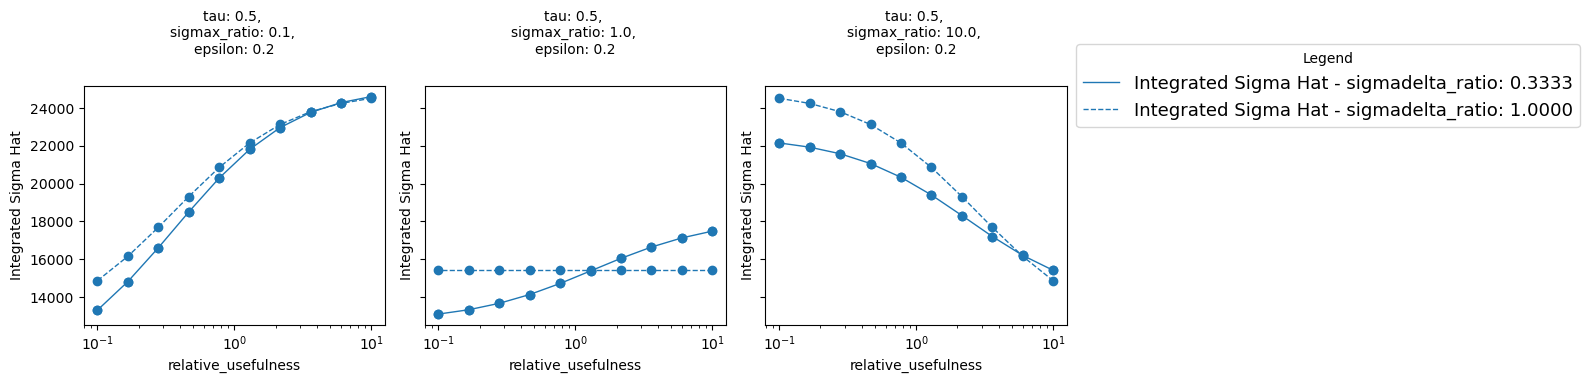

In [ ]:
create_plot(df2, "Integrated Sigma Hat", "sigma_hat_integrated", "sigma_hat_state_evolution", log_y=False)

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:67: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:146: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:160: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.errorbar(epsilon_subset[target], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[0], capsize=5)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always b

saving plot


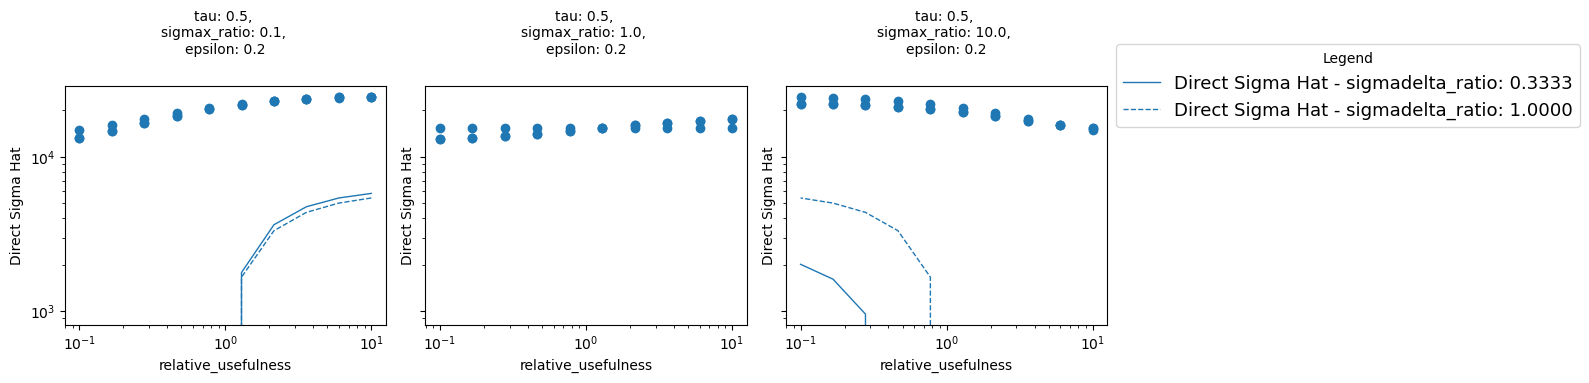

In [ ]:
create_plot(df2, "Direct Sigma Hat", "sigma_hat_direct", "sigma_hat_state_evolution")

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:67: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:146: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  delta_scale_value = float(epsilon_subset["sigmadelta_scale_state_evolution"].mean()[0])


saving plot


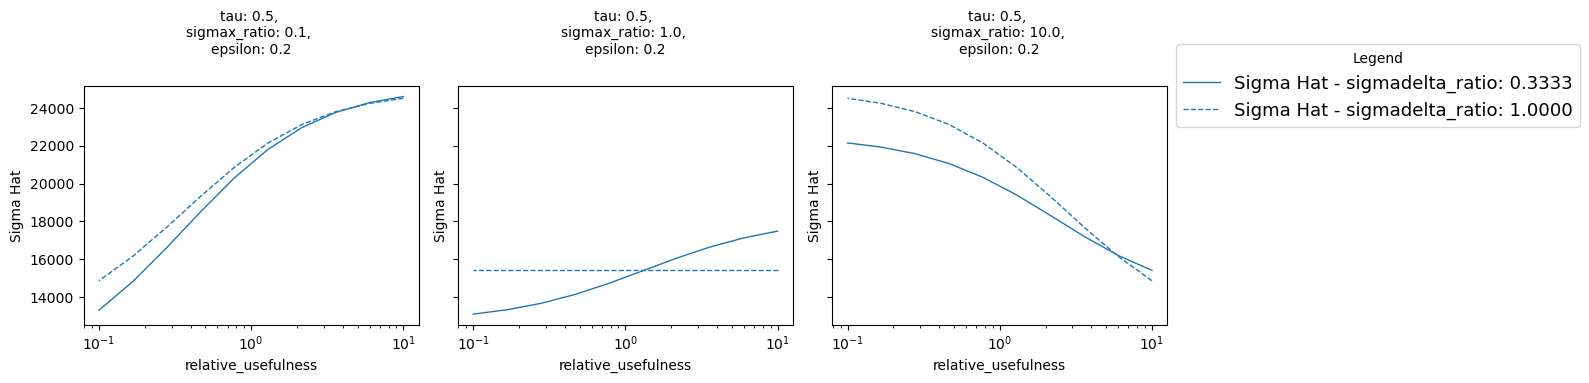

In [ ]:
# Plot sigma_hat for the state evolution
create_plot(df, "Sigma Hat", "sigma_hat_state_evolution", None, log_y=False)

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:67: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:146: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  delta_scale_value = float(epsilon_subset["sigmadelta_scale_state_evolution"].mean()[0])


saving plot


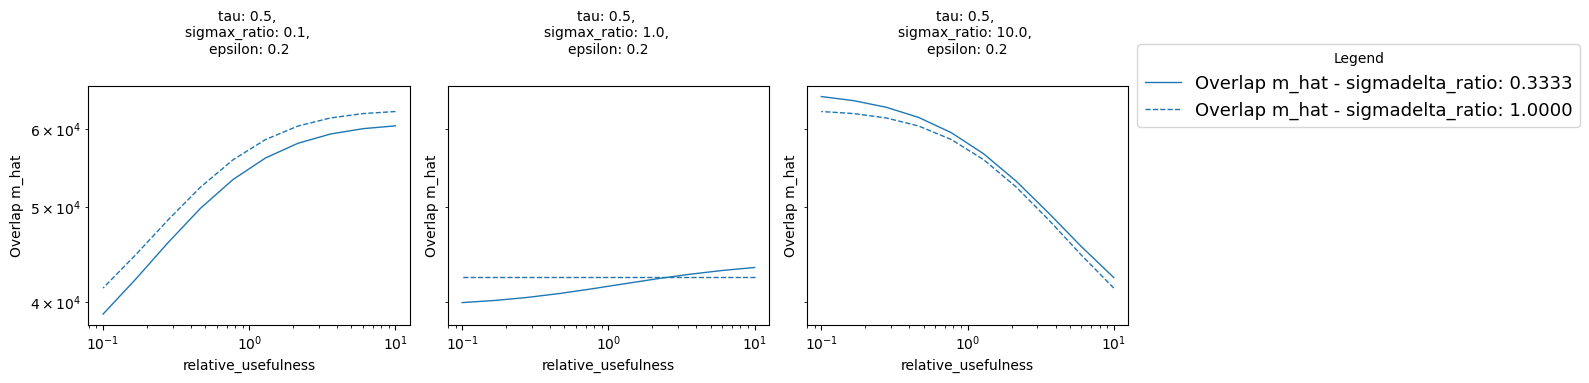

In [ ]:
# Plot m_hat for the state evolution
create_plot(df, "Overlap m_hat", "m_hat_state_evolution", None)

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:67: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:146: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  delta_scale_value = float(epsilon_subset["sigmadelta_scale_state_evolution"].mean()[0])


saving plot


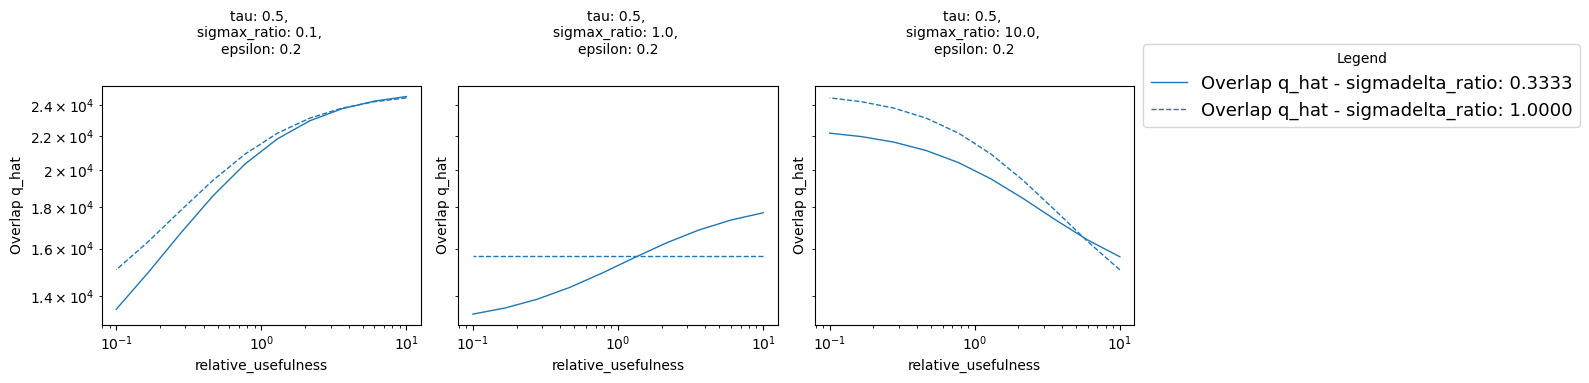

In [ ]:
# Plot q_hat for the state_evolution
create_plot(df, "Overlap q_hat", "q_hat_state_evolution", None)

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:67: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:146: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  delta_scale_value = float(epsilon_subset["sigmadelta_scale_state_evolution"].mean()[0])


saving plot


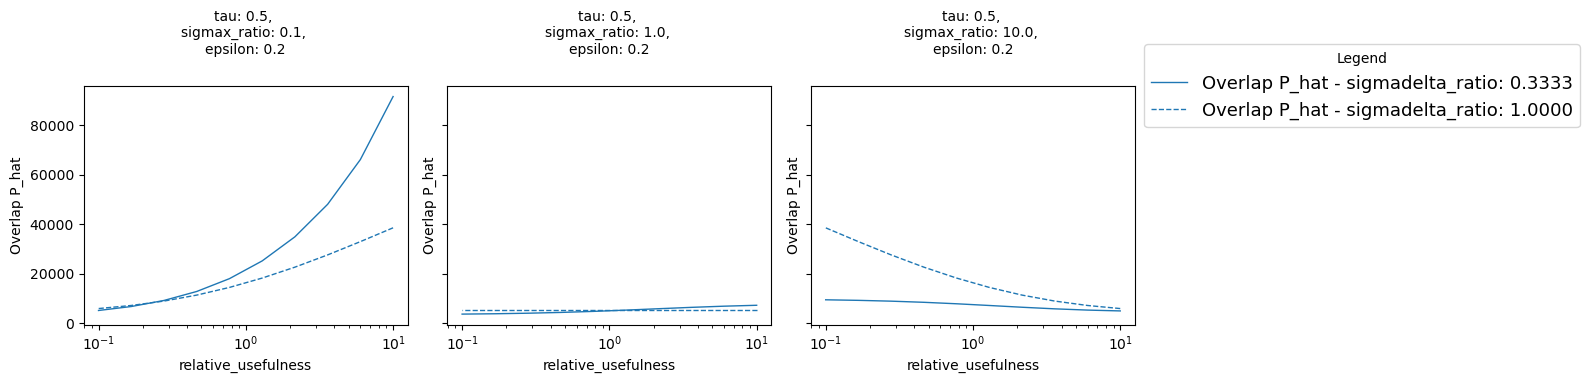

In [ ]:
create_plot(df, "Overlap P_hat", "P_hat_state_evolution", None, log_y=False)

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:67: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:146: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  delta_scale_value = float(epsilon_subset["sigmadelta_scale_state_evolution"].mean()[0])


saving plot


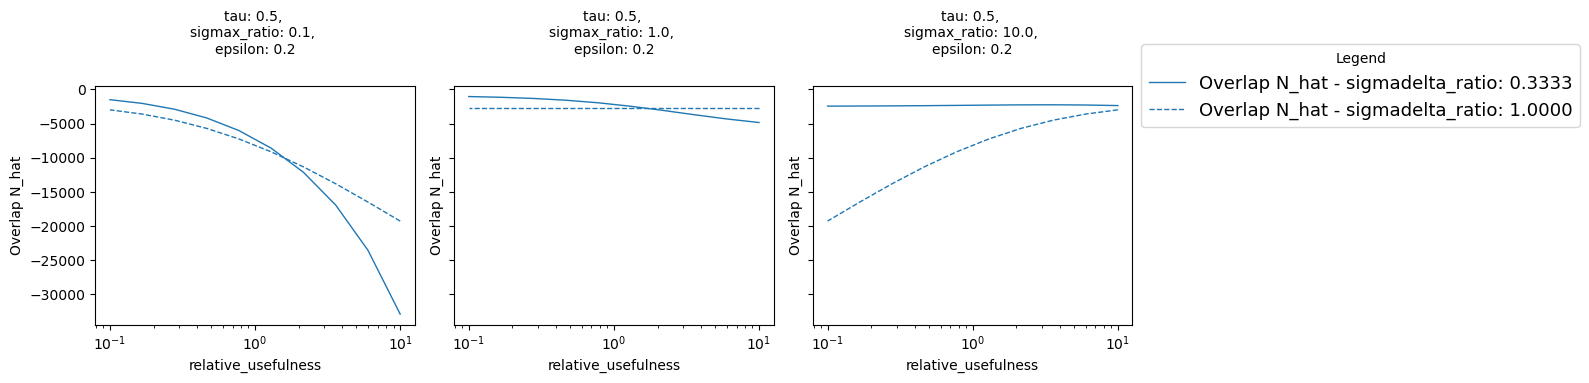

In [ ]:
create_plot(df, "Overlap N_hat", "N_hat_state_evolution", None,log_y=False)

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:67: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:146: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:160: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.errorbar(epsilon_subset[target], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[0], capsize=5)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always b

saving plot


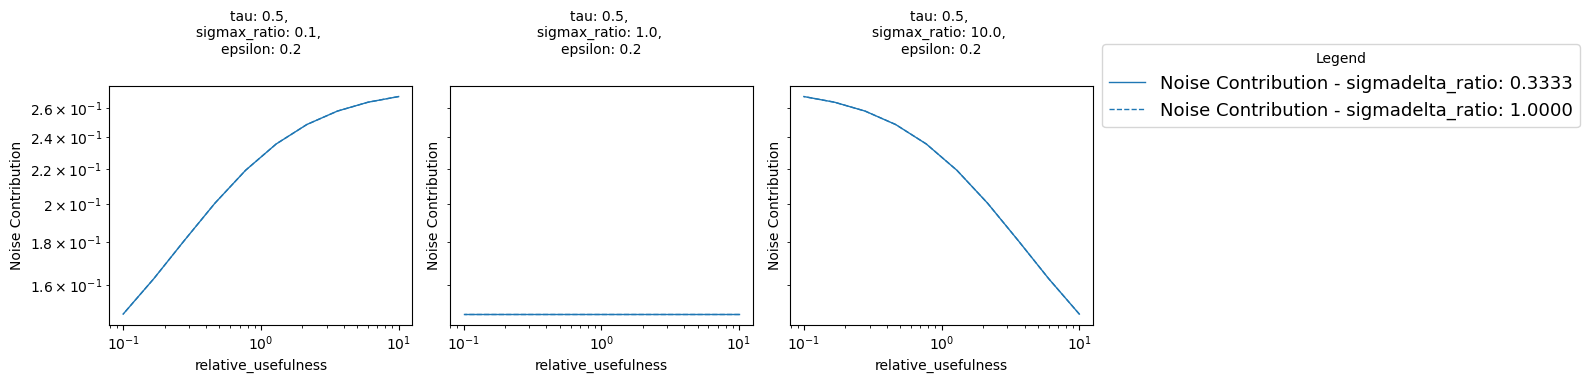

In [ ]:
create_plot(df, "Noise Contribution", "noise_contribution_state_evolution","noise_contribution_erm")

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:67: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:146: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:160: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.errorbar(epsilon_subset[target], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[0], capsize=5)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always b

saving plot


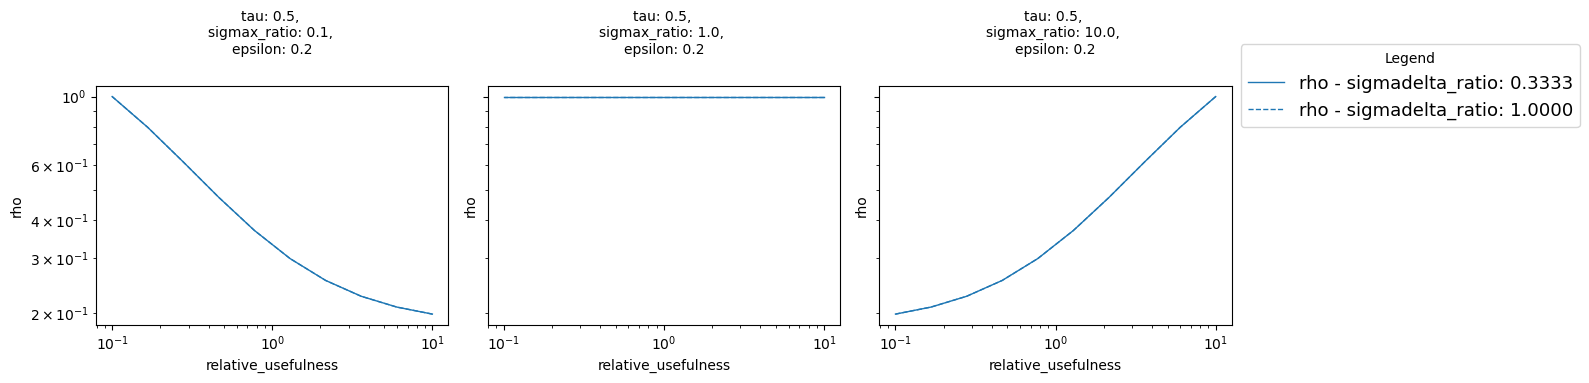

In [ ]:
create_plot(df, "rho", "rho_state_evolution","rho_erm")

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:67: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:146: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:160: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.errorbar(epsilon_subset[target], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[0], capsize=5)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always b

saving plot


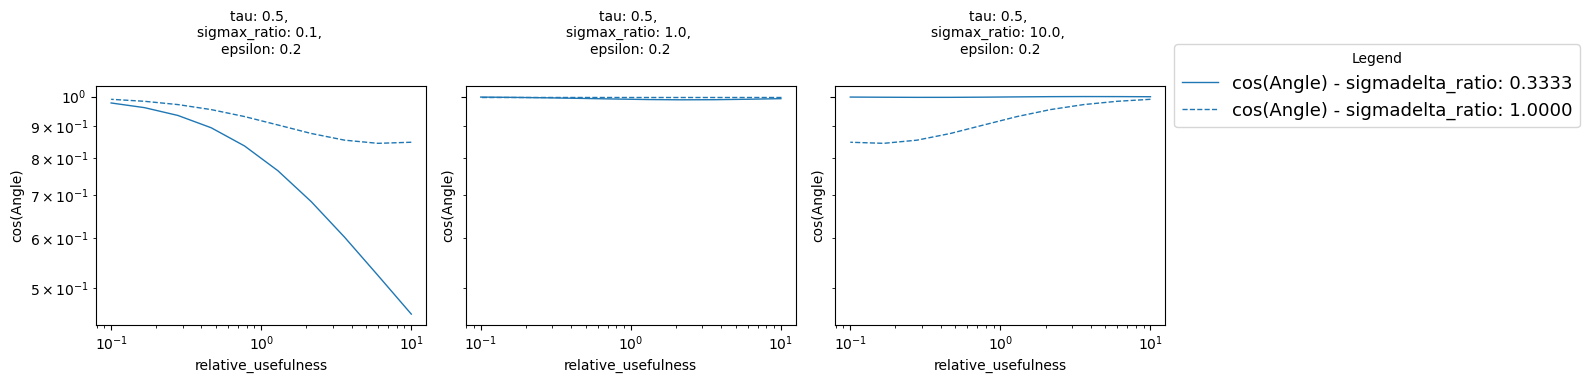

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:67: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:146: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:160: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.errorbar(epsilon_subset[target], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[0], capsize=5)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always b

saving plot


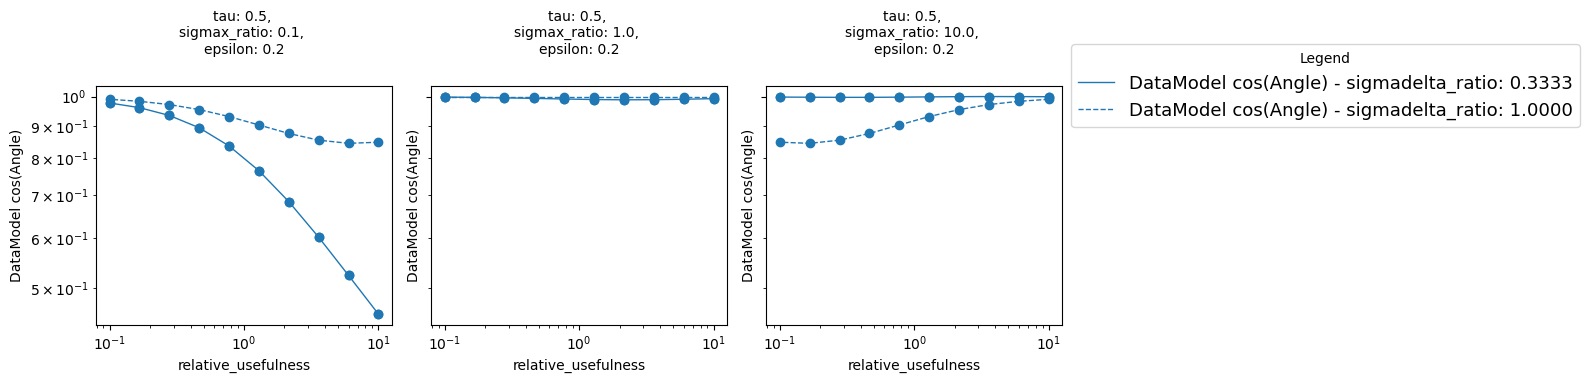

In [ ]:
create_plot(df, "cos(Angle)", "angle_state_evolution","angle_erm")
create_plot(df, "DataModel cos(Angle)", "data_model_angle_state_evolution","angle_state_evolution")

# Plot the subspace overlaps

In [ ]:
experiment = ExperimentInformation.from_df(df_experiments.iloc[experiment_loc])

In [ ]:
experiment.data_model_types

[<DataModelType.KFeaturesModel: 5>,
 <DataModelType.KFeaturesModel: 5>,
 <DataModelType.KFeaturesModel: 5>,
 <DataModelType.KFeaturesModel: 5>,
 <DataModelType.KFeaturesModel: 5>,
 <DataModelType.KFeaturesModel: 5>,
 <DataModelType.KFeaturesModel: 5>,
 <DataModelType.KFeaturesModel: 5>,
 <DataModelType.KFeaturesModel: 5>,
 <DataModelType.KFeaturesModel: 5>,
 <DataModelType.KFeaturesModel: 5>,
 <DataModelType.KFeaturesModel: 5>,
 <DataModelType.KFeaturesModel: 5>,
 <DataModelType.KFeaturesModel: 5>,
 <DataModelType.KFeaturesModel: 5>,
 <DataModelType.KFeaturesModel: 5>,
 <DataModelType.KFeaturesModel: 5>,
 <DataModelType.KFeaturesModel: 5>,
 <DataModelType.KFeaturesModel: 5>,
 <DataModelType.KFeaturesModel: 5>,
 <DataModelType.KFeaturesModel: 5>,
 <DataModelType.KFeaturesModel: 5>,
 <DataModelType.KFeaturesModel: 5>,
 <DataModelType.KFeaturesModel: 5>,
 <DataModelType.KFeaturesModel: 5>,
 <DataModelType.KFeaturesModel: 5>,
 <DataModelType.KFeaturesModel: 5>,
 <DataModelType.KFeaturesMod

In [ ]:
# data_models = experiment.load_data_models(logger, source_pickle_path="./")

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:67: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:146: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:160: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.errorbar(epsilon_subset[target], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[0], capsize=5)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always b

saving plot


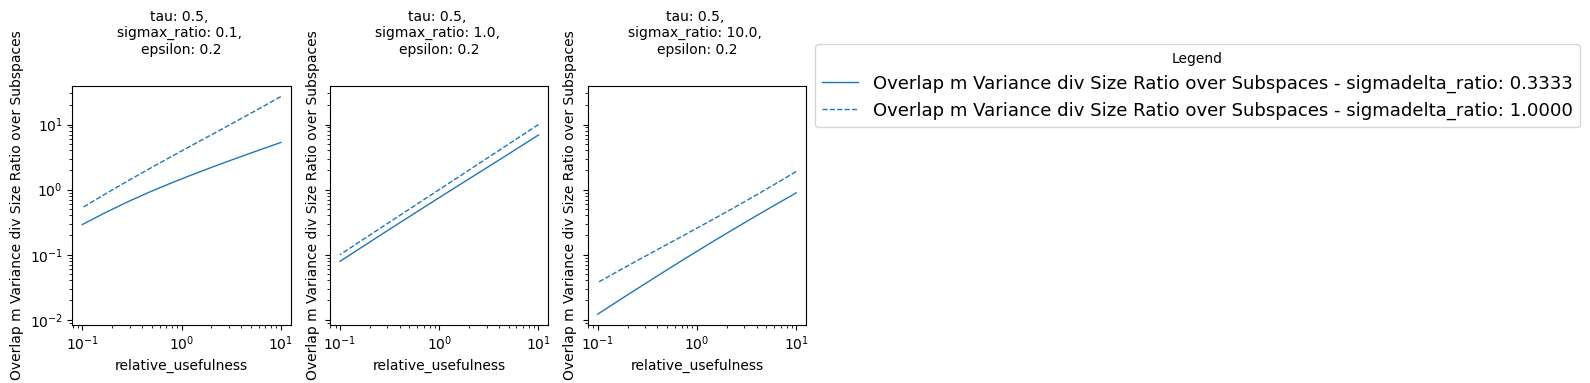

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:67: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:146: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:160: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.errorbar(epsilon_subset[target], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[0], capsize=5)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always b

saving plot


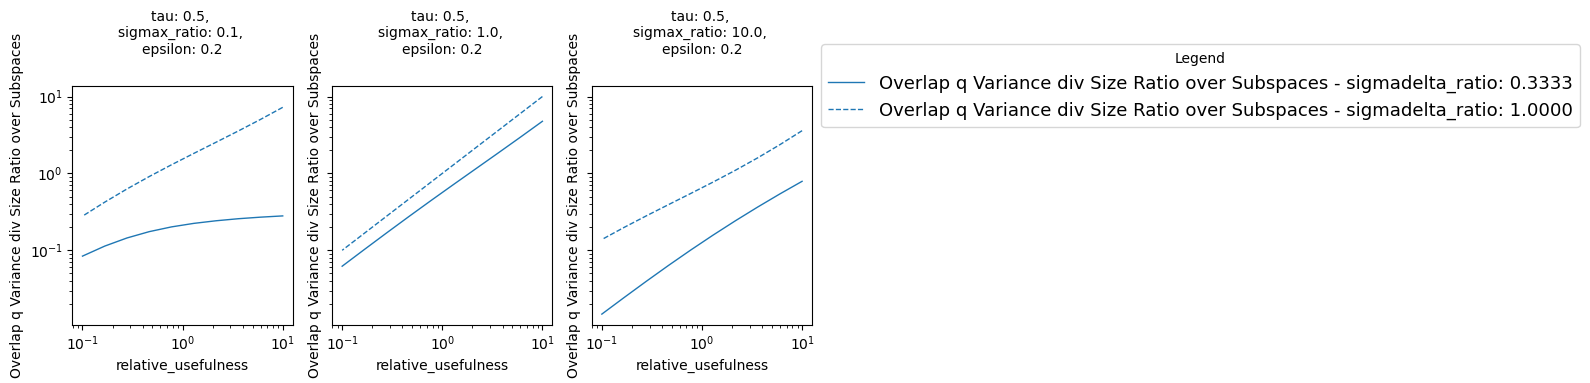

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:67: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:146: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:160: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.errorbar(epsilon_subset[target], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[0], capsize=5)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always b

saving plot


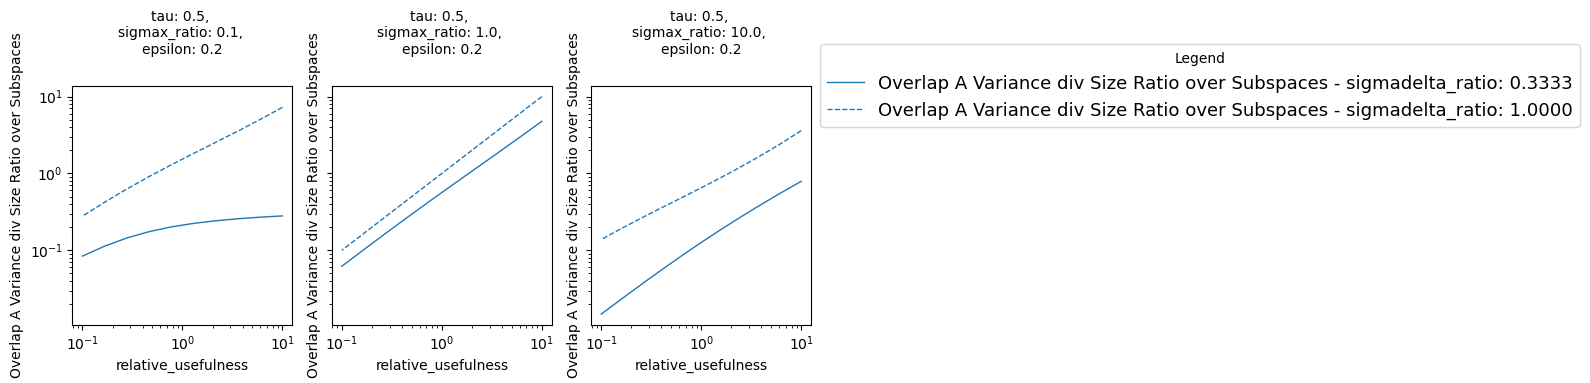

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:67: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:146: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:160: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.errorbar(epsilon_subset[target], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[0], capsize=5)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always b

saving plot


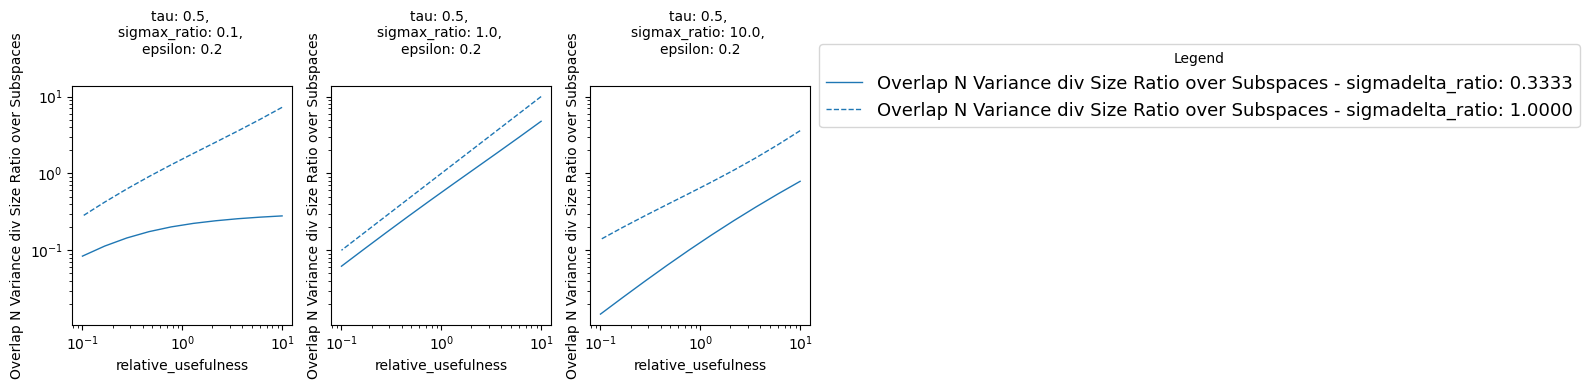

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:67: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:146: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:160: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.errorbar(epsilon_subset[target], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[0], capsize=5)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always b

saving plot


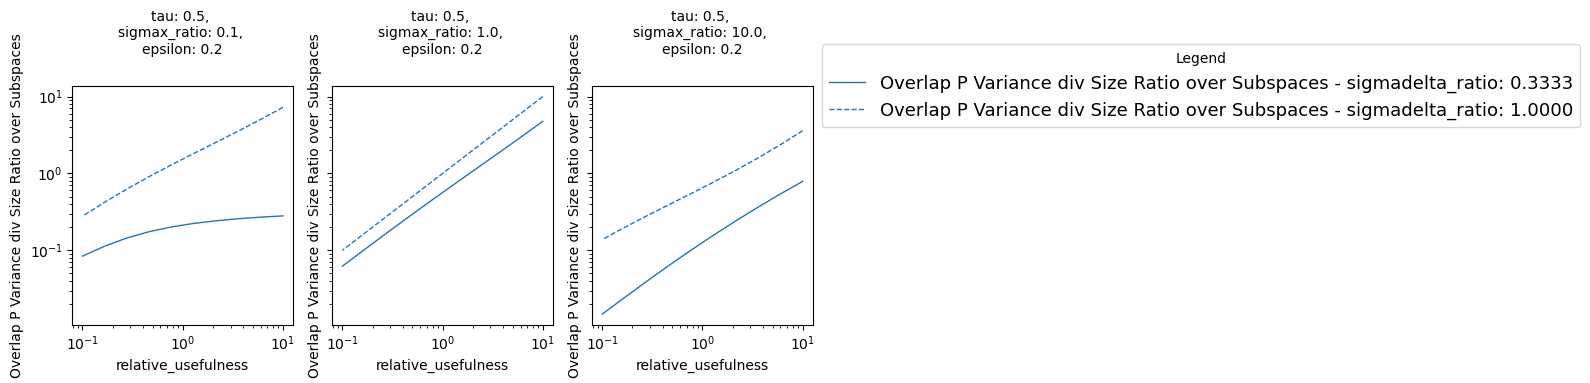

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:67: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:146: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')],  linestyle=linestyles[i], label=f'{sweep_string}', color=palette[0])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:160: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.errorbar(epsilon_subset[target], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[0], capsize=5)
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/4207878153.py:183: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always b

saving plot


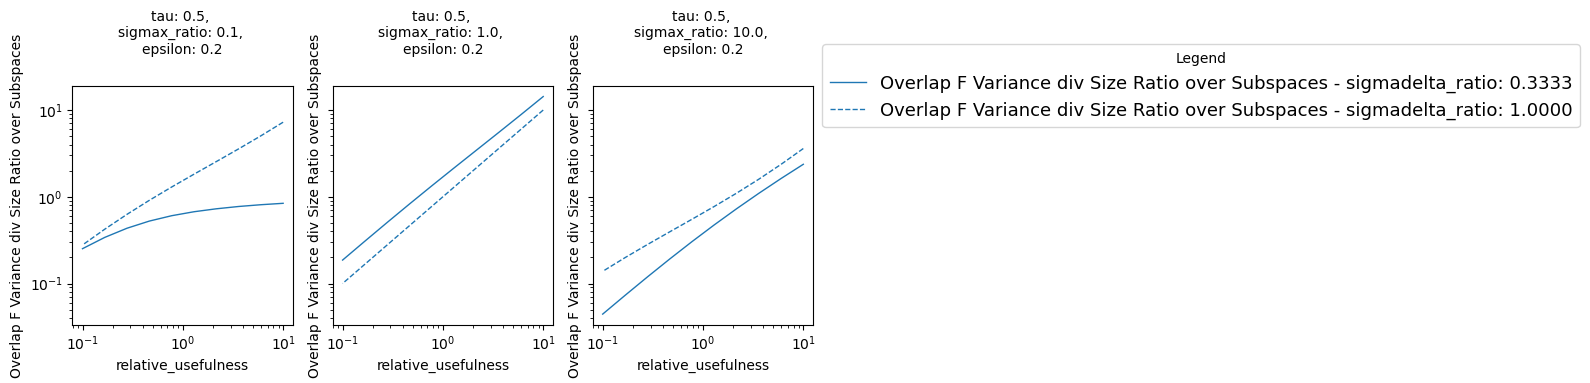

In [ ]:
overlaps = ["m","q","A","N","P","F"]

nr_subspaces = 2
for overlap in overlaps:

    create_plot(df, f"Overlap {overlap} Variance div Size Ratio over Subspaces", f"{overlap}_ratio_state_evolution",f"{overlap}_ratio_erm" )
    # , fix_a_variable="data_model_name", variable_value=data_model_name 

In [ ]:

def create_subspace_plot(df, error_name, state_evolution_name, gd_name, log_x = True, log_y=True, fix_a_variable = None, variable_value = None, filename=None, plot_attack_epsilon=False, plot_additionally_state_evolution = None, plot_additionally_gd = None, plot_additionally_names = None):
    df2 = df.reset_index()
    df2.sort_index()
    # Define a color palette to use for the different epsilon values
    palette = sns.color_palette(n_colors=len(df2[sweep].unique()))

    d = df2['d_erm']["mean"][0]

    attack_epsilons = df2["attack_epsilon"].unique()
    if not plot_attack_epsilon:
        # assign just the first attack_epsilon
        attack_epsilons = [attack_epsilons[0]]

    if fix_a_variable == "data_model_name":
        dm_names = [variable_value]
    else:
        dm_names = df2[third_iteration].unique()

    for data_model_name in dm_names:        

        for problem_type in df2["problem_type"].unique():

            for tau in df2[first_iteration].unique():

                

                for attack_epsilon in attack_epsilons:

                    
                    iterate_over = df2[second_iteration].unique() if second_iteration is not None else [None]

                    # create a list of line-styles equal to the number of entreis in iterate_over
                    linestyles = ["-", "--", "dotted", "dashdot",(0, (1, 10)),(0, (3, 1, 1, 1, 1, 1))]

                    for idx_lam, lam in enumerate(iterate_over):    

                        # Filter the dataframe for the current values of tau and lam
                        if second_iteration is None:
                            data = df2[(df2[first_iteration] == tau) & (df2["problem_type"] == problem_type) & (df2["attack_epsilon"] == attack_epsilon) & (df2[third_iteration] == data_model_name)]
                        else:
                            data = df2[(df2[first_iteration] == tau) & (df2[second_iteration] == lam) & (df2["problem_type"] == problem_type) & (df2["attack_epsilon"] == attack_epsilon) & (df2[third_iteration] == data_model_name)]

                        if fix_a_variable is not None:
                            data = data[data[fix_a_variable] == variable_value]
                        

                        fig = plt.figure(figsize=(9,5)) #
                        ax = plt.subplot(111)

                        for i, epsilon in enumerate(data[sweep].unique()):
                            # Filter the dataframe for the current value of epsilon
                            epsilon_subset = data[data[sweep] == epsilon]

                            


                            sweep_string = f"{second_iteration}: {lam:.4f}, "

                            if type(epsilon) == str:
                                sweep_string += f"{sweep}: {epsilon}"
                                if sweep == "data_model_name":
                                    sweep_string += f"Data: {data_model_name_dict[epsilon]}"
                            else:
                                sweep_string += f"{sweep}: {epsilon:.4f}"

                            # Plot the state_evolution results as a line
                            if state_evolution_name is not None:
                                if state_evolution_name in ["alpha","tau","lam","epsilon"]:
                                    ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name)], label=f'{sweep_string}', color=palette[i])
                                else:
                                    ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')], label=f'{sweep_string}', color=palette[i])

                                if plot_additionally_state_evolution is not None:

                                    # create a list of markers equal to the number of additional state evolution results to plot
                                    linestyles = [ "--", "dotted", "dashdot",(0, (1, 10)),(0, (3, 1, 1, 1, 1, 1))]
                                    idx = 0
                                    for additional_state_evolution_name, name in  zip(plot_additionally_state_evolution, plot_additionally_names):
                                        ax.plot(epsilon_subset[target], epsilon_subset[(additional_state_evolution_name, 'mean')], linestyle = linestyles[idx], label=f'{name}', color=palette[i])
                                        idx += 1

                            
                            # Plot the gradient_descent results as points with error bars
                            if gd_name is not None:
                                try:
                                    ax.errorbar(epsilon_subset[target], epsilon_subset[(gd_name, 'mean')], yerr=epsilon_subset[(gd_name, 'std')], fmt='o', color=palette[i], capsize=5)
                                except:
                                    pass

                                if plot_additionally_gd is not None:
                                    for additional_gd, name in  zip(plot_additionally_gd, plot_additionally_names):
                                        ax.errorbar(epsilon_subset[target], epsilon_subset[(additional_gd, 'mean')], yerr=epsilon_subset[(additional_gd, 'std')], fmt='o', color=palette[i ], capsize=5)

                            if error_name == "Generalization Error" and target == "lam":
                                optimal_lambda = extract_optimal_lambda(alpha=lam, epsilon=epsilon, tau=tau, data_model_type=data_model_type, data_model_name=data_model_name, problem_type=ProblemType[problem_type])
                                # plot the optimal lambda as a vertical line
                                if optimal_lambda is not None:
                                    ax.axvline(x=optimal_lambda, color=palette[i], linestyle='--')

                        
                        if log_x:
                            plt.xscale('log')
                            # plt.xscale('symlog')
                        if log_y:
                            plt.yscale('log')

                        # Add labels and title
                        plt.xlabel(target)
                        plt.ylabel(error_name)

                        replace_func = lambda match: '\n' if match.group().count('_') % 2 == 1 else ' '
                        if type(data_model_name) == str:
                            content_before_bracket = data_model_name.split('[', 1)[0]
                        else:
                            content_before_bracket = f"{third_iteration}: {data_model_name:.4f}"
                        modified_content = re.sub(r'_', replace_func, content_before_bracket)
                        # remove trailing linebreak
                        modified_content = modified_content[:-1]

                        title = f"{error_name} \n {modified_content} \n {problem_type} - {first_iteration}: {tau},"
                        # if fix_a_variable is not None:
                        #     title += f' \n d: {d} \n {fix_a_variable}: {variable_value}'
                        #     # if second_iteration is None:
                                
                        #     # else:
                        #     #     title += f' \n {second_iteration}: {lam}, d: {d} \n {fix_a_variable}: {variable_value}'
                        # else:
                        if second_iteration is None:
                            title += f' d: {d}'
                        else:
                            title += f' {second_iteration}: {lam}, d: {d}'
                        if plot_attack_epsilon:
                            title += f" \n attack_epsilon: {attack_epsilon}"
                        plt.title(title,y=1.1)
                        

                        box = ax.get_position()
                        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

                        # Put a legend to the right of the current axis
                        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

                        # add a grid
                        plt.grid()

                        plt.tight_layout()

                        # if fix_a_variable is not None:
                        #     name = f"{error_name}_{problem_type}_{data_model_name}_tau_{tau}_lam_{lam}_d_{d}_{fix_a_variable}_{variable_value}_v_{__version__}"
                        # else:
                        name = f"{error_name}_{problem_type}_{data_model_name}_tau_{tau}_lam_{lam}_d_{d}_v_{__version__}"
                        if plot_attack_epsilon:
                            name += f"_attack_epsilon_{attack_epsilon}"
                        # Save the plot as svg
                        if filename is not None or save_plots:

                            
                            if not is_multi_datamodel:
                                path = get_path(problem_type, data_model_name ,filename)
                            else:
                                path = get_multi_data_model_path(experiment_name, description)


                            plt.savefig(f"{path}_{name}.pdf", bbox_inches='tight')

                        # Show the plot
                        plt.show()

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1984963051.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1984963051.py:71: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')], label=f'{sweep_string}', color=palette[i])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1984963051.py:79: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(additional_state_evolution_name, 'mean')], linestyle = linestyles[idx], label=f'{name}', color=palette[i])


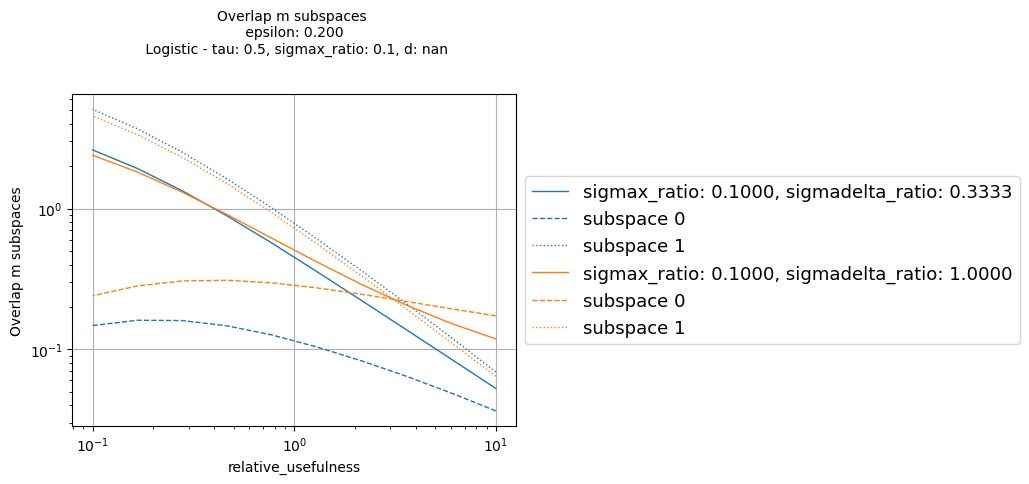

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1984963051.py:71: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')], label=f'{sweep_string}', color=palette[i])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1984963051.py:79: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(additional_state_evolution_name, 'mean')], linestyle = linestyles[idx], label=f'{name}', color=palette[i])


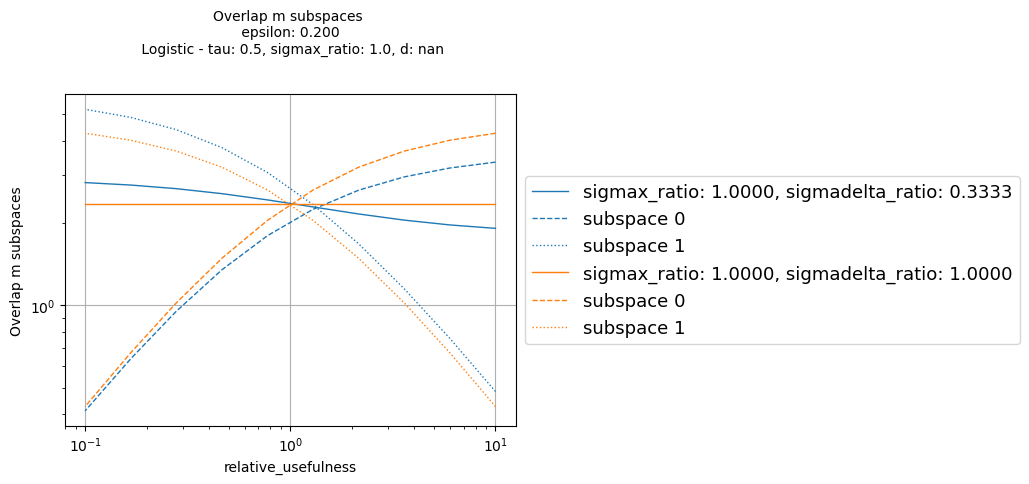

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1984963051.py:71: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')], label=f'{sweep_string}', color=palette[i])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1984963051.py:79: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(additional_state_evolution_name, 'mean')], linestyle = linestyles[idx], label=f'{name}', color=palette[i])


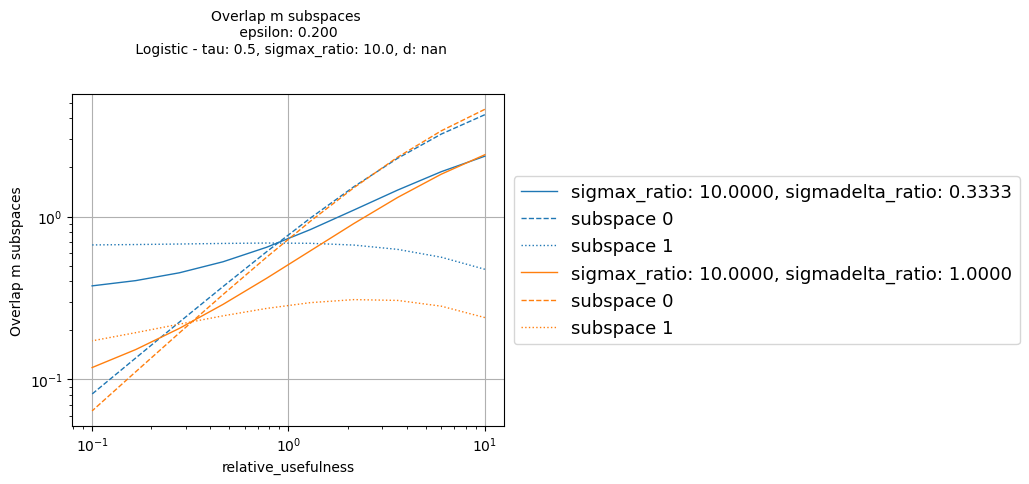

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1984963051.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1984963051.py:71: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')], label=f'{sweep_string}', color=palette[i])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1984963051.py:79: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(additional_state_evolution_name, 'mean')], linestyle = linestyles[idx], label=f'{name}', color=palette[i])


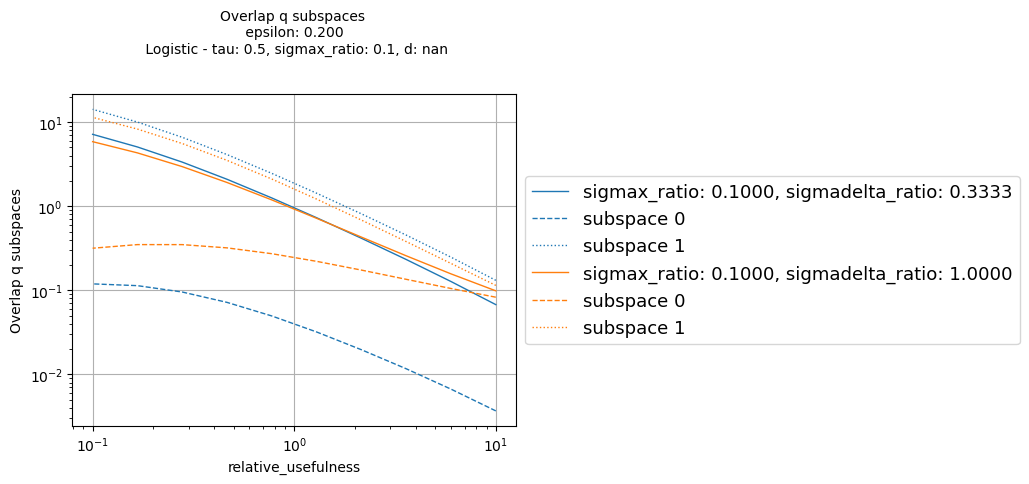

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1984963051.py:71: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')], label=f'{sweep_string}', color=palette[i])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1984963051.py:79: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(additional_state_evolution_name, 'mean')], linestyle = linestyles[idx], label=f'{name}', color=palette[i])


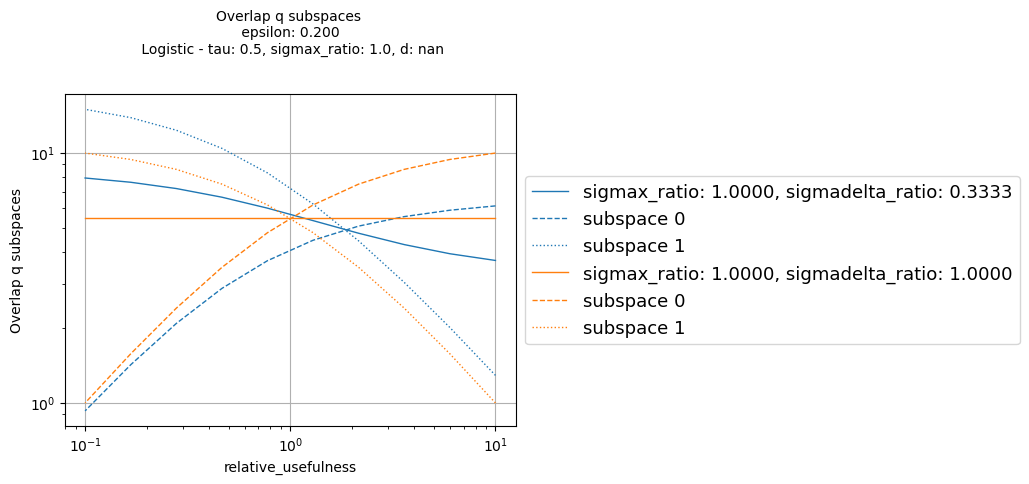

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1984963051.py:71: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')], label=f'{sweep_string}', color=palette[i])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1984963051.py:79: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(additional_state_evolution_name, 'mean')], linestyle = linestyles[idx], label=f'{name}', color=palette[i])


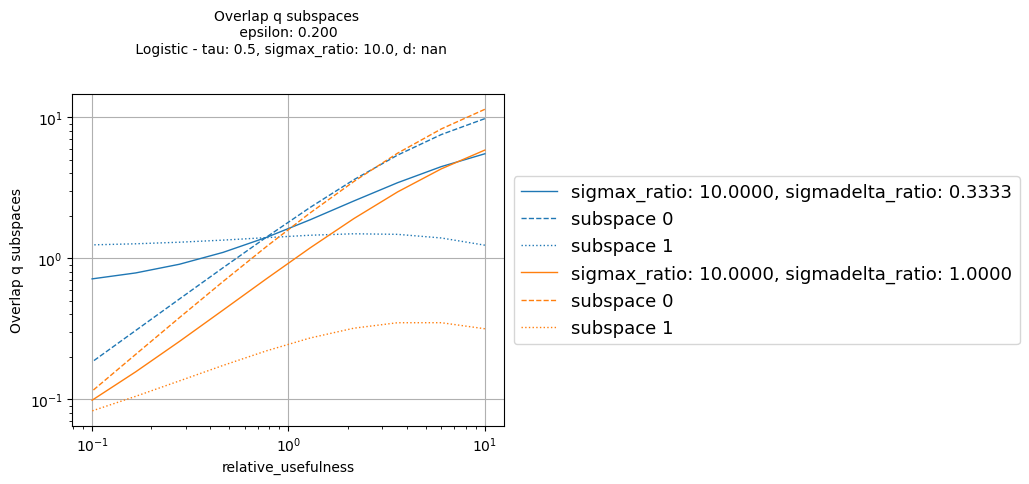

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1984963051.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1984963051.py:71: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')], label=f'{sweep_string}', color=palette[i])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1984963051.py:79: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(additional_state_evolution_name, 'mean')], linestyle = linestyles[idx], label=f'{name}', color=palette[i])


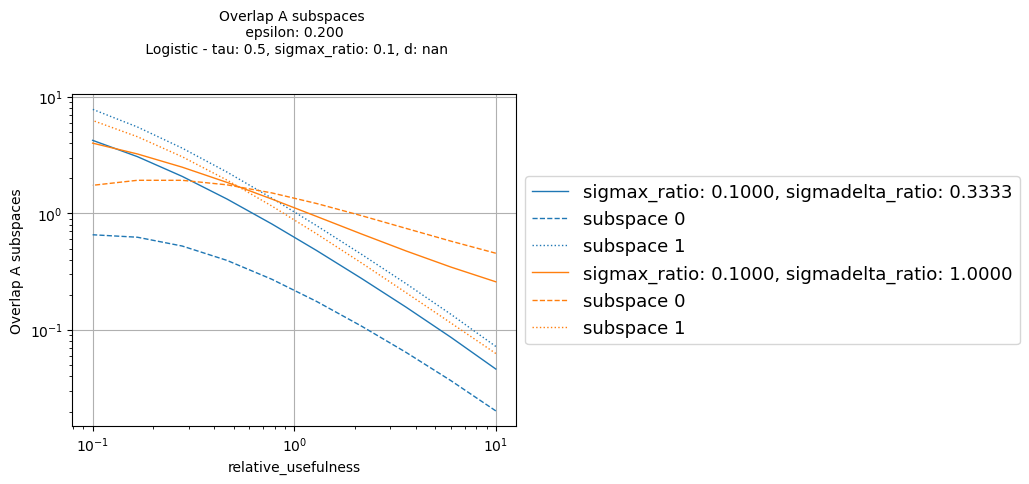

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1984963051.py:71: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')], label=f'{sweep_string}', color=palette[i])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1984963051.py:79: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(additional_state_evolution_name, 'mean')], linestyle = linestyles[idx], label=f'{name}', color=palette[i])


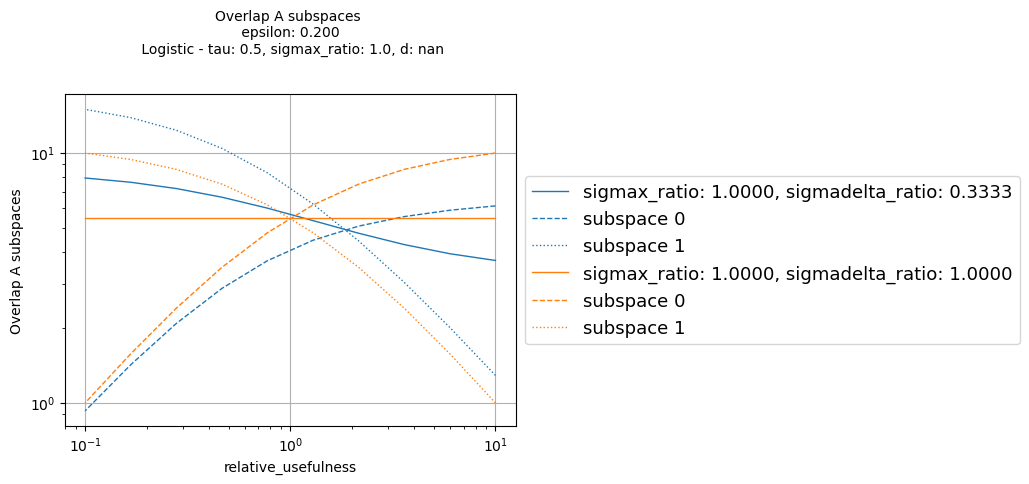

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1984963051.py:71: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')], label=f'{sweep_string}', color=palette[i])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1984963051.py:79: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(additional_state_evolution_name, 'mean')], linestyle = linestyles[idx], label=f'{name}', color=palette[i])


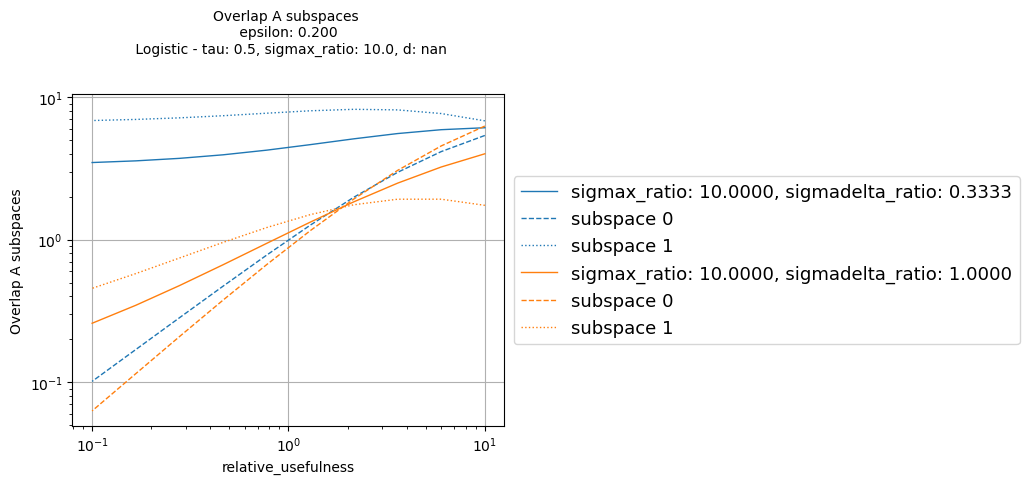

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1984963051.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1984963051.py:71: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')], label=f'{sweep_string}', color=palette[i])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1984963051.py:79: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(additional_state_evolution_name, 'mean')], linestyle = linestyles[idx], label=f'{name}', color=palette[i])


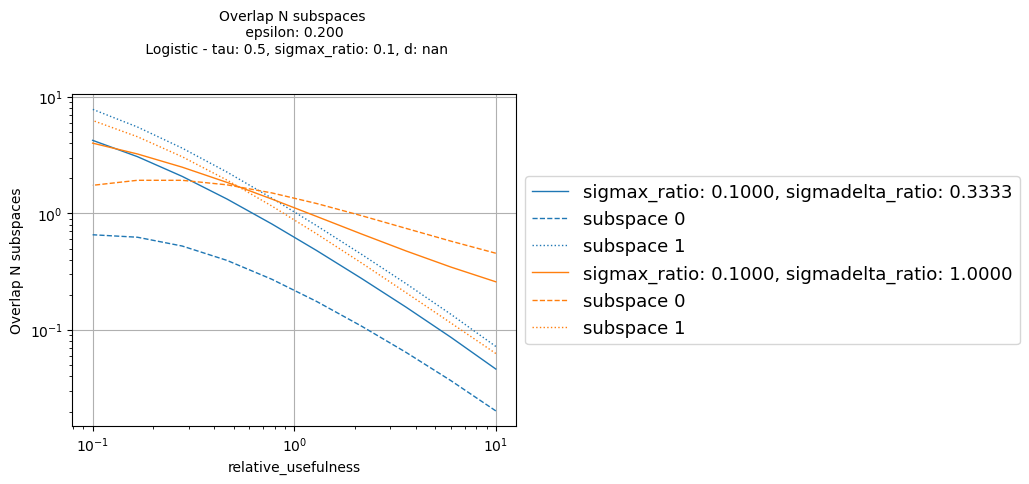

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1984963051.py:71: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')], label=f'{sweep_string}', color=palette[i])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1984963051.py:79: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(additional_state_evolution_name, 'mean')], linestyle = linestyles[idx], label=f'{name}', color=palette[i])


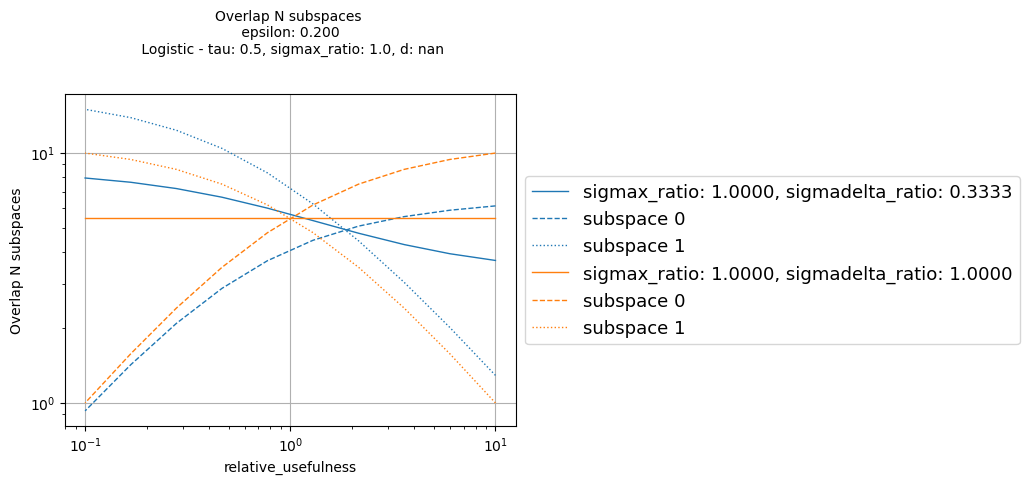

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1984963051.py:71: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')], label=f'{sweep_string}', color=palette[i])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1984963051.py:79: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(additional_state_evolution_name, 'mean')], linestyle = linestyles[idx], label=f'{name}', color=palette[i])


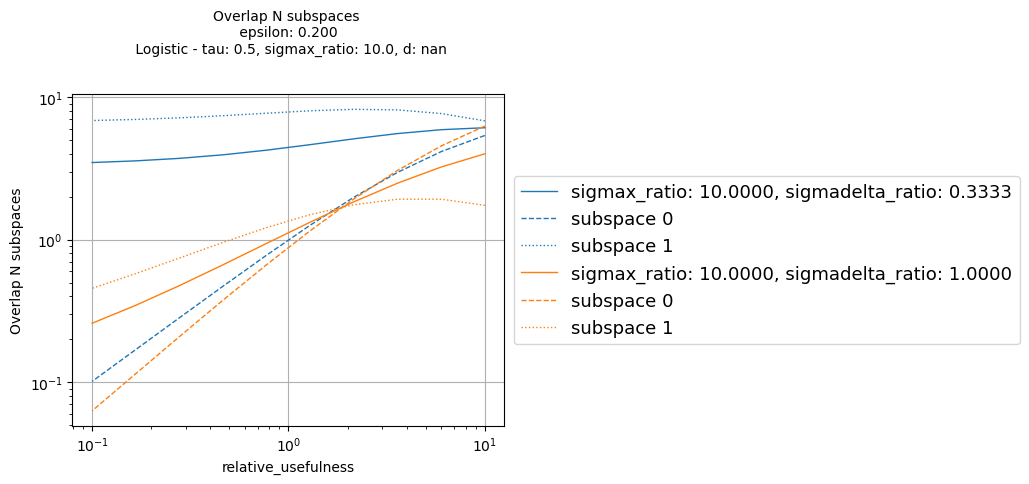

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1984963051.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1984963051.py:71: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')], label=f'{sweep_string}', color=palette[i])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1984963051.py:79: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(additional_state_evolution_name, 'mean')], linestyle = linestyles[idx], label=f'{name}', color=palette[i])


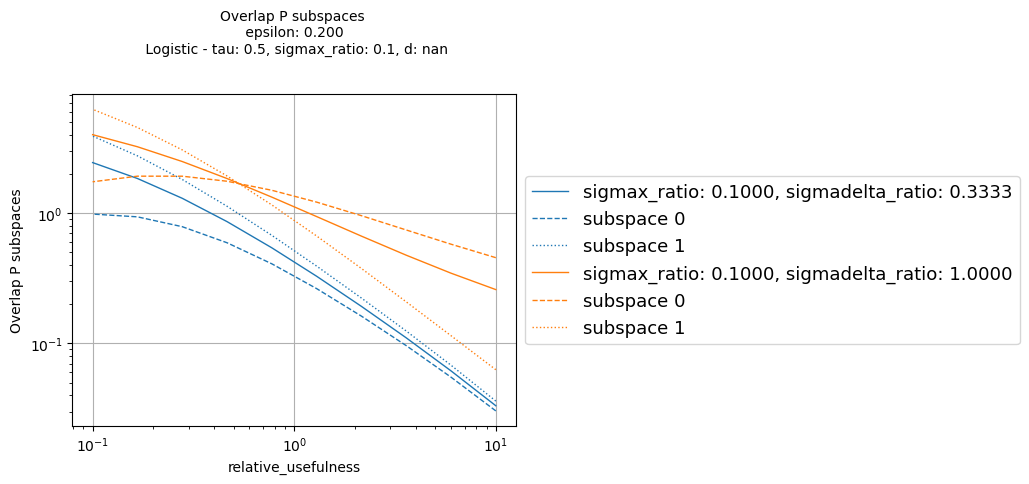

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1984963051.py:71: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')], label=f'{sweep_string}', color=palette[i])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1984963051.py:79: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(additional_state_evolution_name, 'mean')], linestyle = linestyles[idx], label=f'{name}', color=palette[i])


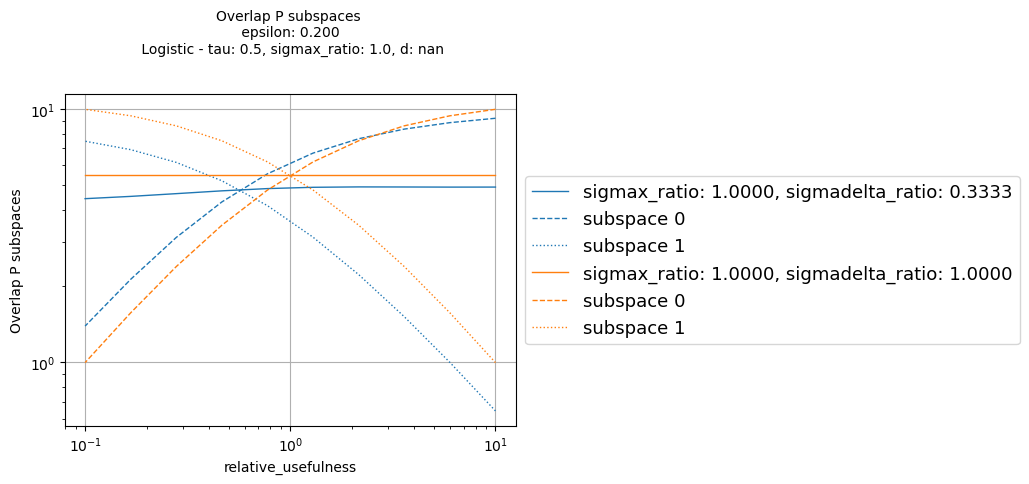

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1984963051.py:71: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')], label=f'{sweep_string}', color=palette[i])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1984963051.py:79: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(additional_state_evolution_name, 'mean')], linestyle = linestyles[idx], label=f'{name}', color=palette[i])


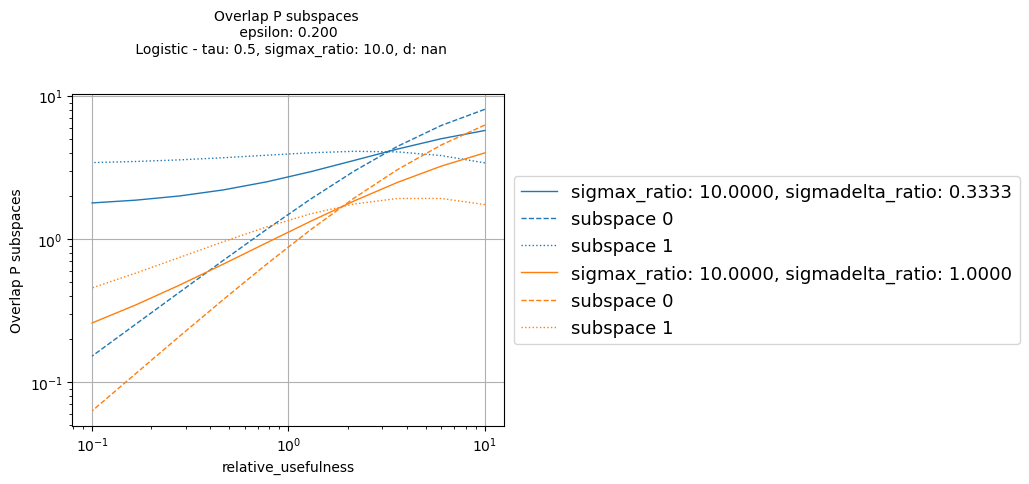

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1984963051.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  df2 = df.reset_index()
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1984963051.py:71: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')], label=f'{sweep_string}', color=palette[i])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1984963051.py:79: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(additional_state_evolution_name, 'mean')], linestyle = linestyles[idx], label=f'{name}', color=palette[i])


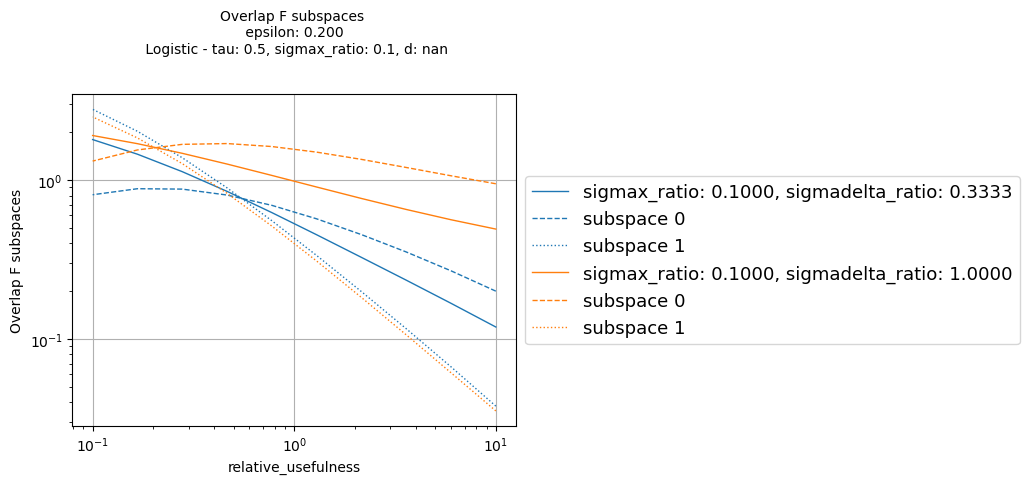

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1984963051.py:71: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')], label=f'{sweep_string}', color=palette[i])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1984963051.py:79: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(additional_state_evolution_name, 'mean')], linestyle = linestyles[idx], label=f'{name}', color=palette[i])


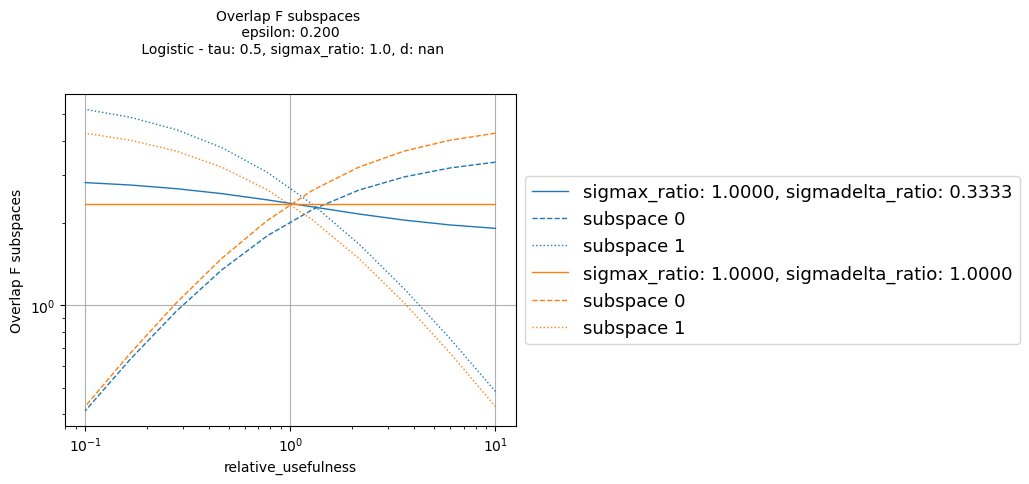

/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1984963051.py:71: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(state_evolution_name, 'mean')], label=f'{sweep_string}', color=palette[i])
/var/folders/4p/9b_m1n3130xfbjd06qfyyqgc0000gn/T/ipykernel_50806/1984963051.py:79: PerformanceWarning: indexing past lexsort depth may impact performance.
  ax.plot(epsilon_subset[target], epsilon_subset[(additional_state_evolution_name, 'mean')], linestyle = linestyles[idx], label=f'{name}', color=palette[i])


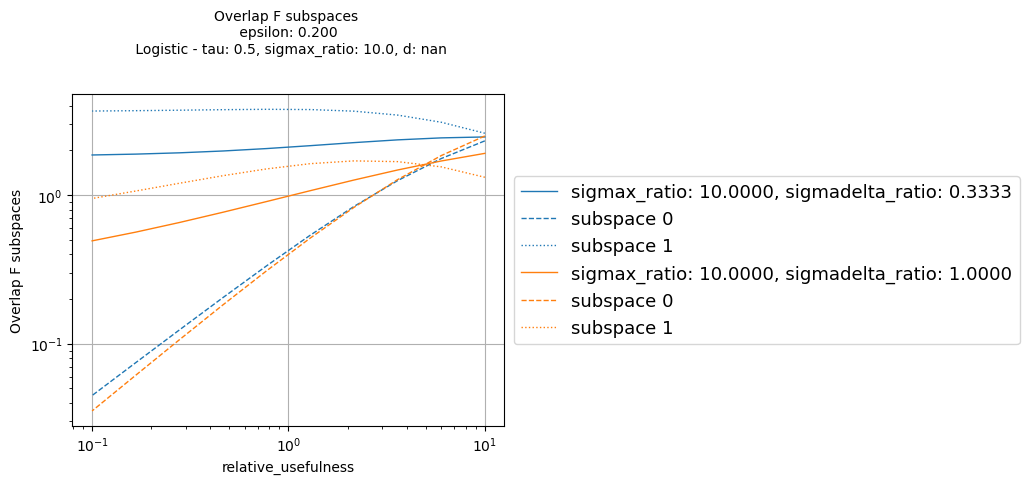

In [ ]:
overlaps = ["m","q","A","N","P","F"]

# iterate over the data_models dict
# for data_model_key, data_model in data_models.items():
#     data_model_type = data_model_key[0]
#     data_model_name = data_model_key[1]

#     # check if data_model has attribute feature_sizes
#     if hasattr(data_model, "feature_sizes"):
#         feature_sizes = data_model.feature_sizes
#         nr_subspaces = len(feature_sizes)
#     else:
#         nr_subspaces = 1

nr_subspaces = 2
for overlap in overlaps:
    plot_additionally_gd = []
    plot_additionally_state_evolution = []
    plot_additionally_names = []
    for i in range(nr_subspaces):
        plot_additionally_state_evolution.append(f"{overlap}_{i}_state_evolution")
        plot_additionally_names.append(f"subspace {i}")
    create_subspace_plot(df, f"Overlap {overlap} subspaces", f"{overlap}_state_evolution",None,plot_additionally_gd=None,plot_additionally_state_evolution=plot_additionally_state_evolution,plot_additionally_names=plot_additionally_names )
    # , fix_a_variable="data_model_name", variable_value=data_model_name 
